In [1]:
import os
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.utils as vutils
%matplotlib inline

In [2]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

## 데이터 로딩

In [3]:
img_size = 64
batch_size=64
lr = 0.0002
beta1 = 0.5
niter= 25
outf= 'output'

dataset = datasets.CIFAR10( root = 'data',download=True,
                       transform=transforms.Compose([
                           transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size,
                                         shuffle=True)


Files already downloaded and verified


In [4]:
#Size of latnet vector
nz = 100
# Filter size of generator
ngf = 64
# Filter size of discriminator
ndf = 64
# Output image channels
nc = 3

# 네트워크 초기화

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# 생성기

In [6]:
class _netG(nn.Module):
    def __init__(self):
        super(_netG, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output


netG = _netG()
netG.apply(weights_init)
print(netG)

_netG(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# 판별기

In [7]:
class _netD(nn.Module):
    def __init__(self):
        super(_netD, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)


netD = _netD()
netD.apply(weights_init)
print(netD)

_netD(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# 오차 함수 정의

In [8]:

criterion = nn.BCELoss()

input = torch.FloatTensor(batch_size, 3, img_size, img_size)
noise = torch.FloatTensor(batch_size, nz, 1, 1)
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

In [9]:
if torch.cuda.is_available():
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

# 옵티마이저 정의

In [10]:
fixed_noise = Variable(fixed_noise)

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr, betas=(beta1, 0.999))

# 학습 

In [11]:
%%time
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
        if torch.cuda.is_available():
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.data.item(), errG.data.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)

[0/25][0/782] Loss_D: 1.5982 Loss_G: 3.8903 D(x): 0.4078 D(G(z)): 0.3371 / 0.0249
[0/25][1/782] Loss_D: 1.9668 Loss_G: 5.5450 D(x): 0.8446 D(G(z)): 0.7732 / 0.0064
[0/25][2/782] Loss_D: 1.2608 Loss_G: 6.4214 D(x): 0.7212 D(G(z)): 0.5056 / 0.0024
[0/25][3/782] Loss_D: 0.9809 Loss_G: 5.8085 D(x): 0.6225 D(G(z)): 0.2665 / 0.0046
[0/25][4/782] Loss_D: 1.1206 Loss_G: 5.7997 D(x): 0.6614 D(G(z)): 0.3469 / 0.0046
[0/25][5/782] Loss_D: 1.0765 Loss_G: 7.1541 D(x): 0.7388 D(G(z)): 0.4243 / 0.0013
[0/25][6/782] Loss_D: 0.9125 Loss_G: 7.3464 D(x): 0.7297 D(G(z)): 0.3049 / 0.0010
[0/25][7/782] Loss_D: 0.9161 Loss_G: 7.0806 D(x): 0.6885 D(G(z)): 0.2801 / 0.0014
[0/25][8/782] Loss_D: 1.1043 Loss_G: 8.0684 D(x): 0.6972 D(G(z)): 0.3583 / 0.0005
[0/25][9/782] Loss_D: 0.7742 Loss_G: 9.0519 D(x): 0.7856 D(G(z)): 0.3103 / 0.0002
[0/25][10/782] Loss_D: 0.5946 Loss_G: 8.5606 D(x): 0.7850 D(G(z)): 0.2125 / 0.0003
[0/25][11/782] Loss_D: 0.8951 Loss_G: 9.5581 D(x): 0.7641 D(G(z)): 0.3136 / 0.0001
[0/25][12/782]

[0/25][101/782] Loss_D: 0.3879 Loss_G: 15.1887 D(x): 0.7790 D(G(z)): 0.0005 / 0.0000
[0/25][102/782] Loss_D: 0.5687 Loss_G: 10.2141 D(x): 0.7870 D(G(z)): 0.0019 / 0.0006
[0/25][103/782] Loss_D: 0.2929 Loss_G: 5.0719 D(x): 0.8898 D(G(z)): 0.0939 / 0.0142
[0/25][104/782] Loss_D: 0.8500 Loss_G: 10.2202 D(x): 0.9269 D(G(z)): 0.4729 / 0.0001
[0/25][105/782] Loss_D: 0.5083 Loss_G: 7.1704 D(x): 0.7456 D(G(z)): 0.0234 / 0.0012
[0/25][106/782] Loss_D: 0.3817 Loss_G: 4.7350 D(x): 0.8224 D(G(z)): 0.1062 / 0.0152
[0/25][107/782] Loss_D: 0.5858 Loss_G: 8.2420 D(x): 0.9132 D(G(z)): 0.3585 / 0.0005
[0/25][108/782] Loss_D: 0.3109 Loss_G: 7.2016 D(x): 0.8011 D(G(z)): 0.0126 / 0.0013
[0/25][109/782] Loss_D: 0.3010 Loss_G: 4.2059 D(x): 0.8687 D(G(z)): 0.1010 / 0.0191
[0/25][110/782] Loss_D: 0.7531 Loss_G: 9.2340 D(x): 0.9440 D(G(z)): 0.4511 / 0.0002
[0/25][111/782] Loss_D: 0.4285 Loss_G: 7.8591 D(x): 0.7202 D(G(z)): 0.0028 / 0.0006
[0/25][112/782] Loss_D: 0.3660 Loss_G: 3.3211 D(x): 0.7556 D(G(z)): 0.019

[0/25][201/782] Loss_D: 0.2646 Loss_G: 5.1354 D(x): 0.8763 D(G(z)): 0.0721 / 0.0082
[0/25][202/782] Loss_D: 0.2071 Loss_G: 7.8329 D(x): 0.9843 D(G(z)): 0.1615 / 0.0006
[0/25][203/782] Loss_D: 0.1679 Loss_G: 6.3759 D(x): 0.8862 D(G(z)): 0.0106 / 0.0025
[0/25][204/782] Loss_D: 0.1122 Loss_G: 4.4512 D(x): 0.9379 D(G(z)): 0.0353 / 0.0157
[0/25][205/782] Loss_D: 0.2833 Loss_G: 7.8154 D(x): 0.9715 D(G(z)): 0.2152 / 0.0006
[0/25][206/782] Loss_D: 0.2974 Loss_G: 5.4633 D(x): 0.7876 D(G(z)): 0.0075 / 0.0055
[0/25][207/782] Loss_D: 0.1746 Loss_G: 4.5638 D(x): 0.9479 D(G(z)): 0.0843 / 0.0145
[0/25][208/782] Loss_D: 0.2515 Loss_G: 7.4264 D(x): 0.9648 D(G(z)): 0.1801 / 0.0008
[0/25][209/782] Loss_D: 0.2304 Loss_G: 5.5958 D(x): 0.8466 D(G(z)): 0.0095 / 0.0045
[0/25][210/782] Loss_D: 0.0909 Loss_G: 4.6983 D(x): 0.9700 D(G(z)): 0.0577 / 0.0106
[0/25][211/782] Loss_D: 0.1595 Loss_G: 5.6437 D(x): 0.9531 D(G(z)): 0.1018 / 0.0043
[0/25][212/782] Loss_D: 0.2806 Loss_G: 4.6969 D(x): 0.8352 D(G(z)): 0.0787 /

[0/25][301/782] Loss_D: 0.2603 Loss_G: 10.0475 D(x): 0.8513 D(G(z)): 0.0008 / 0.0001
[0/25][302/782] Loss_D: 0.1224 Loss_G: 7.7696 D(x): 0.9030 D(G(z)): 0.0009 / 0.0013
[0/25][303/782] Loss_D: 0.1428 Loss_G: 4.6619 D(x): 0.9159 D(G(z)): 0.0094 / 0.0178
[0/25][304/782] Loss_D: 0.2200 Loss_G: 7.2162 D(x): 0.9897 D(G(z)): 0.1735 / 0.0015
[0/25][305/782] Loss_D: 0.0545 Loss_G: 7.4594 D(x): 0.9657 D(G(z)): 0.0126 / 0.0011
[0/25][306/782] Loss_D: 0.1210 Loss_G: 5.8191 D(x): 0.9203 D(G(z)): 0.0101 / 0.0066
[0/25][307/782] Loss_D: 0.1805 Loss_G: 4.4042 D(x): 0.9235 D(G(z)): 0.0551 / 0.0216
[0/25][308/782] Loss_D: 0.1815 Loss_G: 7.1484 D(x): 0.9821 D(G(z)): 0.1423 / 0.0013
[0/25][309/782] Loss_D: 0.0673 Loss_G: 7.1823 D(x): 0.9523 D(G(z)): 0.0099 / 0.0014
[0/25][310/782] Loss_D: 0.0913 Loss_G: 5.7866 D(x): 0.9452 D(G(z)): 0.0117 / 0.0058
[0/25][311/782] Loss_D: 0.1606 Loss_G: 4.1585 D(x): 0.9141 D(G(z)): 0.0283 / 0.0207
[0/25][312/782] Loss_D: 0.2490 Loss_G: 8.6063 D(x): 0.9857 D(G(z)): 0.1892 

[0/25][401/782] Loss_D: 0.2347 Loss_G: 5.3180 D(x): 0.8308 D(G(z)): 0.0103 / 0.0127
[0/25][402/782] Loss_D: 0.3366 Loss_G: 9.2785 D(x): 0.9703 D(G(z)): 0.2241 / 0.0002
[0/25][403/782] Loss_D: 0.6385 Loss_G: 2.5756 D(x): 0.6561 D(G(z)): 0.0037 / 0.1458
[0/25][404/782] Loss_D: 1.0016 Loss_G: 15.0198 D(x): 0.9854 D(G(z)): 0.5269 / 0.0000
[0/25][405/782] Loss_D: 5.2388 Loss_G: 5.8100 D(x): 0.0838 D(G(z)): 0.0001 / 0.0363
[0/25][406/782] Loss_D: 0.5829 Loss_G: 6.0203 D(x): 0.8612 D(G(z)): 0.2163 / 0.0699
[0/25][407/782] Loss_D: 1.1615 Loss_G: 3.7997 D(x): 0.6671 D(G(z)): 0.2159 / 0.1294
[0/25][408/782] Loss_D: 1.1107 Loss_G: 10.1347 D(x): 0.8674 D(G(z)): 0.4491 / 0.0001
[0/25][409/782] Loss_D: 2.5722 Loss_G: 1.3802 D(x): 0.2875 D(G(z)): 0.0113 / 0.3700
[0/25][410/782] Loss_D: 1.3412 Loss_G: 8.4695 D(x): 0.9971 D(G(z)): 0.6100 / 0.0009
[0/25][411/782] Loss_D: 0.3533 Loss_G: 7.5266 D(x): 0.7927 D(G(z)): 0.0132 / 0.0032
[0/25][412/782] Loss_D: 0.3874 Loss_G: 3.9927 D(x): 0.7704 D(G(z)): 0.0323

[0/25][501/782] Loss_D: 0.1936 Loss_G: 5.1228 D(x): 0.8814 D(G(z)): 0.0448 / 0.0084
[0/25][502/782] Loss_D: 0.2843 Loss_G: 3.1559 D(x): 0.8249 D(G(z)): 0.0700 / 0.0583
[0/25][503/782] Loss_D: 0.5193 Loss_G: 7.0617 D(x): 0.9571 D(G(z)): 0.3425 / 0.0015
[0/25][504/782] Loss_D: 0.6822 Loss_G: 4.3122 D(x): 0.6022 D(G(z)): 0.0126 / 0.0239
[0/25][505/782] Loss_D: 0.2495 Loss_G: 3.9749 D(x): 0.9603 D(G(z)): 0.1611 / 0.0340
[0/25][506/782] Loss_D: 0.1700 Loss_G: 4.9228 D(x): 0.9575 D(G(z)): 0.1068 / 0.0143
[0/25][507/782] Loss_D: 0.1126 Loss_G: 4.8245 D(x): 0.9411 D(G(z)): 0.0445 / 0.0145
[0/25][508/782] Loss_D: 0.1235 Loss_G: 4.4130 D(x): 0.9510 D(G(z)): 0.0615 / 0.0187
[0/25][509/782] Loss_D: 0.1769 Loss_G: 4.1115 D(x): 0.9291 D(G(z)): 0.0851 / 0.0250
[0/25][510/782] Loss_D: 0.1405 Loss_G: 3.9144 D(x): 0.9187 D(G(z)): 0.0501 / 0.0267
[0/25][511/782] Loss_D: 0.1634 Loss_G: 4.4993 D(x): 0.9731 D(G(z)): 0.1212 / 0.0151
[0/25][512/782] Loss_D: 0.1587 Loss_G: 4.2539 D(x): 0.9056 D(G(z)): 0.0473 /

[0/25][601/782] Loss_D: 0.7367 Loss_G: 7.0476 D(x): 0.9752 D(G(z)): 0.4411 / 0.0015
[0/25][602/782] Loss_D: 0.2841 Loss_G: 6.0311 D(x): 0.7939 D(G(z)): 0.0148 / 0.0046
[0/25][603/782] Loss_D: 0.1656 Loss_G: 4.2123 D(x): 0.8931 D(G(z)): 0.0340 / 0.0310
[0/25][604/782] Loss_D: 0.3549 Loss_G: 4.3517 D(x): 0.9105 D(G(z)): 0.1975 / 0.0174
[0/25][605/782] Loss_D: 0.2197 Loss_G: 4.4985 D(x): 0.8962 D(G(z)): 0.0862 / 0.0164
[0/25][606/782] Loss_D: 0.2742 Loss_G: 4.6993 D(x): 0.9212 D(G(z)): 0.1534 / 0.0148
[0/25][607/782] Loss_D: 0.1969 Loss_G: 4.9079 D(x): 0.9127 D(G(z)): 0.0852 / 0.0130
[0/25][608/782] Loss_D: 0.1458 Loss_G: 4.4896 D(x): 0.9198 D(G(z)): 0.0468 / 0.0149
[0/25][609/782] Loss_D: 0.2321 Loss_G: 3.8587 D(x): 0.8909 D(G(z)): 0.0957 / 0.0254
[0/25][610/782] Loss_D: 0.3981 Loss_G: 7.6586 D(x): 0.9601 D(G(z)): 0.2768 / 0.0006
[0/25][611/782] Loss_D: 0.5837 Loss_G: 5.3093 D(x): 0.6520 D(G(z)): 0.0045 / 0.0061
[0/25][612/782] Loss_D: 0.1359 Loss_G: 4.7756 D(x): 0.9832 D(G(z)): 0.1074 /

[0/25][701/782] Loss_D: 0.1815 Loss_G: 4.8373 D(x): 0.8900 D(G(z)): 0.0446 / 0.0105
[0/25][702/782] Loss_D: 0.3699 Loss_G: 4.7382 D(x): 0.8413 D(G(z)): 0.1256 / 0.0132
[0/25][703/782] Loss_D: 0.2919 Loss_G: 6.0661 D(x): 0.8902 D(G(z)): 0.1487 / 0.0034
[0/25][704/782] Loss_D: 0.4192 Loss_G: 4.0157 D(x): 0.7428 D(G(z)): 0.0558 / 0.0301
[0/25][705/782] Loss_D: 0.4242 Loss_G: 10.0228 D(x): 0.9924 D(G(z)): 0.3110 / 0.0001
[0/25][706/782] Loss_D: 0.0406 Loss_G: 11.0874 D(x): 0.9614 D(G(z)): 0.0005 / 0.0000
[0/25][707/782] Loss_D: 0.2596 Loss_G: 7.0161 D(x): 0.8029 D(G(z)): 0.0009 / 0.0014
[0/25][708/782] Loss_D: 0.0660 Loss_G: 4.3428 D(x): 0.9652 D(G(z)): 0.0284 / 0.0203
[0/25][709/782] Loss_D: 0.3967 Loss_G: 10.7800 D(x): 0.9911 D(G(z)): 0.2901 / 0.0000
[0/25][710/782] Loss_D: 0.1024 Loss_G: 9.8781 D(x): 0.9111 D(G(z)): 0.0009 / 0.0002
[0/25][711/782] Loss_D: 0.0920 Loss_G: 6.0049 D(x): 0.9199 D(G(z)): 0.0040 / 0.0085
[0/25][712/782] Loss_D: 0.2529 Loss_G: 5.6171 D(x): 0.9571 D(G(z)): 0.159

[1/25][17/782] Loss_D: 0.3170 Loss_G: 3.6081 D(x): 0.8162 D(G(z)): 0.0456 / 0.0359
[1/25][18/782] Loss_D: 0.2860 Loss_G: 4.0478 D(x): 0.9038 D(G(z)): 0.1544 / 0.0212
[1/25][19/782] Loss_D: 0.2149 Loss_G: 4.4327 D(x): 0.9011 D(G(z)): 0.0882 / 0.0170
[1/25][20/782] Loss_D: 0.2389 Loss_G: 4.6238 D(x): 0.9110 D(G(z)): 0.1234 / 0.0132
[1/25][21/782] Loss_D: 0.1307 Loss_G: 4.7927 D(x): 0.9123 D(G(z)): 0.0334 / 0.0119
[1/25][22/782] Loss_D: 0.2190 Loss_G: 4.6483 D(x): 0.9153 D(G(z)): 0.1127 / 0.0131
[1/25][23/782] Loss_D: 0.2235 Loss_G: 4.1871 D(x): 0.8771 D(G(z)): 0.0639 / 0.0206
[1/25][24/782] Loss_D: 0.2396 Loss_G: 4.5149 D(x): 0.9062 D(G(z)): 0.1170 / 0.0142
[1/25][25/782] Loss_D: 0.1772 Loss_G: 4.5878 D(x): 0.9104 D(G(z)): 0.0707 / 0.0140
[1/25][26/782] Loss_D: 0.1194 Loss_G: 4.2624 D(x): 0.9326 D(G(z)): 0.0418 / 0.0163
[1/25][27/782] Loss_D: 0.1507 Loss_G: 4.9508 D(x): 0.9541 D(G(z)): 0.0948 / 0.0088
[1/25][28/782] Loss_D: 0.1338 Loss_G: 4.6892 D(x): 0.9118 D(G(z)): 0.0359 / 0.0112
[1/2

[1/25][117/782] Loss_D: 0.4103 Loss_G: 2.6522 D(x): 0.7725 D(G(z)): 0.0831 / 0.1008
[1/25][118/782] Loss_D: 0.8359 Loss_G: 10.4208 D(x): 0.9534 D(G(z)): 0.5018 / 0.0000
[1/25][119/782] Loss_D: 2.6198 Loss_G: 3.1575 D(x): 0.1376 D(G(z)): 0.0003 / 0.1243
[1/25][120/782] Loss_D: 0.6756 Loss_G: 7.3012 D(x): 0.9856 D(G(z)): 0.4033 / 0.0049
[1/25][121/782] Loss_D: 0.7610 Loss_G: 3.0031 D(x): 0.6048 D(G(z)): 0.0361 / 0.1331
[1/25][122/782] Loss_D: 0.7833 Loss_G: 5.9026 D(x): 0.9955 D(G(z)): 0.3846 / 0.0103
[1/25][123/782] Loss_D: 0.1630 Loss_G: 5.7265 D(x): 0.9207 D(G(z)): 0.0649 / 0.0116
[1/25][124/782] Loss_D: 0.4490 Loss_G: 3.6498 D(x): 0.7777 D(G(z)): 0.0489 / 0.0508
[1/25][125/782] Loss_D: 0.4652 Loss_G: 5.9230 D(x): 0.9757 D(G(z)): 0.2969 / 0.0052
[1/25][126/782] Loss_D: 0.3066 Loss_G: 4.3878 D(x): 0.8202 D(G(z)): 0.0620 / 0.0190
[1/25][127/782] Loss_D: 0.2846 Loss_G: 3.6391 D(x): 0.8733 D(G(z)): 0.1199 / 0.0411
[1/25][128/782] Loss_D: 0.3996 Loss_G: 8.7588 D(x): 0.9828 D(G(z)): 0.2945 

[1/25][217/782] Loss_D: 0.1840 Loss_G: 4.5846 D(x): 0.8924 D(G(z)): 0.0572 / 0.0180
[1/25][218/782] Loss_D: 0.1379 Loss_G: 4.0922 D(x): 0.9117 D(G(z)): 0.0371 / 0.0261
[1/25][219/782] Loss_D: 0.3093 Loss_G: 4.5624 D(x): 0.8975 D(G(z)): 0.1563 / 0.0229
[1/25][220/782] Loss_D: 0.2734 Loss_G: 4.3792 D(x): 0.8699 D(G(z)): 0.1008 / 0.0192
[1/25][221/782] Loss_D: 0.1462 Loss_G: 4.7573 D(x): 0.9365 D(G(z)): 0.0741 / 0.0137
[1/25][222/782] Loss_D: 0.2281 Loss_G: 6.5695 D(x): 0.9551 D(G(z)): 0.1246 / 0.0038
[1/25][223/782] Loss_D: 0.5895 Loss_G: 3.6189 D(x): 0.7048 D(G(z)): 0.0096 / 0.0595
[1/25][224/782] Loss_D: 0.3287 Loss_G: 6.3585 D(x): 0.9721 D(G(z)): 0.2389 / 0.0035
[1/25][225/782] Loss_D: 0.0743 Loss_G: 6.5665 D(x): 0.9492 D(G(z)): 0.0184 / 0.0027
[1/25][226/782] Loss_D: 0.0913 Loss_G: 5.2823 D(x): 0.9401 D(G(z)): 0.0231 / 0.0095
[1/25][227/782] Loss_D: 0.1043 Loss_G: 4.6936 D(x): 0.9628 D(G(z)): 0.0606 / 0.0134
[1/25][228/782] Loss_D: 0.4366 Loss_G: 8.9903 D(x): 0.9716 D(G(z)): 0.3088 /

[1/25][317/782] Loss_D: 0.5489 Loss_G: 4.4719 D(x): 0.9457 D(G(z)): 0.3373 / 0.0200
[1/25][318/782] Loss_D: 0.7117 Loss_G: 2.9986 D(x): 0.6822 D(G(z)): 0.1909 / 0.0711
[1/25][319/782] Loss_D: 0.7500 Loss_G: 3.1180 D(x): 0.7577 D(G(z)): 0.2834 / 0.0980
[1/25][320/782] Loss_D: 0.3288 Loss_G: 4.1789 D(x): 0.8892 D(G(z)): 0.1426 / 0.0309
[1/25][321/782] Loss_D: 0.6589 Loss_G: 2.3375 D(x): 0.6934 D(G(z)): 0.1804 / 0.1447
[1/25][322/782] Loss_D: 1.1123 Loss_G: 5.6252 D(x): 0.8436 D(G(z)): 0.5354 / 0.0061
[1/25][323/782] Loss_D: 1.7201 Loss_G: 1.4525 D(x): 0.2459 D(G(z)): 0.0142 / 0.3483
[1/25][324/782] Loss_D: 1.2763 Loss_G: 6.5476 D(x): 0.9615 D(G(z)): 0.6424 / 0.0026
[1/25][325/782] Loss_D: 0.4235 Loss_G: 5.2142 D(x): 0.7208 D(G(z)): 0.0233 / 0.0119
[1/25][326/782] Loss_D: 0.4168 Loss_G: 2.5004 D(x): 0.7203 D(G(z)): 0.0322 / 0.1304
[1/25][327/782] Loss_D: 0.4420 Loss_G: 3.0657 D(x): 0.9249 D(G(z)): 0.2785 / 0.0584
[1/25][328/782] Loss_D: 0.7282 Loss_G: 4.7533 D(x): 0.8506 D(G(z)): 0.3514 /

[1/25][417/782] Loss_D: 1.1170 Loss_G: 2.0022 D(x): 0.5119 D(G(z)): 0.0897 / 0.2540
[1/25][418/782] Loss_D: 1.0420 Loss_G: 4.3979 D(x): 0.9025 D(G(z)): 0.4708 / 0.0272
[1/25][419/782] Loss_D: 0.6386 Loss_G: 4.2716 D(x): 0.7847 D(G(z)): 0.2129 / 0.0310
[1/25][420/782] Loss_D: 1.4858 Loss_G: 0.3776 D(x): 0.4046 D(G(z)): 0.1505 / 0.7211
[1/25][421/782] Loss_D: 2.4129 Loss_G: 6.4584 D(x): 0.9672 D(G(z)): 0.8633 / 0.0033
[1/25][422/782] Loss_D: 2.0989 Loss_G: 1.0849 D(x): 0.2261 D(G(z)): 0.0221 / 0.4426
[1/25][423/782] Loss_D: 0.9035 Loss_G: 3.4946 D(x): 0.9420 D(G(z)): 0.4839 / 0.0520
[1/25][424/782] Loss_D: 0.4655 Loss_G: 3.5360 D(x): 0.7531 D(G(z)): 0.1218 / 0.0473
[1/25][425/782] Loss_D: 0.5564 Loss_G: 2.4320 D(x): 0.7112 D(G(z)): 0.1052 / 0.1317
[1/25][426/782] Loss_D: 1.0091 Loss_G: 4.6355 D(x): 0.8710 D(G(z)): 0.4933 / 0.0152
[1/25][427/782] Loss_D: 0.3414 Loss_G: 4.2582 D(x): 0.7727 D(G(z)): 0.0420 / 0.0204
[1/25][428/782] Loss_D: 0.5786 Loss_G: 2.0188 D(x): 0.7205 D(G(z)): 0.1036 /

[1/25][517/782] Loss_D: 0.6602 Loss_G: 2.4647 D(x): 0.6810 D(G(z)): 0.1570 / 0.1075
[1/25][518/782] Loss_D: 0.5731 Loss_G: 4.0408 D(x): 0.8571 D(G(z)): 0.2912 / 0.0273
[1/25][519/782] Loss_D: 0.4928 Loss_G: 3.5031 D(x): 0.7535 D(G(z)): 0.1353 / 0.0484
[1/25][520/782] Loss_D: 0.1970 Loss_G: 3.5844 D(x): 0.8997 D(G(z)): 0.0704 / 0.0396
[1/25][521/782] Loss_D: 0.4312 Loss_G: 4.4620 D(x): 0.9108 D(G(z)): 0.2354 / 0.0189
[1/25][522/782] Loss_D: 0.3820 Loss_G: 3.4461 D(x): 0.7589 D(G(z)): 0.0495 / 0.0589
[1/25][523/782] Loss_D: 0.3891 Loss_G: 3.9000 D(x): 0.9094 D(G(z)): 0.2206 / 0.0307
[1/25][524/782] Loss_D: 0.3407 Loss_G: 4.2653 D(x): 0.8693 D(G(z)): 0.1307 / 0.0261
[1/25][525/782] Loss_D: 0.5245 Loss_G: 3.0896 D(x): 0.7745 D(G(z)): 0.1615 / 0.0726
[1/25][526/782] Loss_D: 0.5931 Loss_G: 3.8143 D(x): 0.7908 D(G(z)): 0.2321 / 0.0451
[1/25][527/782] Loss_D: 0.6254 Loss_G: 3.3059 D(x): 0.7496 D(G(z)): 0.2009 / 0.0519
[1/25][528/782] Loss_D: 0.4486 Loss_G: 2.7696 D(x): 0.7771 D(G(z)): 0.1256 /

[1/25][617/782] Loss_D: 0.3984 Loss_G: 3.1203 D(x): 0.8209 D(G(z)): 0.1459 / 0.0609
[1/25][618/782] Loss_D: 0.3293 Loss_G: 4.5275 D(x): 0.9317 D(G(z)): 0.2048 / 0.0172
[1/25][619/782] Loss_D: 0.3057 Loss_G: 3.3326 D(x): 0.8067 D(G(z)): 0.0671 / 0.0522
[1/25][620/782] Loss_D: 0.3605 Loss_G: 3.1928 D(x): 0.8596 D(G(z)): 0.1518 / 0.0558
[1/25][621/782] Loss_D: 0.5602 Loss_G: 4.2666 D(x): 0.8323 D(G(z)): 0.2521 / 0.0232
[1/25][622/782] Loss_D: 0.3636 Loss_G: 3.6304 D(x): 0.8115 D(G(z)): 0.0967 / 0.0411
[1/25][623/782] Loss_D: 0.4056 Loss_G: 3.0168 D(x): 0.8081 D(G(z)): 0.1381 / 0.0724
[1/25][624/782] Loss_D: 0.5414 Loss_G: 4.9585 D(x): 0.8857 D(G(z)): 0.2798 / 0.0130
[1/25][625/782] Loss_D: 0.6446 Loss_G: 2.6844 D(x): 0.6875 D(G(z)): 0.1195 / 0.1058
[1/25][626/782] Loss_D: 0.6686 Loss_G: 3.9518 D(x): 0.8080 D(G(z)): 0.3007 / 0.0268
[1/25][627/782] Loss_D: 0.4113 Loss_G: 3.3526 D(x): 0.7913 D(G(z)): 0.1276 / 0.0561
[1/25][628/782] Loss_D: 0.3348 Loss_G: 4.1844 D(x): 0.8940 D(G(z)): 0.1573 /

[1/25][717/782] Loss_D: 0.5718 Loss_G: 6.6407 D(x): 0.9446 D(G(z)): 0.3663 / 0.0016
[1/25][718/782] Loss_D: 0.5868 Loss_G: 3.1266 D(x): 0.6236 D(G(z)): 0.0090 / 0.0705
[1/25][719/782] Loss_D: 0.5899 Loss_G: 6.7894 D(x): 0.9557 D(G(z)): 0.3563 / 0.0019
[1/25][720/782] Loss_D: 0.3372 Loss_G: 3.7304 D(x): 0.7734 D(G(z)): 0.0133 / 0.0462
[1/25][721/782] Loss_D: 0.3001 Loss_G: 2.4253 D(x): 0.8508 D(G(z)): 0.1107 / 0.1264
[1/25][722/782] Loss_D: 0.5801 Loss_G: 6.7141 D(x): 0.9465 D(G(z)): 0.3600 / 0.0020
[1/25][723/782] Loss_D: 1.2061 Loss_G: 1.7048 D(x): 0.3804 D(G(z)): 0.0123 / 0.2636
[1/25][724/782] Loss_D: 1.0924 Loss_G: 9.1053 D(x): 0.9819 D(G(z)): 0.5701 / 0.0004
[1/25][725/782] Loss_D: 1.3995 Loss_G: 1.1709 D(x): 0.3762 D(G(z)): 0.0038 / 0.3812
[1/25][726/782] Loss_D: 1.4776 Loss_G: 8.6104 D(x): 0.9927 D(G(z)): 0.6868 / 0.0007
[1/25][727/782] Loss_D: 0.7615 Loss_G: 4.4171 D(x): 0.6077 D(G(z)): 0.0113 / 0.0409
[1/25][728/782] Loss_D: 0.4514 Loss_G: 2.5775 D(x): 0.8354 D(G(z)): 0.1583 /

[2/25][37/782] Loss_D: 0.5259 Loss_G: 3.8635 D(x): 0.6686 D(G(z)): 0.0142 / 0.0328
[2/25][38/782] Loss_D: 0.3584 Loss_G: 3.7096 D(x): 0.9079 D(G(z)): 0.2026 / 0.0426
[2/25][39/782] Loss_D: 0.2741 Loss_G: 3.7473 D(x): 0.8510 D(G(z)): 0.0758 / 0.0345
[2/25][40/782] Loss_D: 0.2322 Loss_G: 3.9642 D(x): 0.9239 D(G(z)): 0.1251 / 0.0292
[2/25][41/782] Loss_D: 0.2668 Loss_G: 3.1753 D(x): 0.8519 D(G(z)): 0.0748 / 0.0631
[2/25][42/782] Loss_D: 0.5831 Loss_G: 5.1495 D(x): 0.8896 D(G(z)): 0.3116 / 0.0107
[2/25][43/782] Loss_D: 0.5223 Loss_G: 1.6972 D(x): 0.6658 D(G(z)): 0.0285 / 0.2561
[2/25][44/782] Loss_D: 1.1861 Loss_G: 8.3560 D(x): 0.9632 D(G(z)): 0.6002 / 0.0003
[2/25][45/782] Loss_D: 1.9715 Loss_G: 1.0671 D(x): 0.2357 D(G(z)): 0.0021 / 0.4601
[2/25][46/782] Loss_D: 1.3555 Loss_G: 7.9366 D(x): 0.9777 D(G(z)): 0.6508 / 0.0007
[2/25][47/782] Loss_D: 1.1925 Loss_G: 2.1484 D(x): 0.4035 D(G(z)): 0.0068 / 0.1883
[2/25][48/782] Loss_D: 0.6755 Loss_G: 4.2940 D(x): 0.9494 D(G(z)): 0.3774 / 0.0227
[2/2

[2/25][137/782] Loss_D: 1.1487 Loss_G: 6.2300 D(x): 0.7900 D(G(z)): 0.5168 / 0.0033
[2/25][138/782] Loss_D: 0.9266 Loss_G: 2.0387 D(x): 0.5029 D(G(z)): 0.0523 / 0.1922
[2/25][139/782] Loss_D: 0.6799 Loss_G: 5.5853 D(x): 0.9536 D(G(z)): 0.4064 / 0.0069
[2/25][140/782] Loss_D: 0.3503 Loss_G: 4.5946 D(x): 0.8050 D(G(z)): 0.0904 / 0.0195
[2/25][141/782] Loss_D: 0.6466 Loss_G: 1.5490 D(x): 0.6448 D(G(z)): 0.0941 / 0.2972
[2/25][142/782] Loss_D: 0.9392 Loss_G: 5.9180 D(x): 0.9720 D(G(z)): 0.5249 / 0.0066
[2/25][143/782] Loss_D: 0.6699 Loss_G: 3.9051 D(x): 0.6348 D(G(z)): 0.0261 / 0.0429
[2/25][144/782] Loss_D: 0.3933 Loss_G: 2.4025 D(x): 0.8178 D(G(z)): 0.1195 / 0.1448
[2/25][145/782] Loss_D: 0.6937 Loss_G: 5.4061 D(x): 0.9365 D(G(z)): 0.4026 / 0.0063
[2/25][146/782] Loss_D: 0.5673 Loss_G: 3.9365 D(x): 0.6551 D(G(z)): 0.0229 / 0.0276
[2/25][147/782] Loss_D: 0.2566 Loss_G: 3.2853 D(x): 0.9266 D(G(z)): 0.1421 / 0.0579
[2/25][148/782] Loss_D: 0.4792 Loss_G: 4.2634 D(x): 0.9057 D(G(z)): 0.2638 /

[2/25][237/782] Loss_D: 0.2186 Loss_G: 4.5047 D(x): 0.9189 D(G(z)): 0.1140 / 0.0139
[2/25][238/782] Loss_D: 0.2993 Loss_G: 3.1649 D(x): 0.8102 D(G(z)): 0.0664 / 0.0711
[2/25][239/782] Loss_D: 0.5343 Loss_G: 4.3525 D(x): 0.8662 D(G(z)): 0.2805 / 0.0185
[2/25][240/782] Loss_D: 0.6311 Loss_G: 2.0736 D(x): 0.6502 D(G(z)): 0.0941 / 0.1728
[2/25][241/782] Loss_D: 0.4640 Loss_G: 4.6168 D(x): 0.9396 D(G(z)): 0.3042 / 0.0137
[2/25][242/782] Loss_D: 0.7567 Loss_G: 1.4780 D(x): 0.5887 D(G(z)): 0.1086 / 0.2868
[2/25][243/782] Loss_D: 0.6945 Loss_G: 5.6873 D(x): 0.9585 D(G(z)): 0.4363 / 0.0053
[2/25][244/782] Loss_D: 1.1220 Loss_G: 1.0423 D(x): 0.4229 D(G(z)): 0.0288 / 0.4074
[2/25][245/782] Loss_D: 1.3896 Loss_G: 4.5088 D(x): 0.9719 D(G(z)): 0.6744 / 0.0193
[2/25][246/782] Loss_D: 0.7386 Loss_G: 0.7625 D(x): 0.5455 D(G(z)): 0.0437 / 0.5431
[2/25][247/782] Loss_D: 1.4985 Loss_G: 5.9431 D(x): 0.8772 D(G(z)): 0.6741 / 0.0066
[2/25][248/782] Loss_D: 1.6899 Loss_G: 2.0163 D(x): 0.2652 D(G(z)): 0.0112 /

[2/25][337/782] Loss_D: 1.4740 Loss_G: 6.1177 D(x): 0.9805 D(G(z)): 0.7010 / 0.0038
[2/25][338/782] Loss_D: 0.8361 Loss_G: 2.6609 D(x): 0.5186 D(G(z)): 0.0152 / 0.1012
[2/25][339/782] Loss_D: 0.4784 Loss_G: 3.5188 D(x): 0.9435 D(G(z)): 0.3088 / 0.0441
[2/25][340/782] Loss_D: 0.4255 Loss_G: 3.0231 D(x): 0.7627 D(G(z)): 0.0952 / 0.0734
[2/25][341/782] Loss_D: 0.5281 Loss_G: 3.5299 D(x): 0.8484 D(G(z)): 0.2733 / 0.0395
[2/25][342/782] Loss_D: 0.5578 Loss_G: 2.3810 D(x): 0.7164 D(G(z)): 0.1428 / 0.1248
[2/25][343/782] Loss_D: 0.5500 Loss_G: 4.0616 D(x): 0.9245 D(G(z)): 0.3271 / 0.0267
[2/25][344/782] Loss_D: 0.7250 Loss_G: 2.0378 D(x): 0.5820 D(G(z)): 0.0586 / 0.1835
[2/25][345/782] Loss_D: 0.9524 Loss_G: 3.9828 D(x): 0.8857 D(G(z)): 0.4907 / 0.0304
[2/25][346/782] Loss_D: 0.6470 Loss_G: 2.7656 D(x): 0.6323 D(G(z)): 0.0654 / 0.0900
[2/25][347/782] Loss_D: 0.6236 Loss_G: 2.1289 D(x): 0.7551 D(G(z)): 0.2347 / 0.1587
[2/25][348/782] Loss_D: 0.7410 Loss_G: 4.9161 D(x): 0.9221 D(G(z)): 0.4382 /

[2/25][437/782] Loss_D: 0.2528 Loss_G: 2.5227 D(x): 0.8827 D(G(z)): 0.1050 / 0.1150
[2/25][438/782] Loss_D: 0.5658 Loss_G: 4.0115 D(x): 0.8958 D(G(z)): 0.3340 / 0.0233
[2/25][439/782] Loss_D: 0.4463 Loss_G: 2.6687 D(x): 0.7335 D(G(z)): 0.0796 / 0.0977
[2/25][440/782] Loss_D: 0.7186 Loss_G: 2.8692 D(x): 0.7783 D(G(z)): 0.3098 / 0.0848
[2/25][441/782] Loss_D: 0.5112 Loss_G: 3.1597 D(x): 0.7860 D(G(z)): 0.1880 / 0.0622
[2/25][442/782] Loss_D: 0.5866 Loss_G: 3.9741 D(x): 0.8238 D(G(z)): 0.2763 / 0.0286
[2/25][443/782] Loss_D: 0.4955 Loss_G: 2.5899 D(x): 0.7256 D(G(z)): 0.0944 / 0.1110
[2/25][444/782] Loss_D: 0.5502 Loss_G: 4.1424 D(x): 0.8866 D(G(z)): 0.2926 / 0.0242
[2/25][445/782] Loss_D: 0.6283 Loss_G: 1.9550 D(x): 0.6484 D(G(z)): 0.0858 / 0.2122
[2/25][446/782] Loss_D: 0.5907 Loss_G: 5.0948 D(x): 0.9354 D(G(z)): 0.3619 / 0.0101
[2/25][447/782] Loss_D: 0.4661 Loss_G: 3.0211 D(x): 0.6940 D(G(z)): 0.0314 / 0.0804
[2/25][448/782] Loss_D: 0.4313 Loss_G: 3.2041 D(x): 0.8704 D(G(z)): 0.2172 /

[2/25][537/782] Loss_D: 0.3223 Loss_G: 3.4583 D(x): 0.9093 D(G(z)): 0.1850 / 0.0421
[2/25][538/782] Loss_D: 0.3583 Loss_G: 4.1068 D(x): 0.9058 D(G(z)): 0.2029 / 0.0241
[2/25][539/782] Loss_D: 0.5431 Loss_G: 1.9379 D(x): 0.6413 D(G(z)): 0.0431 / 0.1773
[2/25][540/782] Loss_D: 0.6401 Loss_G: 2.9729 D(x): 0.8427 D(G(z)): 0.3196 / 0.0733
[2/25][541/782] Loss_D: 0.4228 Loss_G: 4.6915 D(x): 0.9139 D(G(z)): 0.2445 / 0.0133
[2/25][542/782] Loss_D: 0.3453 Loss_G: 3.2894 D(x): 0.7748 D(G(z)): 0.0548 / 0.0525
[2/25][543/782] Loss_D: 0.3002 Loss_G: 3.2083 D(x): 0.9063 D(G(z)): 0.1542 / 0.0601
[2/25][544/782] Loss_D: 0.3137 Loss_G: 3.4424 D(x): 0.8816 D(G(z)): 0.1535 / 0.0456
[2/25][545/782] Loss_D: 0.5583 Loss_G: 2.9417 D(x): 0.7472 D(G(z)): 0.1835 / 0.0716
[2/25][546/782] Loss_D: 0.4938 Loss_G: 2.7763 D(x): 0.7699 D(G(z)): 0.1766 / 0.0869
[2/25][547/782] Loss_D: 0.4322 Loss_G: 2.9299 D(x): 0.8162 D(G(z)): 0.1730 / 0.0705
[2/25][548/782] Loss_D: 0.4518 Loss_G: 3.3580 D(x): 0.8487 D(G(z)): 0.2189 /

[2/25][637/782] Loss_D: 0.3126 Loss_G: 3.5304 D(x): 0.8978 D(G(z)): 0.1690 / 0.0405
[2/25][638/782] Loss_D: 0.4453 Loss_G: 3.2265 D(x): 0.8020 D(G(z)): 0.1580 / 0.0573
[2/25][639/782] Loss_D: 0.3801 Loss_G: 3.8164 D(x): 0.8966 D(G(z)): 0.2062 / 0.0311
[2/25][640/782] Loss_D: 0.2297 Loss_G: 3.7650 D(x): 0.8988 D(G(z)): 0.1024 / 0.0322
[2/25][641/782] Loss_D: 0.3904 Loss_G: 2.2434 D(x): 0.7459 D(G(z)): 0.0635 / 0.1347
[2/25][642/782] Loss_D: 0.5873 Loss_G: 4.4080 D(x): 0.9190 D(G(z)): 0.3634 / 0.0159
[2/25][643/782] Loss_D: 0.4408 Loss_G: 3.4081 D(x): 0.7101 D(G(z)): 0.0384 / 0.0541
[2/25][644/782] Loss_D: 0.2172 Loss_G: 3.1123 D(x): 0.9292 D(G(z)): 0.1241 / 0.0661
[2/25][645/782] Loss_D: 0.3442 Loss_G: 3.2841 D(x): 0.8690 D(G(z)): 0.1542 / 0.0504
[2/25][646/782] Loss_D: 0.3018 Loss_G: 3.5406 D(x): 0.8866 D(G(z)): 0.1428 / 0.0409
[2/25][647/782] Loss_D: 0.2157 Loss_G: 3.6996 D(x): 0.9054 D(G(z)): 0.0973 / 0.0373
[2/25][648/782] Loss_D: 0.3966 Loss_G: 3.2403 D(x): 0.8314 D(G(z)): 0.1537 /

[2/25][737/782] Loss_D: 0.5807 Loss_G: 3.0372 D(x): 0.8455 D(G(z)): 0.2791 / 0.0725
[2/25][738/782] Loss_D: 0.4227 Loss_G: 4.2252 D(x): 0.9015 D(G(z)): 0.2439 / 0.0196
[2/25][739/782] Loss_D: 0.4659 Loss_G: 2.8341 D(x): 0.7118 D(G(z)): 0.0460 / 0.0835
[2/25][740/782] Loss_D: 0.3280 Loss_G: 3.4932 D(x): 0.9305 D(G(z)): 0.2026 / 0.0477
[2/25][741/782] Loss_D: 0.3019 Loss_G: 3.6812 D(x): 0.8924 D(G(z)): 0.1569 / 0.0314
[2/25][742/782] Loss_D: 0.3503 Loss_G: 3.5614 D(x): 0.8541 D(G(z)): 0.1549 / 0.0377
[2/25][743/782] Loss_D: 0.3463 Loss_G: 2.9356 D(x): 0.8074 D(G(z)): 0.0953 / 0.0782
[2/25][744/782] Loss_D: 0.4880 Loss_G: 4.6324 D(x): 0.9267 D(G(z)): 0.3032 / 0.0156
[2/25][745/782] Loss_D: 0.7268 Loss_G: 1.6542 D(x): 0.5493 D(G(z)): 0.0415 / 0.2352
[2/25][746/782] Loss_D: 0.9232 Loss_G: 6.3713 D(x): 0.9683 D(G(z)): 0.5360 / 0.0039
[2/25][747/782] Loss_D: 1.0652 Loss_G: 1.3091 D(x): 0.4653 D(G(z)): 0.0302 / 0.3421
[2/25][748/782] Loss_D: 1.0985 Loss_G: 7.0804 D(x): 0.9607 D(G(z)): 0.5715 /

[3/25][57/782] Loss_D: 0.3402 Loss_G: 2.6787 D(x): 0.7809 D(G(z)): 0.0598 / 0.0870
[3/25][58/782] Loss_D: 0.3703 Loss_G: 3.8080 D(x): 0.9099 D(G(z)): 0.2109 / 0.0323
[3/25][59/782] Loss_D: 0.3331 Loss_G: 2.9835 D(x): 0.8070 D(G(z)): 0.0915 / 0.0682
[3/25][60/782] Loss_D: 0.2450 Loss_G: 3.4513 D(x): 0.9182 D(G(z)): 0.1370 / 0.0424
[3/25][61/782] Loss_D: 0.2175 Loss_G: 3.8255 D(x): 0.9087 D(G(z)): 0.1062 / 0.0287
[3/25][62/782] Loss_D: 0.3420 Loss_G: 2.8744 D(x): 0.8311 D(G(z)): 0.1246 / 0.0732
[3/25][63/782] Loss_D: 0.3148 Loss_G: 4.1843 D(x): 0.9210 D(G(z)): 0.1859 / 0.0214
[3/25][64/782] Loss_D: 0.3526 Loss_G: 2.5607 D(x): 0.7711 D(G(z)): 0.0599 / 0.1080
[3/25][65/782] Loss_D: 0.2823 Loss_G: 4.2601 D(x): 0.9499 D(G(z)): 0.1912 / 0.0199
[3/25][66/782] Loss_D: 0.2208 Loss_G: 3.6942 D(x): 0.8738 D(G(z)): 0.0726 / 0.0365
[3/25][67/782] Loss_D: 0.2670 Loss_G: 3.7750 D(x): 0.9114 D(G(z)): 0.1496 / 0.0316
[3/25][68/782] Loss_D: 0.1425 Loss_G: 3.6801 D(x): 0.9090 D(G(z)): 0.0404 / 0.0334
[3/2

[3/25][157/782] Loss_D: 0.7369 Loss_G: 2.4741 D(x): 0.5409 D(G(z)): 0.0258 / 0.1377
[3/25][158/782] Loss_D: 0.3811 Loss_G: 4.5549 D(x): 0.9648 D(G(z)): 0.2557 / 0.0164
[3/25][159/782] Loss_D: 0.3345 Loss_G: 4.2484 D(x): 0.8381 D(G(z)): 0.1183 / 0.0227
[3/25][160/782] Loss_D: 0.3567 Loss_G: 3.5888 D(x): 0.8290 D(G(z)): 0.1211 / 0.0453
[3/25][161/782] Loss_D: 0.3129 Loss_G: 4.5927 D(x): 0.9145 D(G(z)): 0.1827 / 0.0151
[3/25][162/782] Loss_D: 0.4459 Loss_G: 2.7519 D(x): 0.7598 D(G(z)): 0.1014 / 0.0961
[3/25][163/782] Loss_D: 0.3109 Loss_G: 4.1498 D(x): 0.9279 D(G(z)): 0.1926 / 0.0216
[3/25][164/782] Loss_D: 0.2638 Loss_G: 4.3702 D(x): 0.9079 D(G(z)): 0.1366 / 0.0194
[3/25][165/782] Loss_D: 0.4107 Loss_G: 2.4462 D(x): 0.7365 D(G(z)): 0.0601 / 0.1206
[3/25][166/782] Loss_D: 0.4697 Loss_G: 4.2171 D(x): 0.9050 D(G(z)): 0.2798 / 0.0204
[3/25][167/782] Loss_D: 0.4075 Loss_G: 2.7742 D(x): 0.7560 D(G(z)): 0.0758 / 0.0807
[3/25][168/782] Loss_D: 0.3162 Loss_G: 4.2798 D(x): 0.9437 D(G(z)): 0.2073 /

[3/25][257/782] Loss_D: 1.0946 Loss_G: 6.8604 D(x): 0.9489 D(G(z)): 0.5854 / 0.0015
[3/25][258/782] Loss_D: 1.5795 Loss_G: 1.8529 D(x): 0.2917 D(G(z)): 0.0131 / 0.2101
[3/25][259/782] Loss_D: 0.7576 Loss_G: 5.1658 D(x): 0.9572 D(G(z)): 0.4444 / 0.0090
[3/25][260/782] Loss_D: 0.6006 Loss_G: 2.9515 D(x): 0.6370 D(G(z)): 0.0377 / 0.0992
[3/25][261/782] Loss_D: 0.6208 Loss_G: 5.1206 D(x): 0.9610 D(G(z)): 0.3834 / 0.0087
[3/25][262/782] Loss_D: 0.4814 Loss_G: 3.0773 D(x): 0.6905 D(G(z)): 0.0342 / 0.0775
[3/25][263/782] Loss_D: 0.2986 Loss_G: 3.5745 D(x): 0.9367 D(G(z)): 0.1818 / 0.0470
[3/25][264/782] Loss_D: 0.3047 Loss_G: 3.2787 D(x): 0.8610 D(G(z)): 0.1238 / 0.0540
[3/25][265/782] Loss_D: 0.6336 Loss_G: 5.2630 D(x): 0.9231 D(G(z)): 0.3648 / 0.0073
[3/25][266/782] Loss_D: 1.1101 Loss_G: 1.1949 D(x): 0.4053 D(G(z)): 0.0232 / 0.3753
[3/25][267/782] Loss_D: 1.3455 Loss_G: 5.1969 D(x): 0.9773 D(G(z)): 0.6472 / 0.0106
[3/25][268/782] Loss_D: 0.7081 Loss_G: 0.8520 D(x): 0.5943 D(G(z)): 0.0225 /

[3/25][357/782] Loss_D: 0.8076 Loss_G: 5.2283 D(x): 0.9289 D(G(z)): 0.4584 / 0.0090
[3/25][358/782] Loss_D: 0.6246 Loss_G: 2.7451 D(x): 0.6144 D(G(z)): 0.0367 / 0.0975
[3/25][359/782] Loss_D: 0.4760 Loss_G: 2.5417 D(x): 0.8315 D(G(z)): 0.2143 / 0.1151
[3/25][360/782] Loss_D: 0.5597 Loss_G: 6.0467 D(x): 0.9541 D(G(z)): 0.3583 / 0.0035
[3/25][361/782] Loss_D: 0.8707 Loss_G: 2.4196 D(x): 0.4951 D(G(z)): 0.0061 / 0.1501
[3/25][362/782] Loss_D: 0.4235 Loss_G: 3.6029 D(x): 0.9530 D(G(z)): 0.2804 / 0.0394
[3/25][363/782] Loss_D: 0.2247 Loss_G: 4.4074 D(x): 0.9127 D(G(z)): 0.1147 / 0.0193
[3/25][364/782] Loss_D: 0.3295 Loss_G: 3.0330 D(x): 0.8328 D(G(z)): 0.1027 / 0.0733
[3/25][365/782] Loss_D: 0.6056 Loss_G: 4.6785 D(x): 0.8944 D(G(z)): 0.3294 / 0.0131
[3/25][366/782] Loss_D: 1.0712 Loss_G: 1.1018 D(x): 0.4500 D(G(z)): 0.0277 / 0.3846
[3/25][367/782] Loss_D: 1.3725 Loss_G: 6.5035 D(x): 0.9356 D(G(z)): 0.6323 / 0.0031
[3/25][368/782] Loss_D: 1.0410 Loss_G: 2.0559 D(x): 0.4337 D(G(z)): 0.0116 /

[3/25][457/782] Loss_D: 0.2030 Loss_G: 4.0071 D(x): 0.8647 D(G(z)): 0.0357 / 0.0275
[3/25][458/782] Loss_D: 0.1740 Loss_G: 4.3367 D(x): 0.9608 D(G(z)): 0.1173 / 0.0203
[3/25][459/782] Loss_D: 0.1549 Loss_G: 4.5236 D(x): 0.9470 D(G(z)): 0.0902 / 0.0163
[3/25][460/782] Loss_D: 0.1303 Loss_G: 4.3331 D(x): 0.9164 D(G(z)): 0.0379 / 0.0249
[3/25][461/782] Loss_D: 0.3527 Loss_G: 4.4436 D(x): 0.9038 D(G(z)): 0.2040 / 0.0160
[3/25][462/782] Loss_D: 0.5311 Loss_G: 2.1423 D(x): 0.7049 D(G(z)): 0.1133 / 0.1478
[3/25][463/782] Loss_D: 0.4062 Loss_G: 5.1808 D(x): 0.9301 D(G(z)): 0.2580 / 0.0094
[3/25][464/782] Loss_D: 0.2987 Loss_G: 3.3617 D(x): 0.7997 D(G(z)): 0.0392 / 0.0505
[3/25][465/782] Loss_D: 0.2898 Loss_G: 3.2913 D(x): 0.8738 D(G(z)): 0.1264 / 0.0550
[3/25][466/782] Loss_D: 0.2778 Loss_G: 5.2833 D(x): 0.9567 D(G(z)): 0.1942 / 0.0078
[3/25][467/782] Loss_D: 0.4905 Loss_G: 2.6731 D(x): 0.6669 D(G(z)): 0.0191 / 0.0964
[3/25][468/782] Loss_D: 0.2620 Loss_G: 4.5500 D(x): 0.9863 D(G(z)): 0.1978 /

[3/25][557/782] Loss_D: 0.7175 Loss_G: 3.5994 D(x): 0.5535 D(G(z)): 0.0175 / 0.0483
[3/25][558/782] Loss_D: 0.2891 Loss_G: 3.4049 D(x): 0.9505 D(G(z)): 0.1924 / 0.0508
[3/25][559/782] Loss_D: 0.4394 Loss_G: 5.2719 D(x): 0.9393 D(G(z)): 0.2670 / 0.0091
[3/25][560/782] Loss_D: 0.5992 Loss_G: 2.5091 D(x): 0.6544 D(G(z)): 0.0623 / 0.1179
[3/25][561/782] Loss_D: 0.6186 Loss_G: 5.2450 D(x): 0.9659 D(G(z)): 0.4046 / 0.0072
[3/25][562/782] Loss_D: 0.5260 Loss_G: 3.6593 D(x): 0.6800 D(G(z)): 0.0599 / 0.0434
[3/25][563/782] Loss_D: 0.3716 Loss_G: 4.5174 D(x): 0.9239 D(G(z)): 0.2256 / 0.0160
[3/25][564/782] Loss_D: 0.3647 Loss_G: 2.8198 D(x): 0.7703 D(G(z)): 0.0694 / 0.0889
[3/25][565/782] Loss_D: 0.4126 Loss_G: 4.5322 D(x): 0.9384 D(G(z)): 0.2606 / 0.0153
[3/25][566/782] Loss_D: 0.3525 Loss_G: 3.1597 D(x): 0.7932 D(G(z)): 0.0877 / 0.0604
[3/25][567/782] Loss_D: 0.3790 Loss_G: 3.2162 D(x): 0.8504 D(G(z)): 0.1643 / 0.0570
[3/25][568/782] Loss_D: 0.2029 Loss_G: 4.1801 D(x): 0.9447 D(G(z)): 0.1246 /

[3/25][657/782] Loss_D: 0.2895 Loss_G: 6.5706 D(x): 0.9721 D(G(z)): 0.2183 / 0.0019
[3/25][658/782] Loss_D: 0.9182 Loss_G: 2.9971 D(x): 0.4622 D(G(z)): 0.0062 / 0.0728
[3/25][659/782] Loss_D: 0.7011 Loss_G: 3.2262 D(x): 0.7633 D(G(z)): 0.2917 / 0.0529
[3/25][660/782] Loss_D: 0.8175 Loss_G: 2.4444 D(x): 0.6613 D(G(z)): 0.2500 / 0.1245
[3/25][661/782] Loss_D: 0.7355 Loss_G: 9.6946 D(x): 0.9682 D(G(z)): 0.4392 / 0.0001
[3/25][662/782] Loss_D: 3.0043 Loss_G: 0.2565 D(x): 0.0956 D(G(z)): 0.0005 / 0.8021
[3/25][663/782] Loss_D: 2.8644 Loss_G: 8.2655 D(x): 0.9970 D(G(z)): 0.9033 / 0.0007
[3/25][664/782] Loss_D: 2.3626 Loss_G: 0.2092 D(x): 0.1700 D(G(z)): 0.0065 / 0.8366
[3/25][665/782] Loss_D: 2.7206 Loss_G: 8.4839 D(x): 0.9983 D(G(z)): 0.8915 / 0.0005
[3/25][666/782] Loss_D: 1.5090 Loss_G: 2.1922 D(x): 0.3374 D(G(z)): 0.0073 / 0.2135
[3/25][667/782] Loss_D: 0.5078 Loss_G: 2.6400 D(x): 0.9533 D(G(z)): 0.2960 / 0.1170
[3/25][668/782] Loss_D: 0.5834 Loss_G: 5.1179 D(x): 0.9580 D(G(z)): 0.3508 /

[3/25][757/782] Loss_D: 0.8847 Loss_G: 2.8596 D(x): 0.9849 D(G(z)): 0.4766 / 0.0974
[3/25][758/782] Loss_D: 0.7818 Loss_G: 6.3099 D(x): 0.9673 D(G(z)): 0.4596 / 0.0030
[3/25][759/782] Loss_D: 1.5588 Loss_G: 0.9911 D(x): 0.3233 D(G(z)): 0.0823 / 0.4665
[3/25][760/782] Loss_D: 2.3304 Loss_G: 5.5625 D(x): 0.8880 D(G(z)): 0.8000 / 0.0082
[3/25][761/782] Loss_D: 2.4397 Loss_G: 0.9822 D(x): 0.1485 D(G(z)): 0.0723 / 0.4441
[3/25][762/782] Loss_D: 1.3285 Loss_G: 3.9979 D(x): 0.8674 D(G(z)): 0.5788 / 0.0340
[3/25][763/782] Loss_D: 0.7719 Loss_G: 2.8776 D(x): 0.6404 D(G(z)): 0.1701 / 0.0801
[3/25][764/782] Loss_D: 0.6408 Loss_G: 3.4640 D(x): 0.8607 D(G(z)): 0.3253 / 0.0473
[3/25][765/782] Loss_D: 0.8298 Loss_G: 2.2826 D(x): 0.6479 D(G(z)): 0.2355 / 0.1576
[3/25][766/782] Loss_D: 0.6263 Loss_G: 2.7531 D(x): 0.7793 D(G(z)): 0.2509 / 0.0886
[3/25][767/782] Loss_D: 1.3908 Loss_G: 3.4795 D(x): 0.6398 D(G(z)): 0.4610 / 0.0510
[3/25][768/782] Loss_D: 1.1073 Loss_G: 1.8006 D(x): 0.5131 D(G(z)): 0.1638 /

[4/25][77/782] Loss_D: 0.3589 Loss_G: 2.1530 D(x): 0.7382 D(G(z)): 0.0277 / 0.1542
[4/25][78/782] Loss_D: 0.1773 Loss_G: 3.8694 D(x): 0.9872 D(G(z)): 0.1444 / 0.0295
[4/25][79/782] Loss_D: 0.2581 Loss_G: 5.1949 D(x): 0.9493 D(G(z)): 0.1691 / 0.0086
[4/25][80/782] Loss_D: 0.2694 Loss_G: 3.2447 D(x): 0.7927 D(G(z)): 0.0216 / 0.0521
[4/25][81/782] Loss_D: 0.1419 Loss_G: 3.6447 D(x): 0.9754 D(G(z)): 0.1061 / 0.0332
[4/25][82/782] Loss_D: 0.1096 Loss_G: 4.2692 D(x): 0.9653 D(G(z)): 0.0683 / 0.0196
[4/25][83/782] Loss_D: 0.2151 Loss_G: 4.3249 D(x): 0.9364 D(G(z)): 0.1284 / 0.0179
[4/25][84/782] Loss_D: 0.2001 Loss_G: 3.3465 D(x): 0.8633 D(G(z)): 0.0418 / 0.0495
[4/25][85/782] Loss_D: 0.2266 Loss_G: 3.8629 D(x): 0.9324 D(G(z)): 0.1316 / 0.0319
[4/25][86/782] Loss_D: 0.1007 Loss_G: 4.2016 D(x): 0.9559 D(G(z)): 0.0523 / 0.0224
[4/25][87/782] Loss_D: 0.1534 Loss_G: 4.3681 D(x): 0.9650 D(G(z)): 0.1069 / 0.0170
[4/25][88/782] Loss_D: 0.2527 Loss_G: 2.9805 D(x): 0.8193 D(G(z)): 0.0370 / 0.0687
[4/2

[4/25][177/782] Loss_D: 0.3552 Loss_G: 5.6878 D(x): 0.9778 D(G(z)): 0.2580 / 0.0050
[4/25][178/782] Loss_D: 0.4552 Loss_G: 2.2902 D(x): 0.6919 D(G(z)): 0.0292 / 0.1368
[4/25][179/782] Loss_D: 0.2547 Loss_G: 4.5541 D(x): 0.9840 D(G(z)): 0.1960 / 0.0153
[4/25][180/782] Loss_D: 0.1198 Loss_G: 4.5620 D(x): 0.9087 D(G(z)): 0.0211 / 0.0161
[4/25][181/782] Loss_D: 0.0731 Loss_G: 4.5341 D(x): 0.9474 D(G(z)): 0.0167 / 0.0202
[4/25][182/782] Loss_D: 0.2075 Loss_G: 4.3082 D(x): 0.9623 D(G(z)): 0.1463 / 0.0196
[4/25][183/782] Loss_D: 0.1382 Loss_G: 4.1359 D(x): 0.8978 D(G(z)): 0.0244 / 0.0249
[4/25][184/782] Loss_D: 0.0797 Loss_G: 3.8465 D(x): 0.9614 D(G(z)): 0.0379 / 0.0324
[4/25][185/782] Loss_D: 0.1931 Loss_G: 4.8989 D(x): 0.9697 D(G(z)): 0.1430 / 0.0101
[4/25][186/782] Loss_D: 0.2037 Loss_G: 3.7382 D(x): 0.8676 D(G(z)): 0.0478 / 0.0353
[4/25][187/782] Loss_D: 0.0945 Loss_G: 4.0578 D(x): 0.9543 D(G(z)): 0.0435 / 0.0287
[4/25][188/782] Loss_D: 0.1215 Loss_G: 3.6492 D(x): 0.9249 D(G(z)): 0.0385 /

[4/25][277/782] Loss_D: 0.2994 Loss_G: 4.0574 D(x): 0.8702 D(G(z)): 0.1259 / 0.0287
[4/25][278/782] Loss_D: 0.2080 Loss_G: 3.7417 D(x): 0.8994 D(G(z)): 0.0887 / 0.0338
[4/25][279/782] Loss_D: 0.2643 Loss_G: 3.9594 D(x): 0.9202 D(G(z)): 0.1479 / 0.0270
[4/25][280/782] Loss_D: 0.1882 Loss_G: 3.7945 D(x): 0.8745 D(G(z)): 0.0387 / 0.0364
[4/25][281/782] Loss_D: 0.2813 Loss_G: 4.2549 D(x): 0.9527 D(G(z)): 0.1901 / 0.0193
[4/25][282/782] Loss_D: 0.3016 Loss_G: 3.5259 D(x): 0.8361 D(G(z)): 0.0905 / 0.0395
[4/25][283/782] Loss_D: 0.3085 Loss_G: 3.9476 D(x): 0.9134 D(G(z)): 0.1653 / 0.0289
[4/25][284/782] Loss_D: 0.2324 Loss_G: 4.0256 D(x): 0.8914 D(G(z)): 0.0959 / 0.0264
[4/25][285/782] Loss_D: 0.3052 Loss_G: 3.5804 D(x): 0.8631 D(G(z)): 0.1214 / 0.0428
[4/25][286/782] Loss_D: 0.2216 Loss_G: 3.8129 D(x): 0.9060 D(G(z)): 0.0970 / 0.0296
[4/25][287/782] Loss_D: 0.3955 Loss_G: 2.5949 D(x): 0.7909 D(G(z)): 0.1147 / 0.1055
[4/25][288/782] Loss_D: 0.2792 Loss_G: 4.9183 D(x): 0.9528 D(G(z)): 0.1879 /

[4/25][377/782] Loss_D: 0.8657 Loss_G: 4.2803 D(x): 0.4843 D(G(z)): 0.0016 / 0.0190
[4/25][378/782] Loss_D: 0.2088 Loss_G: 4.3498 D(x): 0.9532 D(G(z)): 0.1412 / 0.0192
[4/25][379/782] Loss_D: 0.2364 Loss_G: 2.3909 D(x): 0.8284 D(G(z)): 0.0274 / 0.1264
[4/25][380/782] Loss_D: 0.1922 Loss_G: 4.8248 D(x): 0.9881 D(G(z)): 0.1541 / 0.0113
[4/25][381/782] Loss_D: 0.3054 Loss_G: 6.8012 D(x): 0.9601 D(G(z)): 0.2179 / 0.0016
[4/25][382/782] Loss_D: 1.0498 Loss_G: 0.6656 D(x): 0.4347 D(G(z)): 0.0111 / 0.5581
[4/25][383/782] Loss_D: 1.6712 Loss_G: 9.5973 D(x): 0.9996 D(G(z)): 0.7722 / 0.0001
[4/25][384/782] Loss_D: 4.0797 Loss_G: 1.5475 D(x): 0.0276 D(G(z)): 0.0004 / 0.2821
[4/25][385/782] Loss_D: 0.9045 Loss_G: 3.4299 D(x): 0.9434 D(G(z)): 0.5050 / 0.0599
[4/25][386/782] Loss_D: 0.3539 Loss_G: 3.8324 D(x): 0.8593 D(G(z)): 0.1586 / 0.0339
[4/25][387/782] Loss_D: 0.9423 Loss_G: 0.9119 D(x): 0.5391 D(G(z)): 0.1691 / 0.4641
[4/25][388/782] Loss_D: 1.2183 Loss_G: 5.4567 D(x): 0.9721 D(G(z)): 0.6220 /

[4/25][477/782] Loss_D: 0.5784 Loss_G: 9.7296 D(x): 0.9940 D(G(z)): 0.3995 / 0.0001
[4/25][478/782] Loss_D: 3.0920 Loss_G: 5.6383 D(x): 0.0848 D(G(z)): 0.0004 / 0.0091
[4/25][479/782] Loss_D: 1.5376 Loss_G: 0.0088 D(x): 0.3818 D(G(z)): 0.0644 / 0.9913
[4/25][480/782] Loss_D: 4.7474 Loss_G: 6.6321 D(x): 0.9972 D(G(z)): 0.9789 / 0.0050
[4/25][481/782] Loss_D: 2.7108 Loss_G: 1.3311 D(x): 0.1363 D(G(z)): 0.0298 / 0.4026
[4/25][482/782] Loss_D: 0.9361 Loss_G: 2.5637 D(x): 0.8812 D(G(z)): 0.4296 / 0.1348
[4/25][483/782] Loss_D: 1.3226 Loss_G: 6.8629 D(x): 0.8855 D(G(z)): 0.5805 / 0.0021
[4/25][484/782] Loss_D: 2.0799 Loss_G: 2.3215 D(x): 0.1710 D(G(z)): 0.0066 / 0.1445
[4/25][485/782] Loss_D: 0.6071 Loss_G: 0.7789 D(x): 0.7523 D(G(z)): 0.2333 / 0.4975
[4/25][486/782] Loss_D: 1.4252 Loss_G: 4.6748 D(x): 0.9810 D(G(z)): 0.6788 / 0.0166
[4/25][487/782] Loss_D: 0.7844 Loss_G: 3.3325 D(x): 0.5409 D(G(z)): 0.0431 / 0.0591
[4/25][488/782] Loss_D: 0.4952 Loss_G: 2.1948 D(x): 0.8193 D(G(z)): 0.2249 /

[4/25][577/782] Loss_D: 0.0776 Loss_G: 4.0842 D(x): 0.9644 D(G(z)): 0.0393 / 0.0224
[4/25][578/782] Loss_D: 0.0721 Loss_G: 4.4839 D(x): 0.9427 D(G(z)): 0.0118 / 0.0162
[4/25][579/782] Loss_D: 0.1825 Loss_G: 4.8400 D(x): 0.9743 D(G(z)): 0.1374 / 0.0106
[4/25][580/782] Loss_D: 0.0688 Loss_G: 4.9853 D(x): 0.9619 D(G(z)): 0.0282 / 0.0108
[4/25][581/782] Loss_D: 0.1103 Loss_G: 4.1085 D(x): 0.9082 D(G(z)): 0.0095 / 0.0236
[4/25][582/782] Loss_D: 0.1268 Loss_G: 3.4136 D(x): 0.9264 D(G(z)): 0.0450 / 0.0461
[4/25][583/782] Loss_D: 0.0947 Loss_G: 3.7068 D(x): 0.9704 D(G(z)): 0.0602 / 0.0335
[4/25][584/782] Loss_D: 0.2340 Loss_G: 6.6532 D(x): 0.9898 D(G(z)): 0.1879 / 0.0019
[4/25][585/782] Loss_D: 0.7992 Loss_G: 5.7093 D(x): 0.4942 D(G(z)): 0.0060 / 0.0046
[4/25][586/782] Loss_D: 2.3787 Loss_G: 0.0003 D(x): 0.1196 D(G(z)): 0.0098 / 0.9997
[4/25][587/782] Loss_D: 9.4426 Loss_G: 7.2530 D(x): 1.0000 D(G(z)): 0.9998 / 0.0013
[4/25][588/782] Loss_D: 2.6218 Loss_G: 2.2503 D(x): 0.1140 D(G(z)): 0.0049 /

[4/25][677/782] Loss_D: 0.6256 Loss_G: 2.1757 D(x): 0.6277 D(G(z)): 0.1098 / 0.1458
[4/25][678/782] Loss_D: 0.5203 Loss_G: 3.9227 D(x): 0.8490 D(G(z)): 0.2675 / 0.0271
[4/25][679/782] Loss_D: 0.2559 Loss_G: 3.4133 D(x): 0.8450 D(G(z)): 0.0670 / 0.0433
[4/25][680/782] Loss_D: 0.3156 Loss_G: 3.9012 D(x): 0.9284 D(G(z)): 0.1922 / 0.0292
[4/25][681/782] Loss_D: 0.1773 Loss_G: 3.9443 D(x): 0.9078 D(G(z)): 0.0702 / 0.0305
[4/25][682/782] Loss_D: 0.1978 Loss_G: 3.3718 D(x): 0.9008 D(G(z)): 0.0775 / 0.0502
[4/25][683/782] Loss_D: 0.2714 Loss_G: 2.8452 D(x): 0.8701 D(G(z)): 0.1140 / 0.0715
[4/25][684/782] Loss_D: 0.2640 Loss_G: 3.6967 D(x): 0.9313 D(G(z)): 0.1665 / 0.0327
[4/25][685/782] Loss_D: 0.2044 Loss_G: 3.7704 D(x): 0.9154 D(G(z)): 0.1027 / 0.0297
[4/25][686/782] Loss_D: 0.1940 Loss_G: 3.3502 D(x): 0.8760 D(G(z)): 0.0522 / 0.0491
[4/25][687/782] Loss_D: 0.1768 Loss_G: 3.0222 D(x): 0.8914 D(G(z)): 0.0517 / 0.0657
[4/25][688/782] Loss_D: 0.2509 Loss_G: 4.1995 D(x): 0.9678 D(G(z)): 0.1838 /

[4/25][777/782] Loss_D: 0.7366 Loss_G: 2.6428 D(x): 0.7093 D(G(z)): 0.2445 / 0.1227
[4/25][778/782] Loss_D: 0.7037 Loss_G: 3.1801 D(x): 0.7798 D(G(z)): 0.3161 / 0.0614
[4/25][779/782] Loss_D: 0.5754 Loss_G: 2.0877 D(x): 0.7081 D(G(z)): 0.1513 / 0.1511
[4/25][780/782] Loss_D: 0.5828 Loss_G: 2.6841 D(x): 0.8209 D(G(z)): 0.2924 / 0.0865
[4/25][781/782] Loss_D: 1.2832 Loss_G: 0.8937 D(x): 0.4626 D(G(z)): 0.2098 / 0.4598
[5/25][0/782] Loss_D: 1.5057 Loss_G: 4.7150 D(x): 0.9783 D(G(z)): 0.6739 / 0.0160
[5/25][1/782] Loss_D: 0.9943 Loss_G: 2.2580 D(x): 0.4681 D(G(z)): 0.0704 / 0.1406
[5/25][2/782] Loss_D: 0.6020 Loss_G: 2.1552 D(x): 0.8258 D(G(z)): 0.2849 / 0.1557
[5/25][3/782] Loss_D: 0.6537 Loss_G: 3.7817 D(x): 0.8954 D(G(z)): 0.3655 / 0.0346
[5/25][4/782] Loss_D: 0.6816 Loss_G: 2.1085 D(x): 0.5997 D(G(z)): 0.0858 / 0.1619
[5/25][5/782] Loss_D: 0.5098 Loss_G: 2.4649 D(x): 0.8514 D(G(z)): 0.2594 / 0.1100
[5/25][6/782] Loss_D: 0.6749 Loss_G: 2.9522 D(x): 0.8054 D(G(z)): 0.3128 / 0.0694
[5/25]

[5/25][97/782] Loss_D: 0.0600 Loss_G: 4.2447 D(x): 0.9690 D(G(z)): 0.0273 / 0.0199
[5/25][98/782] Loss_D: 0.0803 Loss_G: 4.3204 D(x): 0.9784 D(G(z)): 0.0559 / 0.0166
[5/25][99/782] Loss_D: 0.0637 Loss_G: 4.7075 D(x): 0.9831 D(G(z)): 0.0447 / 0.0129
[5/25][100/782] Loss_D: 0.0565 Loss_G: 4.7603 D(x): 0.9870 D(G(z)): 0.0418 / 0.0127
[5/25][101/782] Loss_D: 0.1176 Loss_G: 3.9323 D(x): 0.9082 D(G(z)): 0.0186 / 0.0282
[5/25][102/782] Loss_D: 0.0443 Loss_G: 4.0305 D(x): 0.9836 D(G(z)): 0.0270 / 0.0267
[5/25][103/782] Loss_D: 0.1072 Loss_G: 3.9991 D(x): 0.9632 D(G(z)): 0.0644 / 0.0252
[5/25][104/782] Loss_D: 0.0896 Loss_G: 4.6055 D(x): 0.9749 D(G(z)): 0.0595 / 0.0142
[5/25][105/782] Loss_D: 0.1049 Loss_G: 4.5144 D(x): 0.9153 D(G(z)): 0.0129 / 0.0163
[5/25][106/782] Loss_D: 0.0268 Loss_G: 5.9446 D(x): 0.9768 D(G(z)): 0.0030 / 0.0043
[5/25][107/782] Loss_D: 0.1672 Loss_G: 5.4619 D(x): 0.9946 D(G(z)): 0.1426 / 0.0061
[5/25][108/782] Loss_D: 0.1089 Loss_G: 7.6001 D(x): 0.8994 D(G(z)): 0.0007 / 0.

[5/25][197/782] Loss_D: 0.0696 Loss_G: 4.8631 D(x): 0.9856 D(G(z)): 0.0523 / 0.0102
[5/25][198/782] Loss_D: 0.0476 Loss_G: 4.9502 D(x): 0.9739 D(G(z)): 0.0204 / 0.0110
[5/25][199/782] Loss_D: 0.1880 Loss_G: 3.0145 D(x): 0.8838 D(G(z)): 0.0546 / 0.0638
[5/25][200/782] Loss_D: 0.1265 Loss_G: 4.6281 D(x): 0.9686 D(G(z)): 0.0838 / 0.0162
[5/25][201/782] Loss_D: 0.0909 Loss_G: 4.6796 D(x): 0.9663 D(G(z)): 0.0533 / 0.0125
[5/25][202/782] Loss_D: 0.1051 Loss_G: 4.3576 D(x): 0.9374 D(G(z)): 0.0360 / 0.0189
[5/25][203/782] Loss_D: 0.0668 Loss_G: 4.5096 D(x): 0.9536 D(G(z)): 0.0181 / 0.0145
[5/25][204/782] Loss_D: 0.0456 Loss_G: 4.5550 D(x): 0.9688 D(G(z)): 0.0133 / 0.0148
[5/25][205/782] Loss_D: 0.0738 Loss_G: 4.6166 D(x): 0.9809 D(G(z)): 0.0517 / 0.0135
[5/25][206/782] Loss_D: 0.1361 Loss_G: 4.7583 D(x): 0.9510 D(G(z)): 0.0782 / 0.0126
[5/25][207/782] Loss_D: 0.0591 Loss_G: 4.7565 D(x): 0.9665 D(G(z)): 0.0238 / 0.0122
[5/25][208/782] Loss_D: 0.0497 Loss_G: 4.9246 D(x): 0.9622 D(G(z)): 0.0103 /

[5/25][297/782] Loss_D: 1.0867 Loss_G: 4.6155 D(x): 0.8320 D(G(z)): 0.4101 / 0.0324
[5/25][298/782] Loss_D: 1.4562 Loss_G: 2.5405 D(x): 0.4234 D(G(z)): 0.0752 / 0.1209
[5/25][299/782] Loss_D: 0.7348 Loss_G: 1.1552 D(x): 0.6878 D(G(z)): 0.2094 / 0.4013
[5/25][300/782] Loss_D: 0.8996 Loss_G: 1.8644 D(x): 0.8177 D(G(z)): 0.4089 / 0.2107
[5/25][301/782] Loss_D: 0.9956 Loss_G: 3.5898 D(x): 0.8655 D(G(z)): 0.5129 / 0.0378
[5/25][302/782] Loss_D: 1.4542 Loss_G: 1.2943 D(x): 0.3499 D(G(z)): 0.1077 / 0.3326
[5/25][303/782] Loss_D: 1.2464 Loss_G: 1.9917 D(x): 0.7686 D(G(z)): 0.5494 / 0.1857
[5/25][304/782] Loss_D: 0.9557 Loss_G: 2.1801 D(x): 0.6461 D(G(z)): 0.3208 / 0.1637
[5/25][305/782] Loss_D: 0.9853 Loss_G: 1.7863 D(x): 0.6220 D(G(z)): 0.2842 / 0.2362
[5/25][306/782] Loss_D: 1.4163 Loss_G: 2.0478 D(x): 0.5866 D(G(z)): 0.5000 / 0.1672
[5/25][307/782] Loss_D: 1.3512 Loss_G: 2.4752 D(x): 0.5827 D(G(z)): 0.4275 / 0.1185
[5/25][308/782] Loss_D: 1.4148 Loss_G: 1.2071 D(x): 0.4141 D(G(z)): 0.2820 /

[5/25][397/782] Loss_D: 0.2905 Loss_G: 3.0960 D(x): 0.8374 D(G(z)): 0.0895 / 0.0616
[5/25][398/782] Loss_D: 0.3064 Loss_G: 3.9887 D(x): 0.9619 D(G(z)): 0.2211 / 0.0235
[5/25][399/782] Loss_D: 0.2201 Loss_G: 3.8067 D(x): 0.8637 D(G(z)): 0.0610 / 0.0330
[5/25][400/782] Loss_D: 0.2006 Loss_G: 3.0029 D(x): 0.8907 D(G(z)): 0.0735 / 0.0692
[5/25][401/782] Loss_D: 0.2767 Loss_G: 4.2618 D(x): 0.9747 D(G(z)): 0.2037 / 0.0197
[5/25][402/782] Loss_D: 0.1887 Loss_G: 3.7359 D(x): 0.8928 D(G(z)): 0.0636 / 0.0310
[5/25][403/782] Loss_D: 0.2028 Loss_G: 3.1674 D(x): 0.8835 D(G(z)): 0.0626 / 0.0563
[5/25][404/782] Loss_D: 0.2148 Loss_G: 4.7995 D(x): 0.9862 D(G(z)): 0.1726 / 0.0117
[5/25][405/782] Loss_D: 0.2535 Loss_G: 4.4130 D(x): 0.8038 D(G(z)): 0.0160 / 0.0190
[5/25][406/782] Loss_D: 0.1577 Loss_G: 4.2951 D(x): 0.9752 D(G(z)): 0.1115 / 0.0206
[5/25][407/782] Loss_D: 0.1571 Loss_G: 3.8746 D(x): 0.8864 D(G(z)): 0.0288 / 0.0306
[5/25][408/782] Loss_D: 0.2081 Loss_G: 5.3080 D(x): 0.9935 D(G(z)): 0.1690 /

[5/25][497/782] Loss_D: 1.0042 Loss_G: 1.6538 D(x): 0.4376 D(G(z)): 0.0401 / 0.2427
[5/25][498/782] Loss_D: 0.7540 Loss_G: 3.1478 D(x): 0.9143 D(G(z)): 0.4366 / 0.0582
[5/25][499/782] Loss_D: 0.4928 Loss_G: 2.6636 D(x): 0.7381 D(G(z)): 0.1393 / 0.0904
[5/25][500/782] Loss_D: 0.5792 Loss_G: 1.6878 D(x): 0.7143 D(G(z)): 0.1555 / 0.2244
[5/25][501/782] Loss_D: 0.6973 Loss_G: 3.2794 D(x): 0.8853 D(G(z)): 0.3943 / 0.0488
[5/25][502/782] Loss_D: 0.6566 Loss_G: 1.9334 D(x): 0.6385 D(G(z)): 0.1325 / 0.1741
[5/25][503/782] Loss_D: 0.8229 Loss_G: 2.0601 D(x): 0.7243 D(G(z)): 0.3453 / 0.1597
[5/25][504/782] Loss_D: 0.5704 Loss_G: 2.7814 D(x): 0.7955 D(G(z)): 0.2530 / 0.0860
[5/25][505/782] Loss_D: 0.5357 Loss_G: 3.3652 D(x): 0.8354 D(G(z)): 0.2651 / 0.0476
[5/25][506/782] Loss_D: 0.8948 Loss_G: 0.7560 D(x): 0.4977 D(G(z)): 0.1057 / 0.5082
[5/25][507/782] Loss_D: 1.1173 Loss_G: 5.0253 D(x): 0.9595 D(G(z)): 0.6122 / 0.0091
[5/25][508/782] Loss_D: 1.2929 Loss_G: 0.5830 D(x): 0.3635 D(G(z)): 0.0537 /

[5/25][597/782] Loss_D: 0.2186 Loss_G: 5.2376 D(x): 0.8205 D(G(z)): 0.0075 / 0.0074
[5/25][598/782] Loss_D: 0.0240 Loss_G: 5.6343 D(x): 0.9789 D(G(z)): 0.0026 / 0.0052
[5/25][599/782] Loss_D: 0.0646 Loss_G: 3.7872 D(x): 0.9641 D(G(z)): 0.0265 / 0.0332
[5/25][600/782] Loss_D: 0.0247 Loss_G: 4.8985 D(x): 0.9872 D(G(z)): 0.0116 / 0.0108
[5/25][601/782] Loss_D: 0.1436 Loss_G: 6.2605 D(x): 0.9931 D(G(z)): 0.1235 / 0.0027
[5/25][602/782] Loss_D: 0.1140 Loss_G: 4.8216 D(x): 0.9034 D(G(z)): 0.0090 / 0.0108
[5/25][603/782] Loss_D: 0.0153 Loss_G: 6.3902 D(x): 0.9876 D(G(z)): 0.0027 / 0.0029
[5/25][604/782] Loss_D: 0.1277 Loss_G: 5.5810 D(x): 0.9894 D(G(z)): 0.1052 / 0.0055
[5/25][605/782] Loss_D: 0.0467 Loss_G: 6.7365 D(x): 0.9575 D(G(z)): 0.0024 / 0.0017
[5/25][606/782] Loss_D: 0.0578 Loss_G: 4.8963 D(x): 0.9520 D(G(z)): 0.0075 / 0.0107
[5/25][607/782] Loss_D: 0.0199 Loss_G: 5.4328 D(x): 0.9848 D(G(z)): 0.0044 / 0.0064
[5/25][608/782] Loss_D: 0.0382 Loss_G: 4.3869 D(x): 0.9837 D(G(z)): 0.0212 /

[5/25][697/782] Loss_D: 0.6570 Loss_G: 3.5572 D(x): 0.5827 D(G(z)): 0.0057 / 0.0428
[5/25][698/782] Loss_D: 0.1856 Loss_G: 2.1428 D(x): 0.9191 D(G(z)): 0.0897 / 0.1499
[5/25][699/782] Loss_D: 0.6951 Loss_G: 7.5552 D(x): 0.9949 D(G(z)): 0.4538 / 0.0009
[5/25][700/782] Loss_D: 1.0134 Loss_G: 6.1956 D(x): 0.4203 D(G(z)): 0.0012 / 0.0033
[5/25][701/782] Loss_D: 0.1526 Loss_G: 2.6461 D(x): 0.8806 D(G(z)): 0.0171 / 0.0976
[5/25][702/782] Loss_D: 0.5435 Loss_G: 5.8314 D(x): 0.9894 D(G(z)): 0.3676 / 0.0040
[5/25][703/782] Loss_D: 1.2911 Loss_G: 0.3133 D(x): 0.3595 D(G(z)): 0.0244 / 0.7498
[5/25][704/782] Loss_D: 2.2484 Loss_G: 7.9120 D(x): 0.9990 D(G(z)): 0.8319 / 0.0007
[5/25][705/782] Loss_D: 2.6564 Loss_G: 3.0403 D(x): 0.1230 D(G(z)): 0.0026 / 0.0938
[5/25][706/782] Loss_D: 0.1900 Loss_G: 1.9309 D(x): 0.9656 D(G(z)): 0.1310 / 0.2061
[5/25][707/782] Loss_D: 0.6787 Loss_G: 5.1095 D(x): 0.9883 D(G(z)): 0.4383 / 0.0105
[5/25][708/782] Loss_D: 0.3473 Loss_G: 4.2018 D(x): 0.7733 D(G(z)): 0.0390 /

[6/25][13/782] Loss_D: 0.4458 Loss_G: 1.8365 D(x): 0.7687 D(G(z)): 0.1377 / 0.1938
[6/25][14/782] Loss_D: 0.4712 Loss_G: 2.5670 D(x): 0.8812 D(G(z)): 0.2619 / 0.0952
[6/25][15/782] Loss_D: 0.2348 Loss_G: 3.5813 D(x): 0.9395 D(G(z)): 0.1446 / 0.0379
[6/25][16/782] Loss_D: 0.2884 Loss_G: 3.4330 D(x): 0.9004 D(G(z)): 0.1480 / 0.0463
[6/25][17/782] Loss_D: 0.3454 Loss_G: 2.8568 D(x): 0.8565 D(G(z)): 0.1452 / 0.0832
[6/25][18/782] Loss_D: 0.2539 Loss_G: 3.4673 D(x): 0.9392 D(G(z)): 0.1606 / 0.0391
[6/25][19/782] Loss_D: 0.2034 Loss_G: 3.7508 D(x): 0.9293 D(G(z)): 0.1099 / 0.0343
[6/25][20/782] Loss_D: 0.1368 Loss_G: 3.7433 D(x): 0.9353 D(G(z)): 0.0634 / 0.0351
[6/25][21/782] Loss_D: 0.1652 Loss_G: 3.4470 D(x): 0.9210 D(G(z)): 0.0721 / 0.0473
[6/25][22/782] Loss_D: 0.1638 Loss_G: 3.7655 D(x): 0.9601 D(G(z)): 0.1104 / 0.0302
[6/25][23/782] Loss_D: 0.2498 Loss_G: 4.5697 D(x): 0.9422 D(G(z)): 0.1562 / 0.0158
[6/25][24/782] Loss_D: 0.3440 Loss_G: 2.7358 D(x): 0.7477 D(G(z)): 0.0211 / 0.0960
[6/2

[6/25][113/782] Loss_D: 0.1505 Loss_G: 4.3341 D(x): 0.8732 D(G(z)): 0.0099 / 0.0176
[6/25][114/782] Loss_D: 0.2002 Loss_G: 5.4184 D(x): 0.9955 D(G(z)): 0.1686 / 0.0060
[6/25][115/782] Loss_D: 0.0615 Loss_G: 5.5925 D(x): 0.9537 D(G(z)): 0.0127 / 0.0055
[6/25][116/782] Loss_D: 0.1789 Loss_G: 3.6325 D(x): 0.8481 D(G(z)): 0.0059 / 0.0389
[6/25][117/782] Loss_D: 0.0400 Loss_G: 3.8261 D(x): 0.9838 D(G(z)): 0.0228 / 0.0320
[6/25][118/782] Loss_D: 0.1347 Loss_G: 6.0945 D(x): 0.9947 D(G(z)): 0.1186 / 0.0030
[6/25][119/782] Loss_D: 0.1582 Loss_G: 3.2061 D(x): 0.8754 D(G(z)): 0.0184 / 0.0490
[6/25][120/782] Loss_D: 0.0251 Loss_G: 4.3942 D(x): 0.9915 D(G(z)): 0.0162 / 0.0157
[6/25][121/782] Loss_D: 0.1614 Loss_G: 6.7608 D(x): 0.9973 D(G(z)): 0.1413 / 0.0016
[6/25][122/782] Loss_D: 0.1075 Loss_G: 4.9438 D(x): 0.9145 D(G(z)): 0.0134 / 0.0099
[6/25][123/782] Loss_D: 0.0317 Loss_G: 5.5467 D(x): 0.9734 D(G(z)): 0.0042 / 0.0062
[6/25][124/782] Loss_D: 0.0441 Loss_G: 4.6642 D(x): 0.9671 D(G(z)): 0.0098 /

[6/25][213/782] Loss_D: 0.5657 Loss_G: 3.3517 D(x): 0.8209 D(G(z)): 0.2559 / 0.0483
[6/25][214/782] Loss_D: 0.5726 Loss_G: 2.2921 D(x): 0.7164 D(G(z)): 0.1519 / 0.1352
[6/25][215/782] Loss_D: 0.5396 Loss_G: 3.8197 D(x): 0.8730 D(G(z)): 0.2951 / 0.0298
[6/25][216/782] Loss_D: 0.6537 Loss_G: 1.4871 D(x): 0.6136 D(G(z)): 0.0926 / 0.2802
[6/25][217/782] Loss_D: 0.6926 Loss_G: 4.4056 D(x): 0.8972 D(G(z)): 0.4120 / 0.0153
[6/25][218/782] Loss_D: 0.7292 Loss_G: 1.6174 D(x): 0.5840 D(G(z)): 0.0950 / 0.2536
[6/25][219/782] Loss_D: 0.6605 Loss_G: 3.4466 D(x): 0.8765 D(G(z)): 0.3582 / 0.0534
[6/25][220/782] Loss_D: 0.6045 Loss_G: 2.1321 D(x): 0.6700 D(G(z)): 0.1224 / 0.1598
[6/25][221/782] Loss_D: 0.7831 Loss_G: 4.6997 D(x): 0.9010 D(G(z)): 0.4405 / 0.0178
[6/25][222/782] Loss_D: 1.0041 Loss_G: 1.5649 D(x): 0.4698 D(G(z)): 0.0231 / 0.2717
[6/25][223/782] Loss_D: 0.9226 Loss_G: 4.6813 D(x): 0.9323 D(G(z)): 0.5055 / 0.0157
[6/25][224/782] Loss_D: 0.7813 Loss_G: 1.9671 D(x): 0.5508 D(G(z)): 0.0530 /

[6/25][313/782] Loss_D: 0.3479 Loss_G: 6.1290 D(x): 0.9918 D(G(z)): 0.2633 / 0.0029
[6/25][314/782] Loss_D: 0.1525 Loss_G: 5.0848 D(x): 0.8911 D(G(z)): 0.0184 / 0.0108
[6/25][315/782] Loss_D: 0.1162 Loss_G: 3.7609 D(x): 0.9144 D(G(z)): 0.0233 / 0.0338
[6/25][316/782] Loss_D: 0.0713 Loss_G: 3.6918 D(x): 0.9796 D(G(z)): 0.0480 / 0.0374
[6/25][317/782] Loss_D: 0.0949 Loss_G: 4.2735 D(x): 0.9766 D(G(z)): 0.0664 / 0.0201
[6/25][318/782] Loss_D: 0.0562 Loss_G: 4.6569 D(x): 0.9843 D(G(z)): 0.0384 / 0.0141
[6/25][319/782] Loss_D: 0.0603 Loss_G: 5.0238 D(x): 0.9886 D(G(z)): 0.0459 / 0.0107
[6/25][320/782] Loss_D: 0.1371 Loss_G: 4.9289 D(x): 0.9594 D(G(z)): 0.0869 / 0.0102
[6/25][321/782] Loss_D: 0.2683 Loss_G: 2.2073 D(x): 0.7917 D(G(z)): 0.0109 / 0.1433
[6/25][322/782] Loss_D: 0.0988 Loss_G: 4.3375 D(x): 0.9954 D(G(z)): 0.0860 / 0.0194
[6/25][323/782] Loss_D: 0.4526 Loss_G: 9.3700 D(x): 0.9947 D(G(z)): 0.3335 / 0.0001
[6/25][324/782] Loss_D: 5.1111 Loss_G: 3.1833 D(x): 0.0119 D(G(z)): 0.0003 /

[6/25][413/782] Loss_D: 0.3395 Loss_G: 3.9437 D(x): 0.7499 D(G(z)): 0.0227 / 0.0315
[6/25][414/782] Loss_D: 0.2105 Loss_G: 2.8885 D(x): 0.8763 D(G(z)): 0.0625 / 0.0797
[6/25][415/782] Loss_D: 0.2695 Loss_G: 3.6295 D(x): 0.9595 D(G(z)): 0.1789 / 0.0384
[6/25][416/782] Loss_D: 0.1839 Loss_G: 3.8670 D(x): 0.9395 D(G(z)): 0.1050 / 0.0310
[6/25][417/782] Loss_D: 0.1592 Loss_G: 3.8348 D(x): 0.8932 D(G(z)): 0.0372 / 0.0334
[6/25][418/782] Loss_D: 0.1081 Loss_G: 3.4924 D(x): 0.9702 D(G(z)): 0.0719 / 0.0412
[6/25][419/782] Loss_D: 0.1940 Loss_G: 3.6831 D(x): 0.9557 D(G(z)): 0.1285 / 0.0332
[6/25][420/782] Loss_D: 0.1341 Loss_G: 3.8101 D(x): 0.9228 D(G(z)): 0.0488 / 0.0318
[6/25][421/782] Loss_D: 0.1335 Loss_G: 3.7318 D(x): 0.9692 D(G(z)): 0.0935 / 0.0320
[6/25][422/782] Loss_D: 0.0832 Loss_G: 3.9956 D(x): 0.9677 D(G(z)): 0.0480 / 0.0237
[6/25][423/782] Loss_D: 0.1080 Loss_G: 3.9393 D(x): 0.9345 D(G(z)): 0.0341 / 0.0311
[6/25][424/782] Loss_D: 0.1544 Loss_G: 3.4904 D(x): 0.9363 D(G(z)): 0.0792 /

[6/25][513/782] Loss_D: 1.8508 Loss_G: 7.9103 D(x): 0.9987 D(G(z)): 0.7991 / 0.0005
[6/25][514/782] Loss_D: 3.3895 Loss_G: 0.5196 D(x): 0.0498 D(G(z)): 0.0021 / 0.6554
[6/25][515/782] Loss_D: 1.6163 Loss_G: 2.9213 D(x): 0.9508 D(G(z)): 0.7139 / 0.0802
[6/25][516/782] Loss_D: 0.8291 Loss_G: 2.2085 D(x): 0.6134 D(G(z)): 0.1869 / 0.1429
[6/25][517/782] Loss_D: 0.7513 Loss_G: 2.4676 D(x): 0.7675 D(G(z)): 0.3414 / 0.1048
[6/25][518/782] Loss_D: 0.7241 Loss_G: 1.8339 D(x): 0.6576 D(G(z)): 0.2043 / 0.1935
[6/25][519/782] Loss_D: 0.8770 Loss_G: 2.7806 D(x): 0.7679 D(G(z)): 0.3987 / 0.0839
[6/25][520/782] Loss_D: 1.0404 Loss_G: 1.1051 D(x): 0.5141 D(G(z)): 0.1896 / 0.3699
[6/25][521/782] Loss_D: 1.2543 Loss_G: 4.5698 D(x): 0.8658 D(G(z)): 0.5935 / 0.0146
[6/25][522/782] Loss_D: 1.6552 Loss_G: 0.9639 D(x): 0.2736 D(G(z)): 0.0306 / 0.4478
[6/25][523/782] Loss_D: 0.8631 Loss_G: 3.2303 D(x): 0.9271 D(G(z)): 0.4815 / 0.0572
[6/25][524/782] Loss_D: 0.5034 Loss_G: 2.7767 D(x): 0.7309 D(G(z)): 0.1325 /

[6/25][613/782] Loss_D: 0.0907 Loss_G: 4.4474 D(x): 0.9885 D(G(z)): 0.0740 / 0.0159
[6/25][614/782] Loss_D: 0.0634 Loss_G: 4.6508 D(x): 0.9735 D(G(z)): 0.0342 / 0.0147
[6/25][615/782] Loss_D: 0.1845 Loss_G: 3.2166 D(x): 0.8753 D(G(z)): 0.0396 / 0.0605
[6/25][616/782] Loss_D: 0.0754 Loss_G: 3.8641 D(x): 0.9880 D(G(z)): 0.0594 / 0.0272
[6/25][617/782] Loss_D: 0.0571 Loss_G: 4.4669 D(x): 0.9970 D(G(z)): 0.0517 / 0.0152
[6/25][618/782] Loss_D: 0.1835 Loss_G: 5.4229 D(x): 0.9910 D(G(z)): 0.1366 / 0.0059
[6/25][619/782] Loss_D: 0.2120 Loss_G: 3.6266 D(x): 0.8333 D(G(z)): 0.0151 / 0.0353
[6/25][620/782] Loss_D: 0.0743 Loss_G: 3.7695 D(x): 0.9794 D(G(z)): 0.0508 / 0.0318
[6/25][621/782] Loss_D: 0.0854 Loss_G: 4.5929 D(x): 0.9854 D(G(z)): 0.0646 / 0.0164
[6/25][622/782] Loss_D: 0.1673 Loss_G: 4.6803 D(x): 0.9518 D(G(z)): 0.1039 / 0.0114
[6/25][623/782] Loss_D: 0.0562 Loss_G: 4.9809 D(x): 0.9581 D(G(z)): 0.0123 / 0.0094
[6/25][624/782] Loss_D: 0.0506 Loss_G: 4.4490 D(x): 0.9729 D(G(z)): 0.0220 /

[6/25][713/782] Loss_D: 0.0739 Loss_G: 4.1648 D(x): 0.9923 D(G(z)): 0.0616 / 0.0242
[6/25][714/782] Loss_D: 0.2777 Loss_G: 5.7360 D(x): 0.9583 D(G(z)): 0.1914 / 0.0047
[6/25][715/782] Loss_D: 0.1475 Loss_G: 5.0707 D(x): 0.8778 D(G(z)): 0.0110 / 0.0106
[6/25][716/782] Loss_D: 0.1268 Loss_G: 3.6472 D(x): 0.8962 D(G(z)): 0.0110 / 0.0366
[6/25][717/782] Loss_D: 0.1235 Loss_G: 4.2669 D(x): 0.9949 D(G(z)): 0.1063 / 0.0184
[6/25][718/782] Loss_D: 0.0527 Loss_G: 4.8054 D(x): 0.9910 D(G(z)): 0.0418 / 0.0127
[6/25][719/782] Loss_D: 0.0443 Loss_G: 4.9011 D(x): 0.9761 D(G(z)): 0.0195 / 0.0102
[6/25][720/782] Loss_D: 0.0615 Loss_G: 5.3393 D(x): 0.9469 D(G(z)): 0.0057 / 0.0084
[6/25][721/782] Loss_D: 0.0773 Loss_G: 4.3868 D(x): 0.9798 D(G(z)): 0.0532 / 0.0185
[6/25][722/782] Loss_D: 0.0564 Loss_G: 4.6359 D(x): 0.9640 D(G(z)): 0.0184 / 0.0154
[6/25][723/782] Loss_D: 0.1133 Loss_G: 5.0384 D(x): 0.9929 D(G(z)): 0.0963 / 0.0092
[6/25][724/782] Loss_D: 0.0510 Loss_G: 5.0237 D(x): 0.9846 D(G(z)): 0.0344 /

[7/25][29/782] Loss_D: 0.4701 Loss_G: 2.6266 D(x): 0.9173 D(G(z)): 0.2864 / 0.0970
[7/25][30/782] Loss_D: 0.4368 Loss_G: 3.7415 D(x): 0.8842 D(G(z)): 0.2459 / 0.0322
[7/25][31/782] Loss_D: 0.5656 Loss_G: 2.3418 D(x): 0.6832 D(G(z)): 0.1083 / 0.1652
[7/25][32/782] Loss_D: 0.5993 Loss_G: 3.0932 D(x): 0.8537 D(G(z)): 0.2866 / 0.0712
[7/25][33/782] Loss_D: 0.4802 Loss_G: 3.1765 D(x): 0.8080 D(G(z)): 0.1868 / 0.0675
[7/25][34/782] Loss_D: 0.5600 Loss_G: 1.9903 D(x): 0.6925 D(G(z)): 0.1128 / 0.1916
[7/25][35/782] Loss_D: 0.5343 Loss_G: 3.3658 D(x): 0.8922 D(G(z)): 0.3081 / 0.0499
[7/25][36/782] Loss_D: 0.5930 Loss_G: 2.1306 D(x): 0.6846 D(G(z)): 0.1232 / 0.1544
[7/25][37/782] Loss_D: 0.6399 Loss_G: 4.1374 D(x): 0.8966 D(G(z)): 0.3812 / 0.0209
[7/25][38/782] Loss_D: 0.6216 Loss_G: 2.3340 D(x): 0.6282 D(G(z)): 0.0619 / 0.1304
[7/25][39/782] Loss_D: 0.4067 Loss_G: 2.1900 D(x): 0.8292 D(G(z)): 0.1733 / 0.1493
[7/25][40/782] Loss_D: 0.6273 Loss_G: 4.9453 D(x): 0.9420 D(G(z)): 0.3905 / 0.0100
[7/2

[7/25][129/782] Loss_D: 0.8548 Loss_G: 1.6471 D(x): 0.5892 D(G(z)): 0.1921 / 0.2391
[7/25][130/782] Loss_D: 0.9441 Loss_G: 3.0970 D(x): 0.8259 D(G(z)): 0.4424 / 0.0645
[7/25][131/782] Loss_D: 0.7761 Loss_G: 2.2895 D(x): 0.6389 D(G(z)): 0.1950 / 0.1416
[7/25][132/782] Loss_D: 0.4880 Loss_G: 2.6816 D(x): 0.8488 D(G(z)): 0.2339 / 0.0968
[7/25][133/782] Loss_D: 0.5575 Loss_G: 2.4161 D(x): 0.7604 D(G(z)): 0.2026 / 0.1179
[7/25][134/782] Loss_D: 0.6064 Loss_G: 2.3851 D(x): 0.7695 D(G(z)): 0.2517 / 0.1171
[7/25][135/782] Loss_D: 0.6585 Loss_G: 1.9306 D(x): 0.7023 D(G(z)): 0.2056 / 0.1955
[7/25][136/782] Loss_D: 0.7980 Loss_G: 3.4064 D(x): 0.8490 D(G(z)): 0.4154 / 0.0441
[7/25][137/782] Loss_D: 0.9479 Loss_G: 1.5425 D(x): 0.5161 D(G(z)): 0.1026 / 0.2727
[7/25][138/782] Loss_D: 0.6662 Loss_G: 3.0601 D(x): 0.9315 D(G(z)): 0.4004 / 0.0639
[7/25][139/782] Loss_D: 0.7141 Loss_G: 1.7010 D(x): 0.6148 D(G(z)): 0.1258 / 0.2339
[7/25][140/782] Loss_D: 0.8575 Loss_G: 3.9051 D(x): 0.8697 D(G(z)): 0.4621 /

[7/25][229/782] Loss_D: 0.6750 Loss_G: 3.3007 D(x): 0.8479 D(G(z)): 0.3493 / 0.0547
[7/25][230/782] Loss_D: 0.2978 Loss_G: 3.2215 D(x): 0.8274 D(G(z)): 0.0828 / 0.0680
[7/25][231/782] Loss_D: 0.5180 Loss_G: 2.4089 D(x): 0.7965 D(G(z)): 0.2185 / 0.1163
[7/25][232/782] Loss_D: 0.7287 Loss_G: 4.4110 D(x): 0.8153 D(G(z)): 0.3600 / 0.0164
[7/25][233/782] Loss_D: 0.7812 Loss_G: 1.1207 D(x): 0.5327 D(G(z)): 0.0489 / 0.3707
[7/25][234/782] Loss_D: 1.0896 Loss_G: 6.7694 D(x): 0.9571 D(G(z)): 0.6030 / 0.0017
[7/25][235/782] Loss_D: 1.5861 Loss_G: 1.6767 D(x): 0.2638 D(G(z)): 0.0080 / 0.2464
[7/25][236/782] Loss_D: 0.3666 Loss_G: 1.6544 D(x): 0.9101 D(G(z)): 0.2084 / 0.2339
[7/25][237/782] Loss_D: 0.6774 Loss_G: 4.5660 D(x): 0.9729 D(G(z)): 0.4407 / 0.0143
[7/25][238/782] Loss_D: 0.4531 Loss_G: 3.2381 D(x): 0.7004 D(G(z)): 0.0463 / 0.0612
[7/25][239/782] Loss_D: 0.2761 Loss_G: 2.7343 D(x): 0.9041 D(G(z)): 0.1469 / 0.0905
[7/25][240/782] Loss_D: 0.5599 Loss_G: 1.5705 D(x): 0.7446 D(G(z)): 0.1708 /

[7/25][329/782] Loss_D: 0.0376 Loss_G: 6.8094 D(x): 0.9661 D(G(z)): 0.0023 / 0.0018
[7/25][330/782] Loss_D: 0.0886 Loss_G: 3.5584 D(x): 0.9309 D(G(z)): 0.0140 / 0.0392
[7/25][331/782] Loss_D: 0.0400 Loss_G: 4.3050 D(x): 0.9929 D(G(z)): 0.0318 / 0.0194
[7/25][332/782] Loss_D: 0.0550 Loss_G: 4.3696 D(x): 0.9727 D(G(z)): 0.0259 / 0.0179
[7/25][333/782] Loss_D: 0.0799 Loss_G: 5.6734 D(x): 0.9972 D(G(z)): 0.0726 / 0.0047
[7/25][334/782] Loss_D: 0.1028 Loss_G: 4.4358 D(x): 0.9342 D(G(z)): 0.0304 / 0.0186
[7/25][335/782] Loss_D: 0.0248 Loss_G: 5.1526 D(x): 0.9860 D(G(z)): 0.0104 / 0.0091
[7/25][336/782] Loss_D: 0.0756 Loss_G: 5.0639 D(x): 0.9886 D(G(z)): 0.0609 / 0.0080
[7/25][337/782] Loss_D: 0.2030 Loss_G: 3.4783 D(x): 0.8383 D(G(z)): 0.0058 / 0.0443
[7/25][338/782] Loss_D: 0.0238 Loss_G: 3.7399 D(x): 0.9993 D(G(z)): 0.0227 / 0.0316
[7/25][339/782] Loss_D: 0.0410 Loss_G: 5.6233 D(x): 0.9961 D(G(z)): 0.0357 / 0.0052
[7/25][340/782] Loss_D: 0.2167 Loss_G: 9.7997 D(x): 0.9886 D(G(z)): 0.1722 /

[7/25][429/782] Loss_D: 2.0396 Loss_G: 9.5155 D(x): 0.9986 D(G(z)): 0.8248 / 0.0002
[7/25][430/782] Loss_D: 4.6410 Loss_G: 0.7717 D(x): 0.0199 D(G(z)): 0.0004 / 0.5205
[7/25][431/782] Loss_D: 1.1047 Loss_G: 3.2702 D(x): 0.9886 D(G(z)): 0.5905 / 0.0561
[7/25][432/782] Loss_D: 0.6260 Loss_G: 3.9041 D(x): 0.8036 D(G(z)): 0.2566 / 0.0361
[7/25][433/782] Loss_D: 0.5297 Loss_G: 3.3505 D(x): 0.7558 D(G(z)): 0.1599 / 0.0567
[7/25][434/782] Loss_D: 0.8705 Loss_G: 0.7333 D(x): 0.5744 D(G(z)): 0.1779 / 0.5253
[7/25][435/782] Loss_D: 2.5346 Loss_G: 8.5002 D(x): 0.9681 D(G(z)): 0.8639 / 0.0004
[7/25][436/782] Loss_D: 4.7294 Loss_G: 0.5425 D(x): 0.0191 D(G(z)): 0.0063 / 0.6395
[7/25][437/782] Loss_D: 2.2662 Loss_G: 8.0564 D(x): 0.9611 D(G(z)): 0.8395 / 0.0012
[7/25][438/782] Loss_D: 4.4015 Loss_G: 1.1697 D(x): 0.0432 D(G(z)): 0.0109 / 0.4998
[7/25][439/782] Loss_D: 2.1140 Loss_G: 3.2052 D(x): 0.7903 D(G(z)): 0.6509 / 0.1099
[7/25][440/782] Loss_D: 0.8539 Loss_G: 3.9369 D(x): 0.7197 D(G(z)): 0.3025 /

[7/25][529/782] Loss_D: 0.0175 Loss_G: 5.1954 D(x): 0.9908 D(G(z)): 0.0082 / 0.0081
[7/25][530/782] Loss_D: 0.0437 Loss_G: 4.6931 D(x): 0.9947 D(G(z)): 0.0372 / 0.0132
[7/25][531/782] Loss_D: 0.0085 Loss_G: 6.3067 D(x): 0.9953 D(G(z)): 0.0037 / 0.0030
[7/25][532/782] Loss_D: 0.1077 Loss_G: 4.4225 D(x): 0.9626 D(G(z)): 0.0632 / 0.0183
[7/25][533/782] Loss_D: 0.0614 Loss_G: 5.2875 D(x): 0.9467 D(G(z)): 0.0047 / 0.0075
[7/25][534/782] Loss_D: 0.0646 Loss_G: 4.1522 D(x): 0.9582 D(G(z)): 0.0203 / 0.0233
[7/25][535/782] Loss_D: 0.0333 Loss_G: 5.1942 D(x): 0.9745 D(G(z)): 0.0066 / 0.0091
[7/25][536/782] Loss_D: 0.0198 Loss_G: 5.3545 D(x): 0.9984 D(G(z)): 0.0179 / 0.0081
[7/25][537/782] Loss_D: 0.0336 Loss_G: 4.8997 D(x): 0.9864 D(G(z)): 0.0194 / 0.0117
[7/25][538/782] Loss_D: 0.0483 Loss_G: 4.8811 D(x): 0.9942 D(G(z)): 0.0411 / 0.0113
[7/25][539/782] Loss_D: 0.0288 Loss_G: 5.2978 D(x): 0.9847 D(G(z)): 0.0131 / 0.0076
[7/25][540/782] Loss_D: 0.0417 Loss_G: 4.6753 D(x): 0.9719 D(G(z)): 0.0125 /

[7/25][629/782] Loss_D: 0.3629 Loss_G: 3.0277 D(x): 0.7626 D(G(z)): 0.0620 / 0.0609
[7/25][630/782] Loss_D: 0.3437 Loss_G: 1.9834 D(x): 0.7743 D(G(z)): 0.0618 / 0.1665
[7/25][631/782] Loss_D: 0.4681 Loss_G: 3.5630 D(x): 0.9602 D(G(z)): 0.3181 / 0.0373
[7/25][632/782] Loss_D: 0.3625 Loss_G: 3.2649 D(x): 0.8301 D(G(z)): 0.1379 / 0.0488
[7/25][633/782] Loss_D: 0.3143 Loss_G: 2.6759 D(x): 0.8016 D(G(z)): 0.0701 / 0.0984
[7/25][634/782] Loss_D: 0.2919 Loss_G: 2.8281 D(x): 0.9029 D(G(z)): 0.1558 / 0.0756
[7/25][635/782] Loss_D: 0.2613 Loss_G: 3.1826 D(x): 0.9145 D(G(z)): 0.1475 / 0.0520
[7/25][636/782] Loss_D: 0.2576 Loss_G: 3.0459 D(x): 0.8649 D(G(z)): 0.0950 / 0.0614
[7/25][637/782] Loss_D: 0.3194 Loss_G: 2.5129 D(x): 0.8269 D(G(z)): 0.1080 / 0.1183
[7/25][638/782] Loss_D: 0.2601 Loss_G: 2.8527 D(x): 0.9174 D(G(z)): 0.1441 / 0.0736
[7/25][639/782] Loss_D: 0.2900 Loss_G: 3.7266 D(x): 0.9449 D(G(z)): 0.1941 / 0.0315
[7/25][640/782] Loss_D: 0.4267 Loss_G: 2.1181 D(x): 0.7484 D(G(z)): 0.0937 /

[7/25][729/782] Loss_D: 0.0958 Loss_G: 7.1994 D(x): 0.9126 D(G(z)): 0.0012 / 0.0015
[7/25][730/782] Loss_D: 0.0454 Loss_G: 4.4114 D(x): 0.9743 D(G(z)): 0.0187 / 0.0213
[7/25][731/782] Loss_D: 0.0163 Loss_G: 5.1675 D(x): 0.9933 D(G(z)): 0.0094 / 0.0087
[7/25][732/782] Loss_D: 0.0094 Loss_G: 5.9272 D(x): 0.9949 D(G(z)): 0.0042 / 0.0041
[7/25][733/782] Loss_D: 0.0260 Loss_G: 4.9025 D(x): 0.9934 D(G(z)): 0.0189 / 0.0115
[7/25][734/782] Loss_D: 0.0319 Loss_G: 5.2225 D(x): 0.9772 D(G(z)): 0.0082 / 0.0088
[7/25][735/782] Loss_D: 0.0268 Loss_G: 5.1993 D(x): 0.9989 D(G(z)): 0.0250 / 0.0085
[7/25][736/782] Loss_D: 0.0099 Loss_G: 7.0852 D(x): 0.9918 D(G(z)): 0.0014 / 0.0012
[7/25][737/782] Loss_D: 0.0735 Loss_G: 5.7666 D(x): 0.9957 D(G(z)): 0.0654 / 0.0045
[7/25][738/782] Loss_D: 0.0849 Loss_G: 6.7060 D(x): 0.9281 D(G(z)): 0.0012 / 0.0019
[7/25][739/782] Loss_D: 0.0778 Loss_G: 5.5014 D(x): 0.9846 D(G(z)): 0.0585 / 0.0052
[7/25][740/782] Loss_D: 0.0356 Loss_G: 8.8993 D(x): 0.9660 D(G(z)): 0.0002 /

[8/25][49/782] Loss_D: 0.4991 Loss_G: 2.5375 D(x): 0.8411 D(G(z)): 0.2479 / 0.1049
[8/25][50/782] Loss_D: 0.5035 Loss_G: 3.4939 D(x): 0.8515 D(G(z)): 0.2439 / 0.0448
[8/25][51/782] Loss_D: 0.6630 Loss_G: 1.6027 D(x): 0.6472 D(G(z)): 0.1274 / 0.2682
[8/25][52/782] Loss_D: 1.0703 Loss_G: 5.5949 D(x): 0.9256 D(G(z)): 0.5697 / 0.0053
[8/25][53/782] Loss_D: 1.5993 Loss_G: 0.9892 D(x): 0.2800 D(G(z)): 0.0121 / 0.4711
[8/25][54/782] Loss_D: 1.1653 Loss_G: 4.2961 D(x): 0.9501 D(G(z)): 0.6017 / 0.0220
[8/25][55/782] Loss_D: 0.5519 Loss_G: 3.3517 D(x): 0.6922 D(G(z)): 0.0916 / 0.0806
[8/25][56/782] Loss_D: 0.5251 Loss_G: 1.7629 D(x): 0.7393 D(G(z)): 0.1373 / 0.2329
[8/25][57/782] Loss_D: 0.7495 Loss_G: 4.2282 D(x): 0.8842 D(G(z)): 0.3948 / 0.0283
[8/25][58/782] Loss_D: 0.8204 Loss_G: 2.2095 D(x): 0.5914 D(G(z)): 0.1518 / 0.1657
[8/25][59/782] Loss_D: 0.6833 Loss_G: 2.7280 D(x): 0.8073 D(G(z)): 0.3049 / 0.1001
[8/25][60/782] Loss_D: 0.5812 Loss_G: 3.5659 D(x): 0.8086 D(G(z)): 0.2538 / 0.0417
[8/2

[8/25][149/782] Loss_D: 0.6025 Loss_G: 2.8185 D(x): 0.7673 D(G(z)): 0.2341 / 0.0947
[8/25][150/782] Loss_D: 0.5555 Loss_G: 2.3619 D(x): 0.7480 D(G(z)): 0.1738 / 0.1361
[8/25][151/782] Loss_D: 0.5094 Loss_G: 3.3685 D(x): 0.8662 D(G(z)): 0.2707 / 0.0467
[8/25][152/782] Loss_D: 0.3619 Loss_G: 3.3946 D(x): 0.8335 D(G(z)): 0.1348 / 0.0540
[8/25][153/782] Loss_D: 0.6287 Loss_G: 1.6253 D(x): 0.6770 D(G(z)): 0.1532 / 0.2467
[8/25][154/782] Loss_D: 0.6251 Loss_G: 3.9956 D(x): 0.9255 D(G(z)): 0.3729 / 0.0259
[8/25][155/782] Loss_D: 0.6820 Loss_G: 1.9769 D(x): 0.6270 D(G(z)): 0.1161 / 0.1930
[8/25][156/782] Loss_D: 0.6134 Loss_G: 4.1943 D(x): 0.9036 D(G(z)): 0.3526 / 0.0234
[8/25][157/782] Loss_D: 0.7660 Loss_G: 1.2817 D(x): 0.5507 D(G(z)): 0.0670 / 0.3551
[8/25][158/782] Loss_D: 0.8881 Loss_G: 4.5820 D(x): 0.9585 D(G(z)): 0.5059 / 0.0146
[8/25][159/782] Loss_D: 0.7950 Loss_G: 2.0908 D(x): 0.5673 D(G(z)): 0.0798 / 0.1727
[8/25][160/782] Loss_D: 0.6748 Loss_G: 3.2554 D(x): 0.8500 D(G(z)): 0.3371 /

[8/25][249/782] Loss_D: 0.5262 Loss_G: 2.4039 D(x): 0.7266 D(G(z)): 0.1290 / 0.1280
[8/25][250/782] Loss_D: 0.6573 Loss_G: 2.5199 D(x): 0.7733 D(G(z)): 0.2789 / 0.1114
[8/25][251/782] Loss_D: 0.5356 Loss_G: 2.4794 D(x): 0.7696 D(G(z)): 0.1946 / 0.1136
[8/25][252/782] Loss_D: 0.4072 Loss_G: 3.0734 D(x): 0.8766 D(G(z)): 0.2157 / 0.0629
[8/25][253/782] Loss_D: 0.3707 Loss_G: 3.4784 D(x): 0.8730 D(G(z)): 0.1914 / 0.0395
[8/25][254/782] Loss_D: 0.8516 Loss_G: 1.2055 D(x): 0.5540 D(G(z)): 0.1457 / 0.3451
[8/25][255/782] Loss_D: 0.8166 Loss_G: 3.5849 D(x): 0.8745 D(G(z)): 0.4381 / 0.0407
[8/25][256/782] Loss_D: 0.5380 Loss_G: 2.1860 D(x): 0.6946 D(G(z)): 0.1193 / 0.1496
[8/25][257/782] Loss_D: 0.5984 Loss_G: 3.6900 D(x): 0.8879 D(G(z)): 0.3391 / 0.0336
[8/25][258/782] Loss_D: 0.5129 Loss_G: 1.9462 D(x): 0.7069 D(G(z)): 0.1171 / 0.1801
[8/25][259/782] Loss_D: 0.6032 Loss_G: 2.7915 D(x): 0.8248 D(G(z)): 0.3040 / 0.0781
[8/25][260/782] Loss_D: 0.7556 Loss_G: 0.5679 D(x): 0.6035 D(G(z)): 0.1543 /

[8/25][349/782] Loss_D: 0.6129 Loss_G: 2.2228 D(x): 0.6953 D(G(z)): 0.1569 / 0.1452
[8/25][350/782] Loss_D: 0.7269 Loss_G: 1.4026 D(x): 0.6915 D(G(z)): 0.2255 / 0.2987
[8/25][351/782] Loss_D: 1.0349 Loss_G: 4.9286 D(x): 0.8964 D(G(z)): 0.5363 / 0.0104
[8/25][352/782] Loss_D: 1.1320 Loss_G: 1.3394 D(x): 0.4050 D(G(z)): 0.0400 / 0.3287
[8/25][353/782] Loss_D: 0.9540 Loss_G: 2.8059 D(x): 0.8284 D(G(z)): 0.4925 / 0.0761
[8/25][354/782] Loss_D: 0.5218 Loss_G: 2.6219 D(x): 0.7674 D(G(z)): 0.1760 / 0.0928
[8/25][355/782] Loss_D: 0.5192 Loss_G: 2.3298 D(x): 0.7765 D(G(z)): 0.2022 / 0.1251
[8/25][356/782] Loss_D: 0.5048 Loss_G: 2.3728 D(x): 0.8050 D(G(z)): 0.2196 / 0.1133
[8/25][357/782] Loss_D: 0.3126 Loss_G: 3.1872 D(x): 0.8906 D(G(z)): 0.1605 / 0.0540
[8/25][358/782] Loss_D: 0.5349 Loss_G: 2.2241 D(x): 0.7363 D(G(z)): 0.1556 / 0.1352
[8/25][359/782] Loss_D: 0.4381 Loss_G: 2.9561 D(x): 0.8937 D(G(z)): 0.2413 / 0.0713
[8/25][360/782] Loss_D: 0.5198 Loss_G: 2.0968 D(x): 0.7125 D(G(z)): 0.1150 /

[8/25][449/782] Loss_D: 0.4663 Loss_G: 4.6156 D(x): 0.9789 D(G(z)): 0.3312 / 0.0144
[8/25][450/782] Loss_D: 0.2215 Loss_G: 4.4678 D(x): 0.8576 D(G(z)): 0.0462 / 0.0186
[8/25][451/782] Loss_D: 0.1445 Loss_G: 3.6898 D(x): 0.8926 D(G(z)): 0.0245 / 0.0389
[8/25][452/782] Loss_D: 0.2504 Loss_G: 2.9389 D(x): 0.9000 D(G(z)): 0.1161 / 0.0793
[8/25][453/782] Loss_D: 0.3143 Loss_G: 3.6312 D(x): 0.9182 D(G(z)): 0.1870 / 0.0361
[8/25][454/782] Loss_D: 0.1835 Loss_G: 4.4072 D(x): 0.9507 D(G(z)): 0.1062 / 0.0178
[8/25][455/782] Loss_D: 0.3028 Loss_G: 2.4691 D(x): 0.7974 D(G(z)): 0.0547 / 0.1242
[8/25][456/782] Loss_D: 0.2331 Loss_G: 3.2675 D(x): 0.9283 D(G(z)): 0.1385 / 0.0526
[8/25][457/782] Loss_D: 0.2914 Loss_G: 4.4795 D(x): 0.9353 D(G(z)): 0.1797 / 0.0180
[8/25][458/782] Loss_D: 0.4520 Loss_G: 1.9892 D(x): 0.7094 D(G(z)): 0.0635 / 0.1941
[8/25][459/782] Loss_D: 0.5088 Loss_G: 6.0241 D(x): 0.9647 D(G(z)): 0.3492 / 0.0031
[8/25][460/782] Loss_D: 1.6420 Loss_G: 0.0157 D(x): 0.2735 D(G(z)): 0.0158 /

[8/25][549/782] Loss_D: 0.4775 Loss_G: 2.7698 D(x): 0.6692 D(G(z)): 0.0306 / 0.0812
[8/25][550/782] Loss_D: 0.5290 Loss_G: 4.6247 D(x): 0.9559 D(G(z)): 0.3581 / 0.0128
[8/25][551/782] Loss_D: 0.4809 Loss_G: 2.8725 D(x): 0.6672 D(G(z)): 0.0309 / 0.0909
[8/25][552/782] Loss_D: 0.2275 Loss_G: 3.0402 D(x): 0.9302 D(G(z)): 0.1343 / 0.0638
[8/25][553/782] Loss_D: 0.2249 Loss_G: 3.7025 D(x): 0.9229 D(G(z)): 0.1242 / 0.0362
[8/25][554/782] Loss_D: 0.2305 Loss_G: 3.8900 D(x): 0.9286 D(G(z)): 0.1343 / 0.0290
[8/25][555/782] Loss_D: 0.2318 Loss_G: 3.0357 D(x): 0.8627 D(G(z)): 0.0675 / 0.0616
[8/25][556/782] Loss_D: 0.3539 Loss_G: 3.6158 D(x): 0.8951 D(G(z)): 0.1884 / 0.0373
[8/25][557/782] Loss_D: 0.2258 Loss_G: 3.0621 D(x): 0.8787 D(G(z)): 0.0849 / 0.0621
[8/25][558/782] Loss_D: 0.2886 Loss_G: 2.8744 D(x): 0.8794 D(G(z)): 0.1297 / 0.0748
[8/25][559/782] Loss_D: 0.2721 Loss_G: 3.3373 D(x): 0.9089 D(G(z)): 0.1531 / 0.0460
[8/25][560/782] Loss_D: 0.3123 Loss_G: 2.4374 D(x): 0.8374 D(G(z)): 0.1003 /

[8/25][649/782] Loss_D: 0.1726 Loss_G: 4.3368 D(x): 0.9876 D(G(z)): 0.1406 / 0.0170
[8/25][650/782] Loss_D: 0.1952 Loss_G: 3.9387 D(x): 0.9070 D(G(z)): 0.0848 / 0.0268
[8/25][651/782] Loss_D: 0.1533 Loss_G: 3.2959 D(x): 0.9064 D(G(z)): 0.0482 / 0.0525
[8/25][652/782] Loss_D: 0.2314 Loss_G: 3.5165 D(x): 0.9094 D(G(z)): 0.1151 / 0.0434
[8/25][653/782] Loss_D: 0.2037 Loss_G: 3.9499 D(x): 0.9232 D(G(z)): 0.1079 / 0.0259
[8/25][654/782] Loss_D: 0.1207 Loss_G: 4.1566 D(x): 0.9360 D(G(z)): 0.0500 / 0.0214
[8/25][655/782] Loss_D: 0.1498 Loss_G: 4.2370 D(x): 0.9430 D(G(z)): 0.0828 / 0.0196
[8/25][656/782] Loss_D: 0.0723 Loss_G: 4.6732 D(x): 0.9709 D(G(z)): 0.0408 / 0.0143
[8/25][657/782] Loss_D: 0.1759 Loss_G: 3.7799 D(x): 0.9003 D(G(z)): 0.0597 / 0.0316
[8/25][658/782] Loss_D: 0.1199 Loss_G: 5.3894 D(x): 0.9772 D(G(z)): 0.0876 / 0.0065
[8/25][659/782] Loss_D: 0.1442 Loss_G: 3.3128 D(x): 0.8943 D(G(z)): 0.0266 / 0.0494
[8/25][660/782] Loss_D: 0.2397 Loss_G: 4.9537 D(x): 0.9325 D(G(z)): 0.1404 /

[8/25][749/782] Loss_D: 0.7884 Loss_G: 2.4845 D(x): 0.7795 D(G(z)): 0.3444 / 0.1173
[8/25][750/782] Loss_D: 0.6861 Loss_G: 2.7724 D(x): 0.7635 D(G(z)): 0.2896 / 0.0817
[8/25][751/782] Loss_D: 1.1597 Loss_G: 1.6292 D(x): 0.5256 D(G(z)): 0.2631 / 0.2507
[8/25][752/782] Loss_D: 0.8098 Loss_G: 4.5519 D(x): 0.9152 D(G(z)): 0.4490 / 0.0161
[8/25][753/782] Loss_D: 0.4637 Loss_G: 3.3457 D(x): 0.7190 D(G(z)): 0.0813 / 0.0534
[8/25][754/782] Loss_D: 0.5000 Loss_G: 2.2367 D(x): 0.7919 D(G(z)): 0.1958 / 0.1321
[8/25][755/782] Loss_D: 0.5454 Loss_G: 2.9245 D(x): 0.8112 D(G(z)): 0.2394 / 0.0698
[8/25][756/782] Loss_D: 0.5842 Loss_G: 4.1911 D(x): 0.8926 D(G(z)): 0.3380 / 0.0196
[8/25][757/782] Loss_D: 0.8216 Loss_G: 1.8621 D(x): 0.5275 D(G(z)): 0.0677 / 0.2169
[8/25][758/782] Loss_D: 0.6762 Loss_G: 3.9464 D(x): 0.9476 D(G(z)): 0.4124 / 0.0272
[8/25][759/782] Loss_D: 0.8563 Loss_G: 1.8848 D(x): 0.5852 D(G(z)): 0.1760 / 0.1923
[8/25][760/782] Loss_D: 0.5093 Loss_G: 3.3770 D(x): 0.8715 D(G(z)): 0.2768 /

[9/25][69/782] Loss_D: 2.1982 Loss_G: 9.5257 D(x): 0.9912 D(G(z)): 0.8348 / 0.0001
[9/25][70/782] Loss_D: 4.3044 Loss_G: 5.4233 D(x): 0.0302 D(G(z)): 0.0004 / 0.0094
[9/25][71/782] Loss_D: 0.4417 Loss_G: 2.2980 D(x): 0.7026 D(G(z)): 0.0115 / 0.1615
[9/25][72/782] Loss_D: 0.6488 Loss_G: 3.2583 D(x): 0.9958 D(G(z)): 0.4035 / 0.0556
[9/25][73/782] Loss_D: 0.2924 Loss_G: 4.5811 D(x): 0.9703 D(G(z)): 0.1984 / 0.0187
[9/25][74/782] Loss_D: 0.3552 Loss_G: 3.7079 D(x): 0.7558 D(G(z)): 0.0436 / 0.0375
[9/25][75/782] Loss_D: 0.2970 Loss_G: 3.7121 D(x): 0.9687 D(G(z)): 0.2056 / 0.0373
[9/25][76/782] Loss_D: 0.3037 Loss_G: 4.3877 D(x): 0.9694 D(G(z)): 0.2011 / 0.0187
[9/25][77/782] Loss_D: 0.3767 Loss_G: 3.2670 D(x): 0.8266 D(G(z)): 0.1343 / 0.0525
[9/25][78/782] Loss_D: 0.4836 Loss_G: 5.4810 D(x): 0.9381 D(G(z)): 0.2944 / 0.0066
[9/25][79/782] Loss_D: 0.5052 Loss_G: 2.8970 D(x): 0.6811 D(G(z)): 0.0357 / 0.0995
[9/25][80/782] Loss_D: 0.3176 Loss_G: 5.7152 D(x): 0.9547 D(G(z)): 0.2128 / 0.0054
[9/2

[9/25][169/782] Loss_D: 0.0774 Loss_G: 4.1734 D(x): 0.9361 D(G(z)): 0.0092 / 0.0227
[9/25][170/782] Loss_D: 0.0172 Loss_G: 4.3754 D(x): 0.9977 D(G(z)): 0.0147 / 0.0183
[9/25][171/782] Loss_D: 0.0071 Loss_G: 5.7272 D(x): 0.9980 D(G(z)): 0.0051 / 0.0051
[9/25][172/782] Loss_D: 0.2562 Loss_G: 8.3472 D(x): 0.9880 D(G(z)): 0.2062 / 0.0004
[9/25][173/782] Loss_D: 1.5512 Loss_G: 7.1257 D(x): 0.2674 D(G(z)): 0.0017 / 0.0015
[9/25][174/782] Loss_D: 5.2254 Loss_G: 0.0641 D(x): 0.0085 D(G(z)): 0.0010 / 0.9430
[9/25][175/782] Loss_D: 4.2236 Loss_G: 2.9793 D(x): 0.9924 D(G(z)): 0.9691 / 0.0758
[9/25][176/782] Loss_D: 1.5399 Loss_G: 1.3455 D(x): 0.3561 D(G(z)): 0.1302 / 0.3181
[9/25][177/782] Loss_D: 0.8427 Loss_G: 2.4945 D(x): 0.8121 D(G(z)): 0.4263 / 0.1031
[9/25][178/782] Loss_D: 0.8836 Loss_G: 1.4114 D(x): 0.5699 D(G(z)): 0.1742 / 0.2912
[9/25][179/782] Loss_D: 0.6112 Loss_G: 2.3265 D(x): 0.8325 D(G(z)): 0.3136 / 0.1281
[9/25][180/782] Loss_D: 0.4891 Loss_G: 3.1075 D(x): 0.8425 D(G(z)): 0.2478 /

[9/25][269/782] Loss_D: 0.6908 Loss_G: 4.7565 D(x): 0.8915 D(G(z)): 0.3846 / 0.0137
[9/25][270/782] Loss_D: 1.0704 Loss_G: 1.6114 D(x): 0.4235 D(G(z)): 0.0269 / 0.2532
[9/25][271/782] Loss_D: 0.7445 Loss_G: 3.7548 D(x): 0.9329 D(G(z)): 0.4493 / 0.0318
[9/25][272/782] Loss_D: 0.6994 Loss_G: 2.0979 D(x): 0.6274 D(G(z)): 0.1503 / 0.1630
[9/25][273/782] Loss_D: 0.4493 Loss_G: 2.4874 D(x): 0.8293 D(G(z)): 0.2029 / 0.1173
[9/25][274/782] Loss_D: 0.5071 Loss_G: 3.6553 D(x): 0.9055 D(G(z)): 0.2780 / 0.0412
[9/25][275/782] Loss_D: 0.4587 Loss_G: 2.5187 D(x): 0.7264 D(G(z)): 0.0909 / 0.1026
[9/25][276/782] Loss_D: 0.3944 Loss_G: 2.2337 D(x): 0.8088 D(G(z)): 0.1423 / 0.1512
[9/25][277/782] Loss_D: 0.7596 Loss_G: 2.8887 D(x): 0.8279 D(G(z)): 0.3418 / 0.0759
[9/25][278/782] Loss_D: 0.5363 Loss_G: 2.0524 D(x): 0.7017 D(G(z)): 0.1202 / 0.1793
[9/25][279/782] Loss_D: 0.8363 Loss_G: 4.4445 D(x): 0.9222 D(G(z)): 0.4639 / 0.0171
[9/25][280/782] Loss_D: 0.9343 Loss_G: 1.3097 D(x): 0.4629 D(G(z)): 0.0588 /

[9/25][369/782] Loss_D: 0.1969 Loss_G: 7.0053 D(x): 0.9773 D(G(z)): 0.1498 / 0.0013
[9/25][370/782] Loss_D: 0.4079 Loss_G: 7.1863 D(x): 0.7132 D(G(z)): 0.0009 / 0.0011
[9/25][371/782] Loss_D: 0.9770 Loss_G: 3.7291 D(x): 0.4179 D(G(z)): 0.0034 / 0.0356
[9/25][372/782] Loss_D: 3.7155 Loss_G: 0.0002 D(x): 0.0480 D(G(z)): 0.1218 / 0.9998
[9/25][373/782] Loss_D: 9.6466 Loss_G: 3.5879 D(x): 0.9998 D(G(z)): 0.9999 / 0.0469
[9/25][374/782] Loss_D: 0.9097 Loss_G: 2.7430 D(x): 0.5184 D(G(z)): 0.0899 / 0.0931
[9/25][375/782] Loss_D: 0.4890 Loss_G: 2.0912 D(x): 0.8020 D(G(z)): 0.1878 / 0.1764
[9/25][376/782] Loss_D: 0.6273 Loss_G: 3.1024 D(x): 0.8376 D(G(z)): 0.3283 / 0.0608
[9/25][377/782] Loss_D: 0.4961 Loss_G: 2.7017 D(x): 0.7790 D(G(z)): 0.1809 / 0.0869
[9/25][378/782] Loss_D: 0.3482 Loss_G: 2.6583 D(x): 0.8214 D(G(z)): 0.1197 / 0.1075
[9/25][379/782] Loss_D: 0.5390 Loss_G: 2.6466 D(x): 0.8211 D(G(z)): 0.2468 / 0.0964
[9/25][380/782] Loss_D: 0.5495 Loss_G: 2.8494 D(x): 0.7886 D(G(z)): 0.2248 /

[9/25][469/782] Loss_D: 0.6616 Loss_G: 2.4219 D(x): 0.6441 D(G(z)): 0.0989 / 0.1227
[9/25][470/782] Loss_D: 0.5237 Loss_G: 1.5418 D(x): 0.7415 D(G(z)): 0.1633 / 0.2693
[9/25][471/782] Loss_D: 0.7310 Loss_G: 4.5305 D(x): 0.9190 D(G(z)): 0.4161 / 0.0165
[9/25][472/782] Loss_D: 0.7560 Loss_G: 1.4753 D(x): 0.5745 D(G(z)): 0.1044 / 0.2787
[9/25][473/782] Loss_D: 0.6664 Loss_G: 3.2975 D(x): 0.8646 D(G(z)): 0.3618 / 0.0505
[9/25][474/782] Loss_D: 0.5341 Loss_G: 3.3081 D(x): 0.7845 D(G(z)): 0.2130 / 0.0459
[9/25][475/782] Loss_D: 0.4358 Loss_G: 2.1053 D(x): 0.7384 D(G(z)): 0.0431 / 0.1612
[9/25][476/782] Loss_D: 1.0287 Loss_G: 6.4984 D(x): 0.9463 D(G(z)): 0.5601 / 0.0023
[9/25][477/782] Loss_D: 1.4478 Loss_G: 1.9570 D(x): 0.3182 D(G(z)): 0.0085 / 0.2166
[9/25][478/782] Loss_D: 0.5644 Loss_G: 2.6625 D(x): 0.9162 D(G(z)): 0.3128 / 0.1102
[9/25][479/782] Loss_D: 0.6028 Loss_G: 4.7545 D(x): 0.9220 D(G(z)): 0.3485 / 0.0147
[9/25][480/782] Loss_D: 0.7383 Loss_G: 2.0792 D(x): 0.5477 D(G(z)): 0.0362 /

[9/25][569/782] Loss_D: 0.0183 Loss_G: 4.6996 D(x): 0.9921 D(G(z)): 0.0101 / 0.0162
[9/25][570/782] Loss_D: 0.0911 Loss_G: 5.1453 D(x): 0.9932 D(G(z)): 0.0781 / 0.0081
[9/25][571/782] Loss_D: 0.0756 Loss_G: 5.6892 D(x): 0.9711 D(G(z)): 0.0438 / 0.0054
[9/25][572/782] Loss_D: 0.0298 Loss_G: 5.3012 D(x): 0.9809 D(G(z)): 0.0102 / 0.0078
[9/25][573/782] Loss_D: 0.0147 Loss_G: 5.8881 D(x): 0.9924 D(G(z)): 0.0069 / 0.0042
[9/25][574/782] Loss_D: 0.0988 Loss_G: 4.7873 D(x): 0.9745 D(G(z)): 0.0677 / 0.0130
[9/25][575/782] Loss_D: 0.0237 Loss_G: 6.8363 D(x): 0.9787 D(G(z)): 0.0019 / 0.0019
[9/25][576/782] Loss_D: 0.0309 Loss_G: 4.8942 D(x): 0.9872 D(G(z)): 0.0177 / 0.0112
[9/25][577/782] Loss_D: 0.0203 Loss_G: 6.3194 D(x): 0.9832 D(G(z)): 0.0031 / 0.0034
[9/25][578/782] Loss_D: 0.0146 Loss_G: 5.2222 D(x): 0.9962 D(G(z)): 0.0107 / 0.0091
[9/25][579/782] Loss_D: 0.0304 Loss_G: 4.6840 D(x): 0.9956 D(G(z)): 0.0255 / 0.0124
[9/25][580/782] Loss_D: 0.1164 Loss_G: 5.8328 D(x): 0.9941 D(G(z)): 0.0997 /

[9/25][669/782] Loss_D: 0.3450 Loss_G: 2.0192 D(x): 0.8765 D(G(z)): 0.1630 / 0.1797
[9/25][670/782] Loss_D: 0.5795 Loss_G: 3.7133 D(x): 0.8975 D(G(z)): 0.3307 / 0.0374
[9/25][671/782] Loss_D: 0.4201 Loss_G: 2.6352 D(x): 0.7401 D(G(z)): 0.0782 / 0.0904
[9/25][672/782] Loss_D: 0.4163 Loss_G: 2.9157 D(x): 0.8627 D(G(z)): 0.2089 / 0.0735
[9/25][673/782] Loss_D: 0.2416 Loss_G: 3.1571 D(x): 0.8815 D(G(z)): 0.0987 / 0.0600
[9/25][674/782] Loss_D: 0.3992 Loss_G: 2.7513 D(x): 0.8751 D(G(z)): 0.2007 / 0.0866
[9/25][675/782] Loss_D: 0.2612 Loss_G: 3.3120 D(x): 0.9118 D(G(z)): 0.1364 / 0.0569
[9/25][676/782] Loss_D: 0.3024 Loss_G: 2.8694 D(x): 0.8595 D(G(z)): 0.1198 / 0.0793
[9/25][677/782] Loss_D: 0.2692 Loss_G: 4.1612 D(x): 0.9766 D(G(z)): 0.2053 / 0.0216
[9/25][678/782] Loss_D: 0.1679 Loss_G: 3.9069 D(x): 0.8859 D(G(z)): 0.0394 / 0.0324
[9/25][679/782] Loss_D: 0.1342 Loss_G: 3.1751 D(x): 0.9001 D(G(z)): 0.0232 / 0.0600
[9/25][680/782] Loss_D: 0.1489 Loss_G: 3.7970 D(x): 0.9805 D(G(z)): 0.1148 /

[9/25][769/782] Loss_D: 0.4232 Loss_G: 2.5920 D(x): 0.7250 D(G(z)): 0.0584 / 0.1007
[9/25][770/782] Loss_D: 0.2579 Loss_G: 3.7262 D(x): 0.9794 D(G(z)): 0.2016 / 0.0317
[9/25][771/782] Loss_D: 0.3553 Loss_G: 2.3675 D(x): 0.7936 D(G(z)): 0.0848 / 0.1298
[9/25][772/782] Loss_D: 0.3468 Loss_G: 4.2502 D(x): 0.9914 D(G(z)): 0.2690 / 0.0182
[9/25][773/782] Loss_D: 0.1121 Loss_G: 4.8842 D(x): 0.9576 D(G(z)): 0.0626 / 0.0128
[9/25][774/782] Loss_D: 0.1121 Loss_G: 4.3959 D(x): 0.9219 D(G(z)): 0.0258 / 0.0216
[9/25][775/782] Loss_D: 0.1159 Loss_G: 3.9902 D(x): 0.9119 D(G(z)): 0.0174 / 0.0292
[9/25][776/782] Loss_D: 0.1124 Loss_G: 3.5907 D(x): 0.9819 D(G(z)): 0.0850 / 0.0381
[9/25][777/782] Loss_D: 0.1580 Loss_G: 4.6298 D(x): 0.9850 D(G(z)): 0.1257 / 0.0138
[9/25][778/782] Loss_D: 0.0716 Loss_G: 4.5162 D(x): 0.9678 D(G(z)): 0.0370 / 0.0157
[9/25][779/782] Loss_D: 0.0684 Loss_G: 4.2919 D(x): 0.9580 D(G(z)): 0.0233 / 0.0195
[9/25][780/782] Loss_D: 0.0492 Loss_G: 4.4963 D(x): 0.9823 D(G(z)): 0.0297 /

[10/25][85/782] Loss_D: 0.0286 Loss_G: 5.2453 D(x): 0.9986 D(G(z)): 0.0265 / 0.0085
[10/25][86/782] Loss_D: 0.0448 Loss_G: 6.3948 D(x): 0.9974 D(G(z)): 0.0390 / 0.0032
[10/25][87/782] Loss_D: 0.0329 Loss_G: 5.8280 D(x): 0.9772 D(G(z)): 0.0095 / 0.0049
[10/25][88/782] Loss_D: 0.0099 Loss_G: 7.8117 D(x): 0.9911 D(G(z)): 0.0008 / 0.0007
[10/25][89/782] Loss_D: 0.0265 Loss_G: 4.9214 D(x): 0.9861 D(G(z)): 0.0122 / 0.0110
[10/25][90/782] Loss_D: 0.0145 Loss_G: 7.6489 D(x): 0.9865 D(G(z)): 0.0009 / 0.0010
[10/25][91/782] Loss_D: 0.0102 Loss_G: 7.0727 D(x): 0.9913 D(G(z)): 0.0013 / 0.0015
[10/25][92/782] Loss_D: 0.1145 Loss_G: 5.9570 D(x): 0.9970 D(G(z)): 0.1019 / 0.0038
[10/25][93/782] Loss_D: 0.0588 Loss_G: 6.6778 D(x): 0.9487 D(G(z)): 0.0031 / 0.0020
[10/25][94/782] Loss_D: 0.0179 Loss_G: 5.3135 D(x): 0.9920 D(G(z)): 0.0097 / 0.0067
[10/25][95/782] Loss_D: 0.0444 Loss_G: 5.5121 D(x): 0.9656 D(G(z)): 0.0046 / 0.0062
[10/25][96/782] Loss_D: 0.0088 Loss_G: 7.6995 D(x): 0.9918 D(G(z)): 0.0005 /

[10/25][185/782] Loss_D: 0.7681 Loss_G: 4.5771 D(x): 0.9572 D(G(z)): 0.4417 / 0.0185
[10/25][186/782] Loss_D: 0.3235 Loss_G: 4.2016 D(x): 0.8278 D(G(z)): 0.0982 / 0.0320
[10/25][187/782] Loss_D: 0.5122 Loss_G: 2.2512 D(x): 0.7087 D(G(z)): 0.0727 / 0.1673
[10/25][188/782] Loss_D: 0.6114 Loss_G: 3.6033 D(x): 0.9121 D(G(z)): 0.3487 / 0.0448
[10/25][189/782] Loss_D: 1.0266 Loss_G: 0.9939 D(x): 0.4714 D(G(z)): 0.1137 / 0.4287
[10/25][190/782] Loss_D: 1.2694 Loss_G: 5.3010 D(x): 0.9663 D(G(z)): 0.6291 / 0.0092
[10/25][191/782] Loss_D: 0.7040 Loss_G: 3.5560 D(x): 0.5866 D(G(z)): 0.0398 / 0.0662
[10/25][192/782] Loss_D: 0.4414 Loss_G: 1.6265 D(x): 0.7757 D(G(z)): 0.1179 / 0.2393
[10/25][193/782] Loss_D: 0.6219 Loss_G: 3.9155 D(x): 0.8909 D(G(z)): 0.3418 / 0.0316
[10/25][194/782] Loss_D: 0.4614 Loss_G: 2.2986 D(x): 0.7255 D(G(z)): 0.0885 / 0.1335
[10/25][195/782] Loss_D: 0.7702 Loss_G: 4.3866 D(x): 0.8793 D(G(z)): 0.4070 / 0.0192
[10/25][196/782] Loss_D: 1.1850 Loss_G: 0.5738 D(x): 0.3949 D(G(z

[10/25][285/782] Loss_D: 0.9657 Loss_G: 5.1892 D(x): 0.9393 D(G(z)): 0.5208 / 0.0081
[10/25][286/782] Loss_D: 1.5060 Loss_G: 0.1833 D(x): 0.2989 D(G(z)): 0.0210 / 0.8459
[10/25][287/782] Loss_D: 3.0090 Loss_G: 5.8709 D(x): 0.9905 D(G(z)): 0.9221 / 0.0051
[10/25][288/782] Loss_D: 1.6745 Loss_G: 0.1076 D(x): 0.2644 D(G(z)): 0.0203 / 0.9122
[10/25][289/782] Loss_D: 2.5516 Loss_G: 5.7378 D(x): 0.9828 D(G(z)): 0.8814 / 0.0063
[10/25][290/782] Loss_D: 1.7429 Loss_G: 1.6704 D(x): 0.2496 D(G(z)): 0.0240 / 0.2726
[10/25][291/782] Loss_D: 0.5876 Loss_G: 1.9337 D(x): 0.8789 D(G(z)): 0.3171 / 0.1849
[10/25][292/782] Loss_D: 0.7908 Loss_G: 4.2340 D(x): 0.9144 D(G(z)): 0.4377 / 0.0229
[10/25][293/782] Loss_D: 1.3250 Loss_G: 1.2238 D(x): 0.3364 D(G(z)): 0.0367 / 0.3709
[10/25][294/782] Loss_D: 1.0524 Loss_G: 2.6061 D(x): 0.8613 D(G(z)): 0.4920 / 0.1092
[10/25][295/782] Loss_D: 0.5945 Loss_G: 4.3064 D(x): 0.8687 D(G(z)): 0.3182 / 0.0232
[10/25][296/782] Loss_D: 1.1845 Loss_G: 1.1015 D(x): 0.4268 D(G(z

[10/25][385/782] Loss_D: 0.8606 Loss_G: 1.7391 D(x): 0.6077 D(G(z)): 0.2236 / 0.2437
[10/25][386/782] Loss_D: 0.6259 Loss_G: 3.0180 D(x): 0.8321 D(G(z)): 0.3041 / 0.0719
[10/25][387/782] Loss_D: 0.9265 Loss_G: 1.0582 D(x): 0.5585 D(G(z)): 0.1602 / 0.4005
[10/25][388/782] Loss_D: 0.8357 Loss_G: 4.6463 D(x): 0.9334 D(G(z)): 0.4812 / 0.0145
[10/25][389/782] Loss_D: 0.7651 Loss_G: 1.9889 D(x): 0.5504 D(G(z)): 0.0671 / 0.1812
[10/25][390/782] Loss_D: 0.5704 Loss_G: 2.0263 D(x): 0.8036 D(G(z)): 0.2540 / 0.1706
[10/25][391/782] Loss_D: 0.8358 Loss_G: 5.2452 D(x): 0.9443 D(G(z)): 0.4760 / 0.0084
[10/25][392/782] Loss_D: 1.3943 Loss_G: 1.2483 D(x): 0.3215 D(G(z)): 0.0239 / 0.3538
[10/25][393/782] Loss_D: 1.0393 Loss_G: 4.6111 D(x): 0.9693 D(G(z)): 0.5595 / 0.0167
[10/25][394/782] Loss_D: 0.6013 Loss_G: 2.9049 D(x): 0.6400 D(G(z)): 0.0883 / 0.0877
[10/25][395/782] Loss_D: 0.3953 Loss_G: 3.3501 D(x): 0.9235 D(G(z)): 0.2381 / 0.0484
[10/25][396/782] Loss_D: 0.4896 Loss_G: 2.7089 D(x): 0.7441 D(G(z

[10/25][485/782] Loss_D: 0.3381 Loss_G: 2.8312 D(x): 0.8384 D(G(z)): 0.1293 / 0.0853
[10/25][486/782] Loss_D: 0.4015 Loss_G: 1.7412 D(x): 0.7470 D(G(z)): 0.0664 / 0.2220
[10/25][487/782] Loss_D: 0.6841 Loss_G: 6.5951 D(x): 0.9834 D(G(z)): 0.4511 / 0.0021
[10/25][488/782] Loss_D: 0.5681 Loss_G: 3.6897 D(x): 0.6180 D(G(z)): 0.0178 / 0.0475
[10/25][489/782] Loss_D: 0.2049 Loss_G: 3.4042 D(x): 0.9518 D(G(z)): 0.1219 / 0.0491
[10/25][490/782] Loss_D: 0.1120 Loss_G: 3.8327 D(x): 0.9629 D(G(z)): 0.0686 / 0.0307
[10/25][491/782] Loss_D: 0.1946 Loss_G: 3.5390 D(x): 0.9310 D(G(z)): 0.1099 / 0.0385
[10/25][492/782] Loss_D: 0.1175 Loss_G: 3.8801 D(x): 0.9462 D(G(z)): 0.0558 / 0.0300
[10/25][493/782] Loss_D: 0.2556 Loss_G: 3.0849 D(x): 0.8840 D(G(z)): 0.1075 / 0.0615
[10/25][494/782] Loss_D: 0.1921 Loss_G: 3.6831 D(x): 0.9458 D(G(z)): 0.1176 / 0.0383
[10/25][495/782] Loss_D: 0.2134 Loss_G: 3.5062 D(x): 0.8870 D(G(z)): 0.0776 / 0.0504
[10/25][496/782] Loss_D: 0.1616 Loss_G: 3.3910 D(x): 0.9309 D(G(z

[10/25][585/782] Loss_D: 0.0594 Loss_G: 4.3755 D(x): 0.9906 D(G(z)): 0.0477 / 0.0178
[10/25][586/782] Loss_D: 0.0139 Loss_G: 5.9465 D(x): 0.9918 D(G(z)): 0.0056 / 0.0044
[10/25][587/782] Loss_D: 0.0407 Loss_G: 4.7959 D(x): 0.9805 D(G(z)): 0.0200 / 0.0144
[10/25][588/782] Loss_D: 0.0177 Loss_G: 5.5963 D(x): 0.9894 D(G(z)): 0.0070 / 0.0066
[10/25][589/782] Loss_D: 0.0667 Loss_G: 4.7666 D(x): 0.9906 D(G(z)): 0.0546 / 0.0123
[10/25][590/782] Loss_D: 0.0179 Loss_G: 5.8718 D(x): 0.9879 D(G(z)): 0.0057 / 0.0041
[10/25][591/782] Loss_D: 0.0737 Loss_G: 4.1030 D(x): 0.9635 D(G(z)): 0.0348 / 0.0227
[10/25][592/782] Loss_D: 0.0982 Loss_G: 4.0753 D(x): 0.9195 D(G(z)): 0.0093 / 0.0242
[10/25][593/782] Loss_D: 0.0219 Loss_G: 4.4034 D(x): 0.9950 D(G(z)): 0.0166 / 0.0178
[10/25][594/782] Loss_D: 0.0173 Loss_G: 4.8529 D(x): 0.9964 D(G(z)): 0.0135 / 0.0108
[10/25][595/782] Loss_D: 0.0489 Loss_G: 4.9606 D(x): 0.9962 D(G(z)): 0.0431 / 0.0104
[10/25][596/782] Loss_D: 0.0748 Loss_G: 5.3650 D(x): 0.9914 D(G(z

[10/25][685/782] Loss_D: 1.4125 Loss_G: 0.1113 D(x): 0.3135 D(G(z)): 0.0135 / 0.9012
[10/25][686/782] Loss_D: 2.7230 Loss_G: 5.4246 D(x): 0.9881 D(G(z)): 0.8989 / 0.0091
[10/25][687/782] Loss_D: 1.3659 Loss_G: 1.8590 D(x): 0.3598 D(G(z)): 0.0311 / 0.2096
[10/25][688/782] Loss_D: 0.6763 Loss_G: 1.2227 D(x): 0.7563 D(G(z)): 0.2703 / 0.3533
[10/25][689/782] Loss_D: 0.9267 Loss_G: 4.7536 D(x): 0.9313 D(G(z)): 0.5073 / 0.0141
[10/25][690/782] Loss_D: 0.9341 Loss_G: 1.6837 D(x): 0.4973 D(G(z)): 0.0743 / 0.2448
[10/25][691/782] Loss_D: 1.2582 Loss_G: 4.9039 D(x): 0.8870 D(G(z)): 0.5955 / 0.0124
[10/25][692/782] Loss_D: 1.6044 Loss_G: 1.0803 D(x): 0.2991 D(G(z)): 0.0363 / 0.4278
[10/25][693/782] Loss_D: 1.5734 Loss_G: 6.0073 D(x): 0.9494 D(G(z)): 0.6944 / 0.0038
[10/25][694/782] Loss_D: 1.6558 Loss_G: 1.7664 D(x): 0.2779 D(G(z)): 0.0257 / 0.2630
[10/25][695/782] Loss_D: 0.7487 Loss_G: 2.1379 D(x): 0.8235 D(G(z)): 0.3374 / 0.1630
[10/25][696/782] Loss_D: 0.5966 Loss_G: 4.2902 D(x): 0.9605 D(G(z

[11/25][1/782] Loss_D: 0.0332 Loss_G: 4.7416 D(x): 0.9818 D(G(z)): 0.0145 / 0.0115
[11/25][2/782] Loss_D: 0.0459 Loss_G: 5.0097 D(x): 0.9653 D(G(z)): 0.0096 / 0.0110
[11/25][3/782] Loss_D: 0.0424 Loss_G: 4.2935 D(x): 0.9736 D(G(z)): 0.0151 / 0.0186
[11/25][4/782] Loss_D: 0.0122 Loss_G: 5.4874 D(x): 0.9936 D(G(z)): 0.0057 / 0.0058
[11/25][5/782] Loss_D: 0.1672 Loss_G: 5.5604 D(x): 0.9945 D(G(z)): 0.1426 / 0.0052
[11/25][6/782] Loss_D: 0.1298 Loss_G: 5.6479 D(x): 0.8921 D(G(z)): 0.0102 / 0.0063
[11/25][7/782] Loss_D: 0.0555 Loss_G: 4.3406 D(x): 0.9840 D(G(z)): 0.0378 / 0.0172
[11/25][8/782] Loss_D: 0.0637 Loss_G: 5.6040 D(x): 0.9461 D(G(z)): 0.0036 / 0.0051
[11/25][9/782] Loss_D: 0.0286 Loss_G: 4.7494 D(x): 0.9957 D(G(z)): 0.0232 / 0.0135
[11/25][10/782] Loss_D: 0.0105 Loss_G: 5.7950 D(x): 0.9951 D(G(z)): 0.0055 / 0.0054
[11/25][11/782] Loss_D: 0.0299 Loss_G: 4.6241 D(x): 0.9954 D(G(z)): 0.0244 / 0.0141
[11/25][12/782] Loss_D: 0.0067 Loss_G: 6.5908 D(x): 0.9957 D(G(z)): 0.0024 / 0.0021
[

[11/25][101/782] Loss_D: 0.6816 Loss_G: 4.6635 D(x): 0.9332 D(G(z)): 0.4201 / 0.0140
[11/25][102/782] Loss_D: 1.2416 Loss_G: 1.2679 D(x): 0.3925 D(G(z)): 0.1097 / 0.3703
[11/25][103/782] Loss_D: 1.3062 Loss_G: 4.4694 D(x): 0.9123 D(G(z)): 0.6103 / 0.0219
[11/25][104/782] Loss_D: 0.8029 Loss_G: 2.3151 D(x): 0.5381 D(G(z)): 0.0689 / 0.1799
[11/25][105/782] Loss_D: 0.6824 Loss_G: 1.7696 D(x): 0.7470 D(G(z)): 0.2565 / 0.2240
[11/25][106/782] Loss_D: 1.1756 Loss_G: 5.1529 D(x): 0.9201 D(G(z)): 0.5867 / 0.0102
[11/25][107/782] Loss_D: 1.7162 Loss_G: 1.6974 D(x): 0.2673 D(G(z)): 0.0121 / 0.2707
[11/25][108/782] Loss_D: 1.0430 Loss_G: 3.0165 D(x): 0.9070 D(G(z)): 0.5333 / 0.0738
[11/25][109/782] Loss_D: 0.5158 Loss_G: 3.4361 D(x): 0.8079 D(G(z)): 0.2098 / 0.0496
[11/25][110/782] Loss_D: 0.8746 Loss_G: 1.3221 D(x): 0.5366 D(G(z)): 0.0641 / 0.3385
[11/25][111/782] Loss_D: 0.7124 Loss_G: 3.0109 D(x): 0.9071 D(G(z)): 0.4005 / 0.0712
[11/25][112/782] Loss_D: 0.3433 Loss_G: 4.2007 D(x): 0.9598 D(G(z

[11/25][201/782] Loss_D: 0.4562 Loss_G: 4.2396 D(x): 0.9488 D(G(z)): 0.3088 / 0.0199
[11/25][202/782] Loss_D: 0.6793 Loss_G: 1.5047 D(x): 0.5912 D(G(z)): 0.0581 / 0.2895
[11/25][203/782] Loss_D: 0.5643 Loss_G: 4.0771 D(x): 0.9507 D(G(z)): 0.3610 / 0.0232
[11/25][204/782] Loss_D: 0.9356 Loss_G: 0.8717 D(x): 0.4887 D(G(z)): 0.0899 / 0.4815
[11/25][205/782] Loss_D: 0.9692 Loss_G: 5.0248 D(x): 0.9806 D(G(z)): 0.5508 / 0.0090
[11/25][206/782] Loss_D: 0.7072 Loss_G: 2.0399 D(x): 0.5740 D(G(z)): 0.0403 / 0.1705
[11/25][207/782] Loss_D: 0.5571 Loss_G: 4.2604 D(x): 0.9539 D(G(z)): 0.3540 / 0.0229
[11/25][208/782] Loss_D: 0.4869 Loss_G: 2.5929 D(x): 0.6826 D(G(z)): 0.0308 / 0.1103
[11/25][209/782] Loss_D: 0.3842 Loss_G: 2.4450 D(x): 0.8803 D(G(z)): 0.2024 / 0.1090
[11/25][210/782] Loss_D: 0.3922 Loss_G: 3.6560 D(x): 0.9168 D(G(z)): 0.2383 / 0.0375
[11/25][211/782] Loss_D: 0.4417 Loss_G: 2.6603 D(x): 0.7695 D(G(z)): 0.1269 / 0.0973
[11/25][212/782] Loss_D: 0.4027 Loss_G: 2.8278 D(x): 0.8596 D(G(z

[11/25][301/782] Loss_D: 0.5746 Loss_G: 2.7704 D(x): 0.7952 D(G(z)): 0.2337 / 0.0946
[11/25][302/782] Loss_D: 0.5823 Loss_G: 4.5647 D(x): 0.8807 D(G(z)): 0.3069 / 0.0154
[11/25][303/782] Loss_D: 0.6902 Loss_G: 1.8680 D(x): 0.6211 D(G(z)): 0.1197 / 0.2085
[11/25][304/782] Loss_D: 0.7999 Loss_G: 5.6021 D(x): 0.9509 D(G(z)): 0.4618 / 0.0056
[11/25][305/782] Loss_D: 0.7416 Loss_G: 2.0208 D(x): 0.5726 D(G(z)): 0.0316 / 0.2049
[11/25][306/782] Loss_D: 0.4694 Loss_G: 3.7052 D(x): 0.9642 D(G(z)): 0.2894 / 0.0351
[11/25][307/782] Loss_D: 0.3679 Loss_G: 3.0697 D(x): 0.8234 D(G(z)): 0.1231 / 0.0629
[11/25][308/782] Loss_D: 0.2863 Loss_G: 4.1228 D(x): 0.9428 D(G(z)): 0.1784 / 0.0227
[11/25][309/782] Loss_D: 0.3889 Loss_G: 2.7664 D(x): 0.7845 D(G(z)): 0.0770 / 0.0869
[11/25][310/782] Loss_D: 0.3594 Loss_G: 4.1167 D(x): 0.9467 D(G(z)): 0.2360 / 0.0230
[11/25][311/782] Loss_D: 0.2210 Loss_G: 3.7708 D(x): 0.8829 D(G(z)): 0.0785 / 0.0381
[11/25][312/782] Loss_D: 0.3283 Loss_G: 2.2914 D(x): 0.7928 D(G(z

[11/25][401/782] Loss_D: 0.5640 Loss_G: 2.1685 D(x): 0.7434 D(G(z)): 0.1839 / 0.1597
[11/25][402/782] Loss_D: 0.7948 Loss_G: 4.0078 D(x): 0.8663 D(G(z)): 0.4255 / 0.0284
[11/25][403/782] Loss_D: 0.9532 Loss_G: 1.4938 D(x): 0.4812 D(G(z)): 0.0743 / 0.2724
[11/25][404/782] Loss_D: 1.1950 Loss_G: 4.1581 D(x): 0.9139 D(G(z)): 0.6077 / 0.0244
[11/25][405/782] Loss_D: 0.9704 Loss_G: 2.0720 D(x): 0.4684 D(G(z)): 0.0572 / 0.1850
[11/25][406/782] Loss_D: 0.7164 Loss_G: 1.6412 D(x): 0.7321 D(G(z)): 0.2642 / 0.2595
[11/25][407/782] Loss_D: 1.1301 Loss_G: 4.6177 D(x): 0.8863 D(G(z)): 0.5757 / 0.0143
[11/25][408/782] Loss_D: 1.0443 Loss_G: 2.1962 D(x): 0.4454 D(G(z)): 0.0385 / 0.1743
[11/25][409/782] Loss_D: 0.6668 Loss_G: 2.2655 D(x): 0.8501 D(G(z)): 0.3388 / 0.1417
[11/25][410/782] Loss_D: 0.6511 Loss_G: 3.0084 D(x): 0.8083 D(G(z)): 0.3079 / 0.0662
[11/25][411/782] Loss_D: 0.4772 Loss_G: 2.6033 D(x): 0.7330 D(G(z)): 0.1125 / 0.1076
[11/25][412/782] Loss_D: 0.6445 Loss_G: 1.8464 D(x): 0.7275 D(G(z

[11/25][501/782] Loss_D: 0.0927 Loss_G: 7.8165 D(x): 0.9197 D(G(z)): 0.0008 / 0.0007
[11/25][502/782] Loss_D: 0.0473 Loss_G: 5.3903 D(x): 0.9595 D(G(z)): 0.0049 / 0.0067
[11/25][503/782] Loss_D: 0.0100 Loss_G: 6.9836 D(x): 0.9916 D(G(z)): 0.0014 / 0.0017
[11/25][504/782] Loss_D: 0.0044 Loss_G: 7.1691 D(x): 0.9969 D(G(z)): 0.0013 / 0.0015
[11/25][505/782] Loss_D: 0.0393 Loss_G: 4.8805 D(x): 0.9975 D(G(z)): 0.0350 / 0.0122
[11/25][506/782] Loss_D: 0.0781 Loss_G: 5.8063 D(x): 0.9975 D(G(z)): 0.0668 / 0.0051
[11/25][507/782] Loss_D: 0.0252 Loss_G: 5.7742 D(x): 0.9955 D(G(z)): 0.0203 / 0.0043
[11/25][508/782] Loss_D: 0.0256 Loss_G: 6.8114 D(x): 0.9776 D(G(z)): 0.0026 / 0.0020
[11/25][509/782] Loss_D: 0.0843 Loss_G: 4.6305 D(x): 0.9626 D(G(z)): 0.0427 / 0.0155
[11/25][510/782] Loss_D: 0.0107 Loss_G: 6.7937 D(x): 0.9917 D(G(z)): 0.0023 / 0.0018
[11/25][511/782] Loss_D: 0.0375 Loss_G: 4.7704 D(x): 0.9890 D(G(z)): 0.0257 / 0.0118
[11/25][512/782] Loss_D: 0.0266 Loss_G: 5.3825 D(x): 0.9914 D(G(z

[11/25][601/782] Loss_D: 0.4324 Loss_G: 2.9884 D(x): 0.7245 D(G(z)): 0.0667 / 0.0809
[11/25][602/782] Loss_D: 0.2723 Loss_G: 2.9597 D(x): 0.9022 D(G(z)): 0.1377 / 0.0744
[11/25][603/782] Loss_D: 0.3036 Loss_G: 4.0001 D(x): 0.9512 D(G(z)): 0.2109 / 0.0235
[11/25][604/782] Loss_D: 0.3250 Loss_G: 3.1616 D(x): 0.8012 D(G(z)): 0.0613 / 0.0623
[11/25][605/782] Loss_D: 0.2673 Loss_G: 3.3319 D(x): 0.9271 D(G(z)): 0.1586 / 0.0503
[11/25][606/782] Loss_D: 0.3806 Loss_G: 3.2209 D(x): 0.8400 D(G(z)): 0.1612 / 0.0567
[11/25][607/782] Loss_D: 0.2842 Loss_G: 3.4326 D(x): 0.8916 D(G(z)): 0.1400 / 0.0451
[11/25][608/782] Loss_D: 0.3273 Loss_G: 3.3557 D(x): 0.8744 D(G(z)): 0.1579 / 0.0467
[11/25][609/782] Loss_D: 0.6754 Loss_G: 2.0661 D(x): 0.7039 D(G(z)): 0.2188 / 0.1689
[11/25][610/782] Loss_D: 0.5884 Loss_G: 2.5929 D(x): 0.7897 D(G(z)): 0.2470 / 0.1050
[11/25][611/782] Loss_D: 0.6161 Loss_G: 3.3583 D(x): 0.8090 D(G(z)): 0.2831 / 0.0466
[11/25][612/782] Loss_D: 0.4561 Loss_G: 2.0197 D(x): 0.7246 D(G(z

[11/25][701/782] Loss_D: 0.3566 Loss_G: 5.6911 D(x): 0.9928 D(G(z)): 0.2602 / 0.0051
[11/25][702/782] Loss_D: 0.3531 Loss_G: 3.0158 D(x): 0.7452 D(G(z)): 0.0229 / 0.0739
[11/25][703/782] Loss_D: 0.3215 Loss_G: 4.9567 D(x): 0.9959 D(G(z)): 0.2366 / 0.0099
[11/25][704/782] Loss_D: 0.1467 Loss_G: 4.3909 D(x): 0.9070 D(G(z)): 0.0413 / 0.0216
[11/25][705/782] Loss_D: 0.0844 Loss_G: 4.2859 D(x): 0.9664 D(G(z)): 0.0476 / 0.0198
[11/25][706/782] Loss_D: 0.1445 Loss_G: 5.1795 D(x): 0.9607 D(G(z)): 0.0937 / 0.0097
[11/25][707/782] Loss_D: 0.1084 Loss_G: 4.0231 D(x): 0.9232 D(G(z)): 0.0243 / 0.0269
[11/25][708/782] Loss_D: 0.0944 Loss_G: 4.9771 D(x): 0.9896 D(G(z)): 0.0749 / 0.0108
[11/25][709/782] Loss_D: 0.1476 Loss_G: 4.6195 D(x): 0.9239 D(G(z)): 0.0556 / 0.0173
[11/25][710/782] Loss_D: 0.1847 Loss_G: 5.1133 D(x): 0.9436 D(G(z)): 0.1112 / 0.0087
[11/25][711/782] Loss_D: 0.0728 Loss_G: 4.9227 D(x): 0.9526 D(G(z)): 0.0229 / 0.0117
[11/25][712/782] Loss_D: 0.0557 Loss_G: 4.3626 D(x): 0.9679 D(G(z

[12/25][17/782] Loss_D: 0.3954 Loss_G: 2.5221 D(x): 0.7511 D(G(z)): 0.0671 / 0.1183
[12/25][18/782] Loss_D: 0.3307 Loss_G: 3.4060 D(x): 0.9322 D(G(z)): 0.2095 / 0.0462
[12/25][19/782] Loss_D: 0.2047 Loss_G: 3.8007 D(x): 0.9123 D(G(z)): 0.0955 / 0.0321
[12/25][20/782] Loss_D: 0.3963 Loss_G: 3.4157 D(x): 0.8519 D(G(z)): 0.1714 / 0.0458
[12/25][21/782] Loss_D: 0.2721 Loss_G: 3.7903 D(x): 0.9038 D(G(z)): 0.1416 / 0.0349
[12/25][22/782] Loss_D: 0.2283 Loss_G: 3.3575 D(x): 0.8845 D(G(z)): 0.0838 / 0.0506
[12/25][23/782] Loss_D: 0.2541 Loss_G: 4.2425 D(x): 0.9167 D(G(z)): 0.1371 / 0.0221
[12/25][24/782] Loss_D: 0.1128 Loss_G: 4.3515 D(x): 0.9213 D(G(z)): 0.0243 / 0.0201
[12/25][25/782] Loss_D: 0.0686 Loss_G: 4.1985 D(x): 0.9846 D(G(z)): 0.0493 / 0.0222
[12/25][26/782] Loss_D: 0.1732 Loss_G: 5.1594 D(x): 0.9770 D(G(z)): 0.1272 / 0.0085
[12/25][27/782] Loss_D: 0.2094 Loss_G: 3.2678 D(x): 0.8417 D(G(z)): 0.0207 / 0.0635
[12/25][28/782] Loss_D: 0.1358 Loss_G: 4.5274 D(x): 0.9914 D(G(z)): 0.1146 /

[12/25][117/782] Loss_D: 0.4082 Loss_G: 3.3997 D(x): 0.8881 D(G(z)): 0.2219 / 0.0526
[12/25][118/782] Loss_D: 0.3932 Loss_G: 2.6521 D(x): 0.8061 D(G(z)): 0.1445 / 0.0958
[12/25][119/782] Loss_D: 0.4573 Loss_G: 3.0255 D(x): 0.8572 D(G(z)): 0.2326 / 0.0661
[12/25][120/782] Loss_D: 0.4147 Loss_G: 3.3117 D(x): 0.8365 D(G(z)): 0.1691 / 0.0533
[12/25][121/782] Loss_D: 0.1674 Loss_G: 3.7133 D(x): 0.9626 D(G(z)): 0.1144 / 0.0327
[12/25][122/782] Loss_D: 0.1862 Loss_G: 4.1417 D(x): 0.9591 D(G(z)): 0.1226 / 0.0255
[12/25][123/782] Loss_D: 0.1981 Loss_G: 2.9203 D(x): 0.8666 D(G(z)): 0.0400 / 0.0723
[12/25][124/782] Loss_D: 0.2276 Loss_G: 4.8831 D(x): 0.9921 D(G(z)): 0.1872 / 0.0099
[12/25][125/782] Loss_D: 0.2936 Loss_G: 2.1243 D(x): 0.8204 D(G(z)): 0.0624 / 0.1652
[12/25][126/782] Loss_D: 0.3024 Loss_G: 6.9251 D(x): 0.9995 D(G(z)): 0.2232 / 0.0015
[12/25][127/782] Loss_D: 0.5020 Loss_G: 1.0253 D(x): 0.6677 D(G(z)): 0.0327 / 0.4134
[12/25][128/782] Loss_D: 0.8448 Loss_G: 8.4428 D(x): 0.9957 D(G(z

[12/25][217/782] Loss_D: 0.0514 Loss_G: 7.1871 D(x): 0.9535 D(G(z)): 0.0021 / 0.0013
[12/25][218/782] Loss_D: 0.0082 Loss_G: 6.5399 D(x): 0.9965 D(G(z)): 0.0046 / 0.0028
[12/25][219/782] Loss_D: 0.0149 Loss_G: 6.3623 D(x): 0.9883 D(G(z)): 0.0030 / 0.0031
[12/25][220/782] Loss_D: 0.0073 Loss_G: 6.5712 D(x): 0.9949 D(G(z)): 0.0022 / 0.0023
[12/25][221/782] Loss_D: 0.0292 Loss_G: 5.0243 D(x): 0.9902 D(G(z)): 0.0189 / 0.0099
[12/25][222/782] Loss_D: 0.0044 Loss_G: 8.1566 D(x): 0.9962 D(G(z)): 0.0006 / 0.0006
[12/25][223/782] Loss_D: 0.0338 Loss_G: 6.0102 D(x): 0.9709 D(G(z)): 0.0034 / 0.0040
[12/25][224/782] Loss_D: 0.0054 Loss_G: 5.9532 D(x): 0.9983 D(G(z)): 0.0037 / 0.0043
[12/25][225/782] Loss_D: 0.0167 Loss_G: 5.3021 D(x): 0.9980 D(G(z)): 0.0144 / 0.0098
[12/25][226/782] Loss_D: 0.0264 Loss_G: 5.0118 D(x): 0.9959 D(G(z)): 0.0216 / 0.0106
[12/25][227/782] Loss_D: 0.0129 Loss_G: 5.9655 D(x): 0.9932 D(G(z)): 0.0060 / 0.0043
[12/25][228/782] Loss_D: 0.0168 Loss_G: 5.5509 D(x): 0.9910 D(G(z

[12/25][317/782] Loss_D: 0.5042 Loss_G: 2.6534 D(x): 0.7124 D(G(z)): 0.0818 / 0.0982
[12/25][318/782] Loss_D: 0.4520 Loss_G: 2.6581 D(x): 0.8573 D(G(z)): 0.2193 / 0.0999
[12/25][319/782] Loss_D: 0.3882 Loss_G: 3.2268 D(x): 0.8727 D(G(z)): 0.1902 / 0.0568
[12/25][320/782] Loss_D: 0.6003 Loss_G: 2.5954 D(x): 0.7512 D(G(z)): 0.2030 / 0.1064
[12/25][321/782] Loss_D: 0.5596 Loss_G: 1.9741 D(x): 0.7408 D(G(z)): 0.1856 / 0.1724
[12/25][322/782] Loss_D: 0.5072 Loss_G: 3.5957 D(x): 0.9203 D(G(z)): 0.3047 / 0.0395
[12/25][323/782] Loss_D: 0.4893 Loss_G: 2.4786 D(x): 0.7041 D(G(z)): 0.0672 / 0.1180
[12/25][324/782] Loss_D: 0.8035 Loss_G: 2.4810 D(x): 0.7694 D(G(z)): 0.3273 / 0.1182
[12/25][325/782] Loss_D: 0.7262 Loss_G: 2.4522 D(x): 0.7398 D(G(z)): 0.2859 / 0.1167
[12/25][326/782] Loss_D: 0.5933 Loss_G: 2.5489 D(x): 0.7692 D(G(z)): 0.2383 / 0.1037
[12/25][327/782] Loss_D: 0.5971 Loss_G: 2.8437 D(x): 0.7826 D(G(z)): 0.2452 / 0.0867
[12/25][328/782] Loss_D: 0.4784 Loss_G: 2.4271 D(x): 0.7849 D(G(z

[12/25][417/782] Loss_D: 0.5332 Loss_G: 2.6759 D(x): 0.7699 D(G(z)): 0.1993 / 0.0884
[12/25][418/782] Loss_D: 0.6227 Loss_G: 1.6580 D(x): 0.6764 D(G(z)): 0.1565 / 0.2248
[12/25][419/782] Loss_D: 0.6661 Loss_G: 2.4937 D(x): 0.8317 D(G(z)): 0.3400 / 0.1081
[12/25][420/782] Loss_D: 0.6680 Loss_G: 2.7436 D(x): 0.7701 D(G(z)): 0.2784 / 0.0860
[12/25][421/782] Loss_D: 0.4435 Loss_G: 3.0553 D(x): 0.8361 D(G(z)): 0.2032 / 0.0669
[12/25][422/782] Loss_D: 0.5096 Loss_G: 2.0243 D(x): 0.6923 D(G(z)): 0.0734 / 0.1654
[12/25][423/782] Loss_D: 0.6613 Loss_G: 3.0284 D(x): 0.8992 D(G(z)): 0.3812 / 0.0621
[12/25][424/782] Loss_D: 0.7304 Loss_G: 2.1891 D(x): 0.6859 D(G(z)): 0.2455 / 0.1415
[12/25][425/782] Loss_D: 0.4867 Loss_G: 2.0918 D(x): 0.7811 D(G(z)): 0.1759 / 0.1608
[12/25][426/782] Loss_D: 0.4512 Loss_G: 3.1384 D(x): 0.9047 D(G(z)): 0.2650 / 0.0556
[12/25][427/782] Loss_D: 0.3623 Loss_G: 2.9208 D(x): 0.8227 D(G(z)): 0.1303 / 0.0713
[12/25][428/782] Loss_D: 0.4445 Loss_G: 2.0971 D(x): 0.7813 D(G(z

[12/25][517/782] Loss_D: 0.7198 Loss_G: 1.7743 D(x): 0.5933 D(G(z)): 0.1055 / 0.2493
[12/25][518/782] Loss_D: 0.7450 Loss_G: 4.0910 D(x): 0.9344 D(G(z)): 0.4285 / 0.0238
[12/25][519/782] Loss_D: 0.6297 Loss_G: 2.5440 D(x): 0.6269 D(G(z)): 0.0701 / 0.1047
[12/25][520/782] Loss_D: 0.8613 Loss_G: 3.1530 D(x): 0.8193 D(G(z)): 0.4315 / 0.0537
[12/25][521/782] Loss_D: 0.5175 Loss_G: 2.8544 D(x): 0.7127 D(G(z)): 0.1200 / 0.0839
[12/25][522/782] Loss_D: 0.4976 Loss_G: 2.3524 D(x): 0.8159 D(G(z)): 0.2154 / 0.1208
[12/25][523/782] Loss_D: 0.6107 Loss_G: 2.8040 D(x): 0.7614 D(G(z)): 0.2486 / 0.0796
[12/25][524/782] Loss_D: 0.4124 Loss_G: 2.3628 D(x): 0.7784 D(G(z)): 0.1126 / 0.1329
[12/25][525/782] Loss_D: 0.5474 Loss_G: 3.8582 D(x): 0.9353 D(G(z)): 0.3466 / 0.0299
[12/25][526/782] Loss_D: 0.2964 Loss_G: 3.6411 D(x): 0.7983 D(G(z)): 0.0362 / 0.0419
[12/25][527/782] Loss_D: 0.4739 Loss_G: 3.7284 D(x): 0.9056 D(G(z)): 0.2727 / 0.0347
[12/25][528/782] Loss_D: 0.3094 Loss_G: 3.4493 D(x): 0.7803 D(G(z

[12/25][617/782] Loss_D: 0.0116 Loss_G: 5.6652 D(x): 0.9951 D(G(z)): 0.0066 / 0.0051
[12/25][618/782] Loss_D: 0.0381 Loss_G: 5.2929 D(x): 0.9818 D(G(z)): 0.0190 / 0.0085
[12/25][619/782] Loss_D: 0.0841 Loss_G: 5.7516 D(x): 0.9987 D(G(z)): 0.0762 / 0.0050
[12/25][620/782] Loss_D: 0.0157 Loss_G: 6.0307 D(x): 0.9936 D(G(z)): 0.0091 / 0.0041
[12/25][621/782] Loss_D: 0.0473 Loss_G: 4.9341 D(x): 0.9659 D(G(z)): 0.0117 / 0.0105
[12/25][622/782] Loss_D: 0.0063 Loss_G: 7.0727 D(x): 0.9951 D(G(z)): 0.0014 / 0.0014
[12/25][623/782] Loss_D: 0.1020 Loss_G: 4.5473 D(x): 0.9704 D(G(z)): 0.0641 / 0.0169
[12/25][624/782] Loss_D: 0.0189 Loss_G: 6.7971 D(x): 0.9836 D(G(z)): 0.0023 / 0.0021
[12/25][625/782] Loss_D: 0.0166 Loss_G: 5.5735 D(x): 0.9896 D(G(z)): 0.0061 / 0.0059
[12/25][626/782] Loss_D: 0.0125 Loss_G: 6.3206 D(x): 0.9919 D(G(z)): 0.0042 / 0.0039
[12/25][627/782] Loss_D: 0.0353 Loss_G: 4.5434 D(x): 0.9877 D(G(z)): 0.0212 / 0.0155
[12/25][628/782] Loss_D: 0.0087 Loss_G: 6.9558 D(x): 0.9935 D(G(z

[12/25][717/782] Loss_D: 0.0083 Loss_G: 9.0390 D(x): 0.9920 D(G(z)): 0.0002 / 0.0002
[12/25][718/782] Loss_D: 0.0300 Loss_G: 5.2728 D(x): 0.9876 D(G(z)): 0.0171 / 0.0071
[12/25][719/782] Loss_D: 0.0077 Loss_G: 11.2007 D(x): 0.9924 D(G(z)): 0.0000 / 0.0000
[12/25][720/782] Loss_D: 0.0043 Loss_G: 11.6824 D(x): 0.9958 D(G(z)): 0.0000 / 0.0000
[12/25][721/782] Loss_D: 0.0012 Loss_G: 10.9370 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[12/25][722/782] Loss_D: 0.0037 Loss_G: 10.3917 D(x): 0.9964 D(G(z)): 0.0001 / 0.0001
[12/25][723/782] Loss_D: 0.0029 Loss_G: 9.8650 D(x): 0.9972 D(G(z)): 0.0001 / 0.0001
[12/25][724/782] Loss_D: 0.0045 Loss_G: 9.0817 D(x): 0.9957 D(G(z)): 0.0002 / 0.0002
[12/25][725/782] Loss_D: 0.0027 Loss_G: 8.9904 D(x): 0.9976 D(G(z)): 0.0003 / 0.0003
[12/25][726/782] Loss_D: 0.0032 Loss_G: 7.8002 D(x): 0.9974 D(G(z)): 0.0006 / 0.0007
[12/25][727/782] Loss_D: 0.0111 Loss_G: 5.3680 D(x): 0.9987 D(G(z)): 0.0097 / 0.0072
[12/25][728/782] Loss_D: 0.0055 Loss_G: 6.1557 D(x): 0.9986 D

[13/25][33/782] Loss_D: 0.2611 Loss_G: 3.9104 D(x): 0.8589 D(G(z)): 0.0849 / 0.0361
[13/25][34/782] Loss_D: 0.2795 Loss_G: 3.1329 D(x): 0.8517 D(G(z)): 0.0954 / 0.0617
[13/25][35/782] Loss_D: 0.4238 Loss_G: 3.3769 D(x): 0.8398 D(G(z)): 0.1934 / 0.0589
[13/25][36/782] Loss_D: 0.3750 Loss_G: 3.3889 D(x): 0.8374 D(G(z)): 0.1418 / 0.0511
[13/25][37/782] Loss_D: 0.5600 Loss_G: 1.9447 D(x): 0.7118 D(G(z)): 0.1441 / 0.1823
[13/25][38/782] Loss_D: 0.4004 Loss_G: 4.9935 D(x): 0.9559 D(G(z)): 0.2756 / 0.0098
[13/25][39/782] Loss_D: 0.4041 Loss_G: 3.2857 D(x): 0.7380 D(G(z)): 0.0515 / 0.0555
[13/25][40/782] Loss_D: 0.1902 Loss_G: 3.1570 D(x): 0.9010 D(G(z)): 0.0727 / 0.0695
[13/25][41/782] Loss_D: 0.2531 Loss_G: 3.7432 D(x): 0.9381 D(G(z)): 0.1631 / 0.0345
[13/25][42/782] Loss_D: 0.2444 Loss_G: 3.6747 D(x): 0.8840 D(G(z)): 0.0996 / 0.0346
[13/25][43/782] Loss_D: 0.3387 Loss_G: 2.4388 D(x): 0.7681 D(G(z)): 0.0441 / 0.1294
[13/25][44/782] Loss_D: 0.5896 Loss_G: 5.3375 D(x): 0.9572 D(G(z)): 0.3840 /

[13/25][133/782] Loss_D: 0.2989 Loss_G: 2.9962 D(x): 0.8812 D(G(z)): 0.1371 / 0.0669
[13/25][134/782] Loss_D: 0.2084 Loss_G: 3.2878 D(x): 0.9010 D(G(z)): 0.0903 / 0.0543
[13/25][135/782] Loss_D: 0.1953 Loss_G: 3.9206 D(x): 0.9550 D(G(z)): 0.1264 / 0.0299
[13/25][136/782] Loss_D: 0.3366 Loss_G: 2.6796 D(x): 0.8017 D(G(z)): 0.0912 / 0.0993
[13/25][137/782] Loss_D: 0.3381 Loss_G: 3.3996 D(x): 0.9005 D(G(z)): 0.1887 / 0.0458
[13/25][138/782] Loss_D: 0.4742 Loss_G: 2.3907 D(x): 0.7552 D(G(z)): 0.1308 / 0.1285
[13/25][139/782] Loss_D: 0.3329 Loss_G: 3.2482 D(x): 0.8997 D(G(z)): 0.1857 / 0.0508
[13/25][140/782] Loss_D: 0.3186 Loss_G: 3.4279 D(x): 0.8692 D(G(z)): 0.1466 / 0.0447
[13/25][141/782] Loss_D: 0.2552 Loss_G: 3.1322 D(x): 0.8668 D(G(z)): 0.0882 / 0.0616
[13/25][142/782] Loss_D: 0.2735 Loss_G: 2.8277 D(x): 0.8673 D(G(z)): 0.1093 / 0.0824
[13/25][143/782] Loss_D: 0.2903 Loss_G: 3.7177 D(x): 0.9156 D(G(z)): 0.1703 / 0.0348
[13/25][144/782] Loss_D: 0.2848 Loss_G: 2.8446 D(x): 0.8315 D(G(z

[13/25][233/782] Loss_D: 0.6154 Loss_G: 1.6663 D(x): 0.7155 D(G(z)): 0.1869 / 0.2388
[13/25][234/782] Loss_D: 0.9539 Loss_G: 5.0124 D(x): 0.9516 D(G(z)): 0.5265 / 0.0116
[13/25][235/782] Loss_D: 0.9846 Loss_G: 2.1732 D(x): 0.4641 D(G(z)): 0.0324 / 0.1591
[13/25][236/782] Loss_D: 0.3955 Loss_G: 2.6531 D(x): 0.9203 D(G(z)): 0.2224 / 0.1064
[13/25][237/782] Loss_D: 0.3865 Loss_G: 3.4354 D(x): 0.8850 D(G(z)): 0.2019 / 0.0523
[13/25][238/782] Loss_D: 0.5231 Loss_G: 2.1645 D(x): 0.7315 D(G(z)): 0.1330 / 0.1508
[13/25][239/782] Loss_D: 0.6547 Loss_G: 2.5276 D(x): 0.7846 D(G(z)): 0.2860 / 0.1120
[13/25][240/782] Loss_D: 0.6100 Loss_G: 3.3694 D(x): 0.8323 D(G(z)): 0.3078 / 0.0442
[13/25][241/782] Loss_D: 0.5642 Loss_G: 2.2122 D(x): 0.6748 D(G(z)): 0.0893 / 0.1515
[13/25][242/782] Loss_D: 0.7562 Loss_G: 2.7070 D(x): 0.7947 D(G(z)): 0.3403 / 0.0926
[13/25][243/782] Loss_D: 0.6281 Loss_G: 2.5908 D(x): 0.7558 D(G(z)): 0.2243 / 0.0948
[13/25][244/782] Loss_D: 0.4665 Loss_G: 2.0996 D(x): 0.7642 D(G(z

[13/25][333/782] Loss_D: 1.4603 Loss_G: 4.8035 D(x): 0.9642 D(G(z)): 0.6890 / 0.0143
[13/25][334/782] Loss_D: 1.3398 Loss_G: 1.0867 D(x): 0.3712 D(G(z)): 0.1068 / 0.3943
[13/25][335/782] Loss_D: 1.1625 Loss_G: 3.1175 D(x): 0.7999 D(G(z)): 0.5335 / 0.0608
[13/25][336/782] Loss_D: 0.7175 Loss_G: 2.0844 D(x): 0.6085 D(G(z)): 0.1275 / 0.1600
[13/25][337/782] Loss_D: 1.2933 Loss_G: 4.4617 D(x): 0.8536 D(G(z)): 0.6014 / 0.0186
[13/25][338/782] Loss_D: 1.3861 Loss_G: 0.9879 D(x): 0.3464 D(G(z)): 0.0867 / 0.4349
[13/25][339/782] Loss_D: 1.1981 Loss_G: 4.0779 D(x): 0.8954 D(G(z)): 0.5988 / 0.0271
[13/25][340/782] Loss_D: 0.5939 Loss_G: 3.1416 D(x): 0.6829 D(G(z)): 0.1084 / 0.0707
[13/25][341/782] Loss_D: 1.0292 Loss_G: 1.2487 D(x): 0.5410 D(G(z)): 0.2135 / 0.3936
[13/25][342/782] Loss_D: 0.9177 Loss_G: 3.1836 D(x): 0.8329 D(G(z)): 0.4363 / 0.0615
[13/25][343/782] Loss_D: 0.6603 Loss_G: 4.0170 D(x): 0.8100 D(G(z)): 0.2974 / 0.0274
[13/25][344/782] Loss_D: 0.8804 Loss_G: 1.7211 D(x): 0.5066 D(G(z

[13/25][433/782] Loss_D: 0.5289 Loss_G: 3.2846 D(x): 0.8700 D(G(z)): 0.2798 / 0.0525
[13/25][434/782] Loss_D: 0.6091 Loss_G: 1.9041 D(x): 0.6669 D(G(z)): 0.1384 / 0.1849
[13/25][435/782] Loss_D: 0.7269 Loss_G: 2.2396 D(x): 0.7666 D(G(z)): 0.3174 / 0.1334
[13/25][436/782] Loss_D: 0.5191 Loss_G: 3.2981 D(x): 0.8557 D(G(z)): 0.2690 / 0.0496
[13/25][437/782] Loss_D: 0.3929 Loss_G: 2.6585 D(x): 0.7766 D(G(z)): 0.0983 / 0.0979
[13/25][438/782] Loss_D: 0.6826 Loss_G: 1.8775 D(x): 0.7198 D(G(z)): 0.2451 / 0.1886
[13/25][439/782] Loss_D: 0.6416 Loss_G: 3.0263 D(x): 0.8183 D(G(z)): 0.3080 / 0.0645
[13/25][440/782] Loss_D: 0.4695 Loss_G: 2.1357 D(x): 0.7155 D(G(z)): 0.0848 / 0.1663
[13/25][441/782] Loss_D: 0.6033 Loss_G: 4.2988 D(x): 0.9486 D(G(z)): 0.3935 / 0.0184
[13/25][442/782] Loss_D: 0.5767 Loss_G: 2.1652 D(x): 0.6453 D(G(z)): 0.0546 / 0.1434
[13/25][443/782] Loss_D: 0.5235 Loss_G: 1.8891 D(x): 0.7870 D(G(z)): 0.2046 / 0.1866
[13/25][444/782] Loss_D: 0.4134 Loss_G: 3.8707 D(x): 0.9440 D(G(z

[13/25][533/782] Loss_D: 0.4355 Loss_G: 2.0148 D(x): 0.7107 D(G(z)): 0.0625 / 0.1721
[13/25][534/782] Loss_D: 0.4661 Loss_G: 3.1124 D(x): 0.8715 D(G(z)): 0.2538 / 0.0587
[13/25][535/782] Loss_D: 0.4263 Loss_G: 3.8461 D(x): 0.8689 D(G(z)): 0.2199 / 0.0293
[13/25][536/782] Loss_D: 0.5298 Loss_G: 1.7895 D(x): 0.6582 D(G(z)): 0.0539 / 0.2143
[13/25][537/782] Loss_D: 0.3676 Loss_G: 4.2395 D(x): 0.9658 D(G(z)): 0.2614 / 0.0184
[13/25][538/782] Loss_D: 0.2723 Loss_G: 3.4609 D(x): 0.8513 D(G(z)): 0.0897 / 0.0441
[13/25][539/782] Loss_D: 0.4388 Loss_G: 1.5813 D(x): 0.7365 D(G(z)): 0.0891 / 0.2445
[13/25][540/782] Loss_D: 0.5415 Loss_G: 5.3971 D(x): 0.9384 D(G(z)): 0.3429 / 0.0065
[13/25][541/782] Loss_D: 0.6716 Loss_G: 1.8829 D(x): 0.5770 D(G(z)): 0.0238 / 0.1930
[13/25][542/782] Loss_D: 0.3850 Loss_G: 3.6980 D(x): 0.9685 D(G(z)): 0.2595 / 0.0344
[13/25][543/782] Loss_D: 0.3793 Loss_G: 2.6301 D(x): 0.7884 D(G(z)): 0.1076 / 0.0925
[13/25][544/782] Loss_D: 0.3093 Loss_G: 3.5846 D(x): 0.9317 D(G(z

[13/25][633/782] Loss_D: 0.7820 Loss_G: 2.5682 D(x): 0.8586 D(G(z)): 0.4114 / 0.1026
[13/25][634/782] Loss_D: 0.6417 Loss_G: 2.2938 D(x): 0.7053 D(G(z)): 0.2010 / 0.1376
[13/25][635/782] Loss_D: 0.5662 Loss_G: 2.3276 D(x): 0.7897 D(G(z)): 0.2369 / 0.1176
[13/25][636/782] Loss_D: 0.5397 Loss_G: 3.0885 D(x): 0.8586 D(G(z)): 0.2787 / 0.0683
[13/25][637/782] Loss_D: 0.6829 Loss_G: 1.6835 D(x): 0.6419 D(G(z)): 0.1541 / 0.2293
[13/25][638/782] Loss_D: 0.7851 Loss_G: 3.6830 D(x): 0.8863 D(G(z)): 0.4450 / 0.0342
[13/25][639/782] Loss_D: 1.0890 Loss_G: 0.7497 D(x): 0.4252 D(G(z)): 0.0771 / 0.5230
[13/25][640/782] Loss_D: 1.0705 Loss_G: 4.0991 D(x): 0.9470 D(G(z)): 0.5739 / 0.0270
[13/25][641/782] Loss_D: 0.6537 Loss_G: 2.4763 D(x): 0.6161 D(G(z)): 0.0771 / 0.1264
[13/25][642/782] Loss_D: 0.6211 Loss_G: 1.9477 D(x): 0.7665 D(G(z)): 0.2449 / 0.1853
[13/25][643/782] Loss_D: 0.6768 Loss_G: 3.0192 D(x): 0.8176 D(G(z)): 0.3302 / 0.0644
[13/25][644/782] Loss_D: 1.0382 Loss_G: 0.9398 D(x): 0.5007 D(G(z

[13/25][733/782] Loss_D: 0.7451 Loss_G: 3.2894 D(x): 0.8428 D(G(z)): 0.3572 / 0.0533
[13/25][734/782] Loss_D: 0.8195 Loss_G: 1.2900 D(x): 0.5496 D(G(z)): 0.1024 / 0.3332
[13/25][735/782] Loss_D: 0.8220 Loss_G: 3.3567 D(x): 0.9287 D(G(z)): 0.4436 / 0.0524
[13/25][736/782] Loss_D: 0.6828 Loss_G: 2.0356 D(x): 0.6344 D(G(z)): 0.1445 / 0.1793
[13/25][737/782] Loss_D: 0.5674 Loss_G: 2.3566 D(x): 0.8229 D(G(z)): 0.2732 / 0.1201
[13/25][738/782] Loss_D: 0.6284 Loss_G: 2.6856 D(x): 0.7778 D(G(z)): 0.2671 / 0.0939
[13/25][739/782] Loss_D: 1.0496 Loss_G: 0.8527 D(x): 0.5032 D(G(z)): 0.1910 / 0.4801
[13/25][740/782] Loss_D: 1.4655 Loss_G: 4.9533 D(x): 0.9446 D(G(z)): 0.7005 / 0.0123
[13/25][741/782] Loss_D: 1.8551 Loss_G: 1.3602 D(x): 0.2461 D(G(z)): 0.0464 / 0.3256
[13/25][742/782] Loss_D: 0.9321 Loss_G: 1.2463 D(x): 0.7312 D(G(z)): 0.3897 / 0.3298
[13/25][743/782] Loss_D: 1.0250 Loss_G: 4.5391 D(x): 0.9102 D(G(z)): 0.5382 / 0.0190
[13/25][744/782] Loss_D: 0.8776 Loss_G: 2.6157 D(x): 0.5264 D(G(z

[14/25][49/782] Loss_D: 0.2165 Loss_G: 6.3373 D(x): 0.9905 D(G(z)): 0.1760 / 0.0025
[14/25][50/782] Loss_D: 0.5441 Loss_G: 6.0209 D(x): 0.6421 D(G(z)): 0.0051 / 0.0043
[14/25][51/782] Loss_D: 1.8526 Loss_G: 0.0020 D(x): 0.2245 D(G(z)): 0.0078 / 0.9980
[14/25][52/782] Loss_D: 6.6623 Loss_G: 4.7491 D(x): 1.0000 D(G(z)): 0.9974 / 0.0169
[14/25][53/782] Loss_D: 2.7139 Loss_G: 0.2244 D(x): 0.0917 D(G(z)): 0.0235 / 0.8112
[14/25][54/782] Loss_D: 2.4904 Loss_G: 3.5800 D(x): 0.9648 D(G(z)): 0.8719 / 0.0462
[14/25][55/782] Loss_D: 1.6222 Loss_G: 0.8557 D(x): 0.2940 D(G(z)): 0.1183 / 0.4754
[14/25][56/782] Loss_D: 0.9432 Loss_G: 2.3718 D(x): 0.8356 D(G(z)): 0.4785 / 0.1219
[14/25][57/782] Loss_D: 0.9779 Loss_G: 1.4060 D(x): 0.5762 D(G(z)): 0.2718 / 0.2813
[14/25][58/782] Loss_D: 0.9172 Loss_G: 1.7058 D(x): 0.6893 D(G(z)): 0.3610 / 0.2319
[14/25][59/782] Loss_D: 0.7597 Loss_G: 2.2997 D(x): 0.7488 D(G(z)): 0.3175 / 0.1331
[14/25][60/782] Loss_D: 0.9620 Loss_G: 1.3048 D(x): 0.5789 D(G(z)): 0.2638 /

[14/25][149/782] Loss_D: 0.0307 Loss_G: 5.3655 D(x): 0.9747 D(G(z)): 0.0046 / 0.0069
[14/25][150/782] Loss_D: 0.2371 Loss_G: 6.0225 D(x): 0.9953 D(G(z)): 0.1855 / 0.0036
[14/25][151/782] Loss_D: 0.4791 Loss_G: 5.1199 D(x): 0.6531 D(G(z)): 0.0091 / 0.0087
[14/25][152/782] Loss_D: 1.8375 Loss_G: 0.4460 D(x): 0.2189 D(G(z)): 0.0407 / 0.6762
[14/25][153/782] Loss_D: 1.5327 Loss_G: 7.0593 D(x): 0.9842 D(G(z)): 0.6726 / 0.0020
[14/25][154/782] Loss_D: 3.8483 Loss_G: 0.5972 D(x): 0.0357 D(G(z)): 0.0037 / 0.5956
[14/25][155/782] Loss_D: 1.2175 Loss_G: 2.6566 D(x): 0.9498 D(G(z)): 0.6157 / 0.0993
[14/25][156/782] Loss_D: 0.8184 Loss_G: 3.1450 D(x): 0.7478 D(G(z)): 0.3568 / 0.0593
[14/25][157/782] Loss_D: 1.0970 Loss_G: 0.7104 D(x): 0.4105 D(G(z)): 0.0688 / 0.5496
[14/25][158/782] Loss_D: 1.4595 Loss_G: 3.3821 D(x): 0.9280 D(G(z)): 0.6538 / 0.0629
[14/25][159/782] Loss_D: 0.4842 Loss_G: 3.2990 D(x): 0.7367 D(G(z)): 0.1294 / 0.0511
[14/25][160/782] Loss_D: 1.0526 Loss_G: 0.9660 D(x): 0.4970 D(G(z

[14/25][249/782] Loss_D: 0.1107 Loss_G: 4.6364 D(x): 0.9881 D(G(z)): 0.0897 / 0.0148
[14/25][250/782] Loss_D: 0.0638 Loss_G: 5.3112 D(x): 0.9488 D(G(z)): 0.0094 / 0.0085
[14/25][251/782] Loss_D: 0.0546 Loss_G: 4.2343 D(x): 0.9873 D(G(z)): 0.0397 / 0.0215
[14/25][252/782] Loss_D: 0.0282 Loss_G: 5.1740 D(x): 0.9837 D(G(z)): 0.0114 / 0.0090
[14/25][253/782] Loss_D: 0.0620 Loss_G: 4.1637 D(x): 0.9834 D(G(z)): 0.0432 / 0.0228
[14/25][254/782] Loss_D: 0.0580 Loss_G: 4.2975 D(x): 0.9637 D(G(z)): 0.0198 / 0.0186
[14/25][255/782] Loss_D: 0.0206 Loss_G: 5.2178 D(x): 0.9909 D(G(z)): 0.0113 / 0.0103
[14/25][256/782] Loss_D: 0.0444 Loss_G: 4.6154 D(x): 0.9924 D(G(z)): 0.0353 / 0.0164
[14/25][257/782] Loss_D: 0.0226 Loss_G: 5.0654 D(x): 0.9899 D(G(z)): 0.0122 / 0.0085
[14/25][258/782] Loss_D: 0.0878 Loss_G: 4.4087 D(x): 0.9834 D(G(z)): 0.0666 / 0.0163
[14/25][259/782] Loss_D: 0.0746 Loss_G: 5.1491 D(x): 0.9398 D(G(z)): 0.0090 / 0.0088
[14/25][260/782] Loss_D: 0.1515 Loss_G: 4.7864 D(x): 0.9802 D(G(z

[14/25][349/782] Loss_D: 0.0617 Loss_G: 4.5244 D(x): 0.9887 D(G(z)): 0.0471 / 0.0169
[14/25][350/782] Loss_D: 0.0497 Loss_G: 4.7596 D(x): 0.9698 D(G(z)): 0.0181 / 0.0142
[14/25][351/782] Loss_D: 0.0347 Loss_G: 4.7727 D(x): 0.9808 D(G(z)): 0.0149 / 0.0137
[14/25][352/782] Loss_D: 0.0471 Loss_G: 4.4114 D(x): 0.9949 D(G(z)): 0.0404 / 0.0168
[14/25][353/782] Loss_D: 0.0150 Loss_G: 6.4860 D(x): 0.9882 D(G(z)): 0.0030 / 0.0027
[14/25][354/782] Loss_D: 0.0371 Loss_G: 5.1512 D(x): 0.9777 D(G(z)): 0.0141 / 0.0117
[14/25][355/782] Loss_D: 0.0123 Loss_G: 6.0900 D(x): 0.9912 D(G(z)): 0.0034 / 0.0037
[14/25][356/782] Loss_D: 0.0188 Loss_G: 4.8157 D(x): 0.9980 D(G(z)): 0.0165 / 0.0127
[14/25][357/782] Loss_D: 0.0309 Loss_G: 4.9247 D(x): 0.9818 D(G(z)): 0.0118 / 0.0109
[14/25][358/782] Loss_D: 0.1904 Loss_G: 5.5137 D(x): 0.9906 D(G(z)): 0.1539 / 0.0063
[14/25][359/782] Loss_D: 0.1901 Loss_G: 5.9248 D(x): 0.8412 D(G(z)): 0.0076 / 0.0046
[14/25][360/782] Loss_D: 0.0928 Loss_G: 3.7715 D(x): 0.9244 D(G(z

[14/25][449/782] Loss_D: 7.1906 Loss_G: 3.2793 D(x): 0.0013 D(G(z)): 0.0001 / 0.0677
[14/25][450/782] Loss_D: 1.5484 Loss_G: 0.0478 D(x): 0.3045 D(G(z)): 0.0568 / 0.9555
[14/25][451/782] Loss_D: 4.8380 Loss_G: 2.3435 D(x): 0.9951 D(G(z)): 0.9733 / 0.1906
[14/25][452/782] Loss_D: 0.6007 Loss_G: 5.0440 D(x): 0.7868 D(G(z)): 0.2386 / 0.0155
[14/25][453/782] Loss_D: 1.7838 Loss_G: 0.8610 D(x): 0.2693 D(G(z)): 0.0436 / 0.4920
[14/25][454/782] Loss_D: 1.2845 Loss_G: 2.7231 D(x): 0.9254 D(G(z)): 0.6479 / 0.1066
[14/25][455/782] Loss_D: 0.4200 Loss_G: 3.5588 D(x): 0.8220 D(G(z)): 0.1722 / 0.0387
[14/25][456/782] Loss_D: 0.8338 Loss_G: 1.5679 D(x): 0.5350 D(G(z)): 0.0699 / 0.2647
[14/25][457/782] Loss_D: 0.5832 Loss_G: 2.5920 D(x): 0.9246 D(G(z)): 0.3505 / 0.0962
[14/25][458/782] Loss_D: 0.4726 Loss_G: 2.9762 D(x): 0.8163 D(G(z)): 0.2137 / 0.0736
[14/25][459/782] Loss_D: 0.6650 Loss_G: 2.0304 D(x): 0.6998 D(G(z)): 0.2121 / 0.1737
[14/25][460/782] Loss_D: 0.5180 Loss_G: 2.8415 D(x): 0.8602 D(G(z

[14/25][549/782] Loss_D: 0.3145 Loss_G: 3.8741 D(x): 0.9267 D(G(z)): 0.1988 / 0.0283
[14/25][550/782] Loss_D: 0.3402 Loss_G: 2.8469 D(x): 0.7845 D(G(z)): 0.0669 / 0.0907
[14/25][551/782] Loss_D: 0.1980 Loss_G: 3.5718 D(x): 0.9664 D(G(z)): 0.1423 / 0.0370
[14/25][552/782] Loss_D: 0.1889 Loss_G: 4.1659 D(x): 0.9489 D(G(z)): 0.1193 / 0.0251
[14/25][553/782] Loss_D: 0.1074 Loss_G: 4.2986 D(x): 0.9351 D(G(z)): 0.0273 / 0.0196
[14/25][554/782] Loss_D: 0.1242 Loss_G: 3.4671 D(x): 0.9232 D(G(z)): 0.0375 / 0.0432
[14/25][555/782] Loss_D: 0.1630 Loss_G: 3.6500 D(x): 0.9680 D(G(z)): 0.1161 / 0.0339
[14/25][556/782] Loss_D: 0.1031 Loss_G: 4.2356 D(x): 0.9685 D(G(z)): 0.0662 / 0.0196
[14/25][557/782] Loss_D: 0.1963 Loss_G: 3.0850 D(x): 0.8719 D(G(z)): 0.0482 / 0.0688
[14/25][558/782] Loss_D: 0.1987 Loss_G: 4.5097 D(x): 0.9816 D(G(z)): 0.1576 / 0.0157
[14/25][559/782] Loss_D: 0.0792 Loss_G: 5.0833 D(x): 0.9430 D(G(z)): 0.0180 / 0.0104
[14/25][560/782] Loss_D: 0.0386 Loss_G: 4.8117 D(x): 0.9833 D(G(z

[14/25][649/782] Loss_D: 1.2163 Loss_G: 1.0533 D(x): 0.4119 D(G(z)): 0.1191 / 0.4442
[14/25][650/782] Loss_D: 1.3240 Loss_G: 2.5673 D(x): 0.7543 D(G(z)): 0.5732 / 0.1119
[14/25][651/782] Loss_D: 0.8375 Loss_G: 2.9639 D(x): 0.7241 D(G(z)): 0.3262 / 0.0782
[14/25][652/782] Loss_D: 0.4474 Loss_G: 2.5865 D(x): 0.7538 D(G(z)): 0.1193 / 0.1115
[14/25][653/782] Loss_D: 0.6978 Loss_G: 1.8280 D(x): 0.7168 D(G(z)): 0.2358 / 0.2086
[14/25][654/782] Loss_D: 1.0080 Loss_G: 2.5523 D(x): 0.7468 D(G(z)): 0.4235 / 0.1179
[14/25][655/782] Loss_D: 1.1952 Loss_G: 1.1925 D(x): 0.4901 D(G(z)): 0.2240 / 0.3783
[14/25][656/782] Loss_D: 0.9672 Loss_G: 2.8503 D(x): 0.8191 D(G(z)): 0.4597 / 0.0917
[14/25][657/782] Loss_D: 0.8648 Loss_G: 1.6969 D(x): 0.5929 D(G(z)): 0.2006 / 0.2312
[14/25][658/782] Loss_D: 0.6899 Loss_G: 3.0484 D(x): 0.8238 D(G(z)): 0.3549 / 0.0571
[14/25][659/782] Loss_D: 0.7785 Loss_G: 2.2173 D(x): 0.6628 D(G(z)): 0.2240 / 0.1414
[14/25][660/782] Loss_D: 0.9559 Loss_G: 1.2527 D(x): 0.6057 D(G(z

[14/25][749/782] Loss_D: 0.5354 Loss_G: 2.4100 D(x): 0.7736 D(G(z)): 0.2001 / 0.1107
[14/25][750/782] Loss_D: 0.4963 Loss_G: 2.6151 D(x): 0.8245 D(G(z)): 0.2384 / 0.0912
[14/25][751/782] Loss_D: 0.6522 Loss_G: 1.4016 D(x): 0.6443 D(G(z)): 0.1458 / 0.2820
[14/25][752/782] Loss_D: 0.7841 Loss_G: 2.9874 D(x): 0.8284 D(G(z)): 0.3870 / 0.0674
[14/25][753/782] Loss_D: 0.5538 Loss_G: 2.3754 D(x): 0.7289 D(G(z)): 0.1786 / 0.1176
[14/25][754/782] Loss_D: 0.4843 Loss_G: 2.2553 D(x): 0.7718 D(G(z)): 0.1583 / 0.1388
[14/25][755/782] Loss_D: 0.5215 Loss_G: 2.6977 D(x): 0.8364 D(G(z)): 0.2578 / 0.0930
[14/25][756/782] Loss_D: 0.5655 Loss_G: 1.4994 D(x): 0.6902 D(G(z)): 0.1359 / 0.2593
[14/25][757/782] Loss_D: 0.6030 Loss_G: 3.5697 D(x): 0.9052 D(G(z)): 0.3633 / 0.0353
[14/25][758/782] Loss_D: 0.4768 Loss_G: 2.3452 D(x): 0.7084 D(G(z)): 0.0882 / 0.1186
[14/25][759/782] Loss_D: 0.4393 Loss_G: 2.1147 D(x): 0.8296 D(G(z)): 0.1855 / 0.1481
[14/25][760/782] Loss_D: 0.4674 Loss_G: 2.7974 D(x): 0.8626 D(G(z

[15/25][65/782] Loss_D: 0.0061 Loss_G: 6.4568 D(x): 0.9972 D(G(z)): 0.0033 / 0.0027
[15/25][66/782] Loss_D: 0.0674 Loss_G: 4.8183 D(x): 0.9980 D(G(z)): 0.0619 / 0.0118
[15/25][67/782] Loss_D: 0.0099 Loss_G: 7.2228 D(x): 0.9917 D(G(z)): 0.0016 / 0.0011
[15/25][68/782] Loss_D: 0.0256 Loss_G: 5.5222 D(x): 0.9823 D(G(z)): 0.0070 / 0.0063
[15/25][69/782] Loss_D: 0.0090 Loss_G: 6.5264 D(x): 0.9932 D(G(z)): 0.0022 / 0.0024
[15/25][70/782] Loss_D: 0.0147 Loss_G: 5.1132 D(x): 0.9941 D(G(z)): 0.0087 / 0.0083
[15/25][71/782] Loss_D: 0.0246 Loss_G: 5.0151 D(x): 0.9875 D(G(z)): 0.0118 / 0.0105
[15/25][72/782] Loss_D: 0.0288 Loss_G: 4.6725 D(x): 0.9944 D(G(z)): 0.0226 / 0.0143
[15/25][73/782] Loss_D: 0.0269 Loss_G: 5.0737 D(x): 0.9860 D(G(z)): 0.0126 / 0.0105
[15/25][74/782] Loss_D: 0.0607 Loss_G: 4.9368 D(x): 0.9900 D(G(z)): 0.0472 / 0.0108
[15/25][75/782] Loss_D: 0.0123 Loss_G: 6.0746 D(x): 0.9928 D(G(z)): 0.0050 / 0.0038
[15/25][76/782] Loss_D: 0.0475 Loss_G: 4.5411 D(x): 0.9762 D(G(z)): 0.0225 /

[15/25][165/782] Loss_D: 0.4607 Loss_G: 2.2983 D(x): 0.7528 D(G(z)): 0.1284 / 0.1294
[15/25][166/782] Loss_D: 0.3956 Loss_G: 3.7312 D(x): 0.9239 D(G(z)): 0.2404 / 0.0353
[15/25][167/782] Loss_D: 0.2613 Loss_G: 3.5858 D(x): 0.8567 D(G(z)): 0.0847 / 0.0460
[15/25][168/782] Loss_D: 0.5102 Loss_G: 3.6842 D(x): 0.8457 D(G(z)): 0.2621 / 0.0332
[15/25][169/782] Loss_D: 0.3456 Loss_G: 2.8143 D(x): 0.7723 D(G(z)): 0.0535 / 0.0830
[15/25][170/782] Loss_D: 0.3103 Loss_G: 2.6461 D(x): 0.8684 D(G(z)): 0.1292 / 0.1097
[15/25][171/782] Loss_D: 0.9172 Loss_G: 5.5490 D(x): 0.8798 D(G(z)): 0.4626 / 0.0059
[15/25][172/782] Loss_D: 0.5862 Loss_G: 3.4562 D(x): 0.6085 D(G(z)): 0.0175 / 0.0527
[15/25][173/782] Loss_D: 0.2906 Loss_G: 1.3649 D(x): 0.8178 D(G(z)): 0.0680 / 0.3103
[15/25][174/782] Loss_D: 1.2320 Loss_G: 7.8582 D(x): 0.9953 D(G(z)): 0.6317 / 0.0008
[15/25][175/782] Loss_D: 1.4138 Loss_G: 3.1834 D(x): 0.3291 D(G(z)): 0.0032 / 0.0771
[15/25][176/782] Loss_D: 0.2097 Loss_G: 2.8968 D(x): 0.9535 D(G(z

[15/25][265/782] Loss_D: 0.0236 Loss_G: 5.2096 D(x): 0.9917 D(G(z)): 0.0149 / 0.0106
[15/25][266/782] Loss_D: 0.0403 Loss_G: 4.7798 D(x): 0.9881 D(G(z)): 0.0265 / 0.0135
[15/25][267/782] Loss_D: 0.0277 Loss_G: 5.4225 D(x): 0.9818 D(G(z)): 0.0088 / 0.0076
[15/25][268/782] Loss_D: 0.0868 Loss_G: 4.2479 D(x): 0.9646 D(G(z)): 0.0474 / 0.0228
[15/25][269/782] Loss_D: 0.0147 Loss_G: 6.4050 D(x): 0.9882 D(G(z)): 0.0026 / 0.0026
[15/25][270/782] Loss_D: 0.0660 Loss_G: 4.8457 D(x): 0.9914 D(G(z)): 0.0544 / 0.0113
[15/25][271/782] Loss_D: 0.0124 Loss_G: 7.4057 D(x): 0.9891 D(G(z)): 0.0014 / 0.0011
[15/25][272/782] Loss_D: 0.0866 Loss_G: 4.8285 D(x): 0.9277 D(G(z)): 0.0063 / 0.0134
[15/25][273/782] Loss_D: 0.0146 Loss_G: 5.3355 D(x): 0.9907 D(G(z)): 0.0051 / 0.0082
[15/25][274/782] Loss_D: 0.0175 Loss_G: 5.0015 D(x): 0.9946 D(G(z)): 0.0119 / 0.0119
[15/25][275/782] Loss_D: 0.2237 Loss_G: 8.4238 D(x): 0.9989 D(G(z)): 0.1870 / 0.0003
[15/25][276/782] Loss_D: 1.9266 Loss_G: 7.0763 D(x): 0.2104 D(G(z

[15/25][365/782] Loss_D: 0.6495 Loss_G: 1.8396 D(x): 0.6771 D(G(z)): 0.1708 / 0.2133
[15/25][366/782] Loss_D: 0.6663 Loss_G: 2.6850 D(x): 0.8182 D(G(z)): 0.3184 / 0.0912
[15/25][367/782] Loss_D: 0.6098 Loss_G: 3.0669 D(x): 0.7836 D(G(z)): 0.2559 / 0.0675
[15/25][368/782] Loss_D: 0.4462 Loss_G: 3.0523 D(x): 0.8065 D(G(z)): 0.1609 / 0.0754
[15/25][369/782] Loss_D: 1.0098 Loss_G: 1.1409 D(x): 0.5568 D(G(z)): 0.2044 / 0.3713
[15/25][370/782] Loss_D: 0.8055 Loss_G: 3.4172 D(x): 0.8808 D(G(z)): 0.4171 / 0.0471
[15/25][371/782] Loss_D: 0.5304 Loss_G: 2.7587 D(x): 0.7325 D(G(z)): 0.1410 / 0.1011
[15/25][372/782] Loss_D: 0.6783 Loss_G: 2.0713 D(x): 0.7226 D(G(z)): 0.1992 / 0.1802
[15/25][373/782] Loss_D: 0.8688 Loss_G: 2.9711 D(x): 0.7798 D(G(z)): 0.3954 / 0.0712
[15/25][374/782] Loss_D: 0.9139 Loss_G: 1.6928 D(x): 0.5559 D(G(z)): 0.1482 / 0.2546
[15/25][375/782] Loss_D: 1.0259 Loss_G: 3.8290 D(x): 0.8632 D(G(z)): 0.5057 / 0.0323
[15/25][376/782] Loss_D: 1.2011 Loss_G: 1.2736 D(x): 0.4171 D(G(z

[15/25][465/782] Loss_D: 0.5449 Loss_G: 2.0560 D(x): 0.7610 D(G(z)): 0.1909 / 0.1635
[15/25][466/782] Loss_D: 0.8359 Loss_G: 3.4347 D(x): 0.8148 D(G(z)): 0.4066 / 0.0428
[15/25][467/782] Loss_D: 0.6563 Loss_G: 1.8251 D(x): 0.6183 D(G(z)): 0.1017 / 0.2003
[15/25][468/782] Loss_D: 0.5272 Loss_G: 2.4183 D(x): 0.8387 D(G(z)): 0.2488 / 0.1167
[15/25][469/782] Loss_D: 0.5256 Loss_G: 2.9125 D(x): 0.8309 D(G(z)): 0.2545 / 0.0698
[15/25][470/782] Loss_D: 0.4143 Loss_G: 2.4608 D(x): 0.7996 D(G(z)): 0.1446 / 0.1125
[15/25][471/782] Loss_D: 0.4126 Loss_G: 2.5894 D(x): 0.8477 D(G(z)): 0.1759 / 0.1012
[15/25][472/782] Loss_D: 0.4293 Loss_G: 2.3333 D(x): 0.8147 D(G(z)): 0.1671 / 0.1222
[15/25][473/782] Loss_D: 0.5101 Loss_G: 4.0967 D(x): 0.8997 D(G(z)): 0.2947 / 0.0238
[15/25][474/782] Loss_D: 0.6656 Loss_G: 1.1565 D(x): 0.5761 D(G(z)): 0.0493 / 0.3656
[15/25][475/782] Loss_D: 0.9710 Loss_G: 4.5203 D(x): 0.9242 D(G(z)): 0.5066 / 0.0172
[15/25][476/782] Loss_D: 0.9956 Loss_G: 1.3343 D(x): 0.4513 D(G(z

[15/25][565/782] Loss_D: 0.3606 Loss_G: 2.7165 D(x): 0.8106 D(G(z)): 0.1112 / 0.0930
[15/25][566/782] Loss_D: 0.3083 Loss_G: 2.6799 D(x): 0.8690 D(G(z)): 0.1394 / 0.0955
[15/25][567/782] Loss_D: 0.3240 Loss_G: 3.1524 D(x): 0.8835 D(G(z)): 0.1626 / 0.0574
[15/25][568/782] Loss_D: 0.4109 Loss_G: 2.6043 D(x): 0.8171 D(G(z)): 0.1542 / 0.0968
[15/25][569/782] Loss_D: 0.2447 Loss_G: 3.9267 D(x): 0.9631 D(G(z)): 0.1726 / 0.0278
[15/25][570/782] Loss_D: 0.3703 Loss_G: 2.1601 D(x): 0.7872 D(G(z)): 0.1002 / 0.1425
[15/25][571/782] Loss_D: 0.2923 Loss_G: 4.0980 D(x): 0.9392 D(G(z)): 0.1878 / 0.0242
[15/25][572/782] Loss_D: 0.2656 Loss_G: 3.5815 D(x): 0.8538 D(G(z)): 0.0874 / 0.0410
[15/25][573/782] Loss_D: 0.7217 Loss_G: 0.4409 D(x): 0.5623 D(G(z)): 0.0436 / 0.6722
[15/25][574/782] Loss_D: 2.4357 Loss_G: 10.2631 D(x): 0.9982 D(G(z)): 0.8730 / 0.0001
[15/25][575/782] Loss_D: 5.6427 Loss_G: 2.0988 D(x): 0.0056 D(G(z)): 0.0002 / 0.1675
[15/25][576/782] Loss_D: 0.9801 Loss_G: 0.1200 D(x): 0.5427 D(G(

[15/25][665/782] Loss_D: 0.4969 Loss_G: 4.4391 D(x): 0.9601 D(G(z)): 0.3337 / 0.0162
[15/25][666/782] Loss_D: 0.8784 Loss_G: 1.5377 D(x): 0.5148 D(G(z)): 0.0818 / 0.2501
[15/25][667/782] Loss_D: 0.6858 Loss_G: 4.5294 D(x): 0.9627 D(G(z)): 0.4249 / 0.0155
[15/25][668/782] Loss_D: 0.3118 Loss_G: 4.0192 D(x): 0.8253 D(G(z)): 0.0890 / 0.0262
[15/25][669/782] Loss_D: 0.1933 Loss_G: 3.7972 D(x): 0.8729 D(G(z)): 0.0421 / 0.0400
[15/25][670/782] Loss_D: 0.2146 Loss_G: 3.0022 D(x): 0.9118 D(G(z)): 0.1010 / 0.0798
[15/25][671/782] Loss_D: 0.1797 Loss_G: 3.8695 D(x): 0.9880 D(G(z)): 0.1466 / 0.0294
[15/25][672/782] Loss_D: 0.2692 Loss_G: 4.0844 D(x): 0.9331 D(G(z)): 0.1640 / 0.0235
[15/25][673/782] Loss_D: 0.1460 Loss_G: 4.0815 D(x): 0.8973 D(G(z)): 0.0304 / 0.0245
[15/25][674/782] Loss_D: 0.1109 Loss_G: 3.7045 D(x): 0.9347 D(G(z)): 0.0360 / 0.0378
[15/25][675/782] Loss_D: 0.0757 Loss_G: 3.6540 D(x): 0.9899 D(G(z)): 0.0618 / 0.0356
[15/25][676/782] Loss_D: 0.1950 Loss_G: 3.6044 D(x): 0.9243 D(G(z

[15/25][765/782] Loss_D: 0.0223 Loss_G: 5.7156 D(x): 0.9860 D(G(z)): 0.0079 / 0.0056
[15/25][766/782] Loss_D: 0.0110 Loss_G: 5.7456 D(x): 0.9955 D(G(z)): 0.0064 / 0.0048
[15/25][767/782] Loss_D: 0.0241 Loss_G: 6.0423 D(x): 0.9796 D(G(z)): 0.0033 / 0.0037
[15/25][768/782] Loss_D: 0.0148 Loss_G: 5.0668 D(x): 0.9973 D(G(z)): 0.0119 / 0.0097
[15/25][769/782] Loss_D: 0.0098 Loss_G: 5.4923 D(x): 0.9981 D(G(z)): 0.0078 / 0.0060
[15/25][770/782] Loss_D: 0.0300 Loss_G: 5.1702 D(x): 0.9963 D(G(z)): 0.0257 / 0.0081
[15/25][771/782] Loss_D: 0.0098 Loss_G: 6.9345 D(x): 0.9923 D(G(z)): 0.0021 / 0.0018
[15/25][772/782] Loss_D: 0.0344 Loss_G: 5.0916 D(x): 0.9947 D(G(z)): 0.0277 / 0.0090
[15/25][773/782] Loss_D: 0.0172 Loss_G: 8.4601 D(x): 0.9835 D(G(z)): 0.0004 / 0.0004
[15/25][774/782] Loss_D: 0.0058 Loss_G: 7.5597 D(x): 0.9952 D(G(z)): 0.0009 / 0.0010
[15/25][775/782] Loss_D: 0.0230 Loss_G: 5.5115 D(x): 0.9836 D(G(z)): 0.0062 / 0.0063
[15/25][776/782] Loss_D: 0.0118 Loss_G: 5.3114 D(x): 0.9966 D(G(z

[16/25][81/782] Loss_D: 0.2289 Loss_G: 3.7353 D(x): 0.9291 D(G(z)): 0.1302 / 0.0360
[16/25][82/782] Loss_D: 0.3011 Loss_G: 3.0163 D(x): 0.8253 D(G(z)): 0.0827 / 0.0722
[16/25][83/782] Loss_D: 0.2634 Loss_G: 3.0090 D(x): 0.8948 D(G(z)): 0.1303 / 0.0650
[16/25][84/782] Loss_D: 0.1693 Loss_G: 3.6429 D(x): 0.9360 D(G(z)): 0.0905 / 0.0402
[16/25][85/782] Loss_D: 0.2741 Loss_G: 3.1923 D(x): 0.8785 D(G(z)): 0.1221 / 0.0540
[16/25][86/782] Loss_D: 0.3950 Loss_G: 2.1941 D(x): 0.7817 D(G(z)): 0.1120 / 0.1407
[16/25][87/782] Loss_D: 0.3113 Loss_G: 3.7477 D(x): 0.9540 D(G(z)): 0.2206 / 0.0296
[16/25][88/782] Loss_D: 0.2628 Loss_G: 3.5626 D(x): 0.8424 D(G(z)): 0.0663 / 0.0443
[16/25][89/782] Loss_D: 0.2102 Loss_G: 3.2992 D(x): 0.9338 D(G(z)): 0.1236 / 0.0467
[16/25][90/782] Loss_D: 0.2112 Loss_G: 3.1885 D(x): 0.8941 D(G(z)): 0.0845 / 0.0502
[16/25][91/782] Loss_D: 0.2340 Loss_G: 2.9266 D(x): 0.8827 D(G(z)): 0.0902 / 0.0722
[16/25][92/782] Loss_D: 0.2162 Loss_G: 3.3922 D(x): 0.9270 D(G(z)): 0.1178 /

[16/25][181/782] Loss_D: 0.1899 Loss_G: 2.4134 D(x): 0.9683 D(G(z)): 0.1326 / 0.1351
[16/25][182/782] Loss_D: 1.2591 Loss_G: 7.7159 D(x): 0.9709 D(G(z)): 0.6422 / 0.0009
[16/25][183/782] Loss_D: 2.1874 Loss_G: 1.7122 D(x): 0.1826 D(G(z)): 0.0027 / 0.2686
[16/25][184/782] Loss_D: 1.0303 Loss_G: 5.6029 D(x): 0.9986 D(G(z)): 0.5622 / 0.0071
[16/25][185/782] Loss_D: 0.2904 Loss_G: 4.3749 D(x): 0.7960 D(G(z)): 0.0236 / 0.0219
[16/25][186/782] Loss_D: 0.2728 Loss_G: 3.7337 D(x): 0.9546 D(G(z)): 0.1728 / 0.0378
[16/25][187/782] Loss_D: 0.2188 Loss_G: 3.5602 D(x): 0.8882 D(G(z)): 0.0775 / 0.0462
[16/25][188/782] Loss_D: 0.0494 Loss_G: 4.9813 D(x): 0.9659 D(G(z)): 0.0126 / 0.0155
[16/25][189/782] Loss_D: 0.0474 Loss_G: 4.4259 D(x): 0.9948 D(G(z)): 0.0400 / 0.0236
[16/25][190/782] Loss_D: 0.5296 Loss_G: 8.2035 D(x): 0.9958 D(G(z)): 0.3704 / 0.0005
[16/25][191/782] Loss_D: 1.3771 Loss_G: 1.2089 D(x): 0.3456 D(G(z)): 0.0109 / 0.3845
[16/25][192/782] Loss_D: 2.1614 Loss_G: 9.3877 D(x): 0.9940 D(G(z

[16/25][281/782] Loss_D: 0.0226 Loss_G: 4.9474 D(x): 0.9976 D(G(z)): 0.0192 / 0.0129
[16/25][282/782] Loss_D: 0.0143 Loss_G: 5.6818 D(x): 0.9917 D(G(z)): 0.0057 / 0.0052
[16/25][283/782] Loss_D: 0.0496 Loss_G: 5.1208 D(x): 0.9965 D(G(z)): 0.0431 / 0.0101
[16/25][284/782] Loss_D: 0.0205 Loss_G: 6.0242 D(x): 0.9848 D(G(z)): 0.0051 / 0.0038
[16/25][285/782] Loss_D: 0.0204 Loss_G: 5.3773 D(x): 0.9882 D(G(z)): 0.0083 / 0.0071
[16/25][286/782] Loss_D: 0.0287 Loss_G: 5.4827 D(x): 0.9792 D(G(z)): 0.0072 / 0.0069
[16/25][287/782] Loss_D: 0.2593 Loss_G: 8.9620 D(x): 0.9954 D(G(z)): 0.2056 / 0.0002
[16/25][288/782] Loss_D: 2.2672 Loss_G: 6.7733 D(x): 0.1496 D(G(z)): 0.0005 / 0.0019
[16/25][289/782] Loss_D: 6.0895 Loss_G: 0.0997 D(x): 0.0038 D(G(z)): 0.0032 / 0.9085
[16/25][290/782] Loss_D: 2.9378 Loss_G: 3.7613 D(x): 0.9152 D(G(z)): 0.9095 / 0.0424
[16/25][291/782] Loss_D: 1.0215 Loss_G: 1.7239 D(x): 0.4594 D(G(z)): 0.0884 / 0.2554
[16/25][292/782] Loss_D: 0.6793 Loss_G: 2.9232 D(x): 0.8712 D(G(z

[16/25][381/782] Loss_D: 0.6751 Loss_G: 2.6550 D(x): 0.7756 D(G(z)): 0.2797 / 0.0937
[16/25][382/782] Loss_D: 0.5184 Loss_G: 1.7749 D(x): 0.7249 D(G(z)): 0.1412 / 0.2083
[16/25][383/782] Loss_D: 0.5818 Loss_G: 3.5054 D(x): 0.8963 D(G(z)): 0.3433 / 0.0393
[16/25][384/782] Loss_D: 0.4279 Loss_G: 2.6786 D(x): 0.7194 D(G(z)): 0.0595 / 0.0991
[16/25][385/782] Loss_D: 0.6352 Loss_G: 3.0461 D(x): 0.8376 D(G(z)): 0.3209 / 0.0640
[16/25][386/782] Loss_D: 0.7709 Loss_G: 1.3396 D(x): 0.6000 D(G(z)): 0.1413 / 0.3262
[16/25][387/782] Loss_D: 1.1056 Loss_G: 4.5259 D(x): 0.9107 D(G(z)): 0.5592 / 0.0164
[16/25][388/782] Loss_D: 0.8656 Loss_G: 1.6254 D(x): 0.5158 D(G(z)): 0.0505 / 0.2637
[16/25][389/782] Loss_D: 0.4405 Loss_G: 3.3523 D(x): 0.9365 D(G(z)): 0.2649 / 0.0565
[16/25][390/782] Loss_D: 0.4715 Loss_G: 2.6475 D(x): 0.7775 D(G(z)): 0.1553 / 0.1015
[16/25][391/782] Loss_D: 0.5438 Loss_G: 3.7102 D(x): 0.8686 D(G(z)): 0.2900 / 0.0316
[16/25][392/782] Loss_D: 0.5478 Loss_G: 2.2338 D(x): 0.6659 D(G(z

[16/25][481/782] Loss_D: 0.5271 Loss_G: 2.5356 D(x): 0.7564 D(G(z)): 0.1541 / 0.1043
[16/25][482/782] Loss_D: 0.3372 Loss_G: 2.9001 D(x): 0.8843 D(G(z)): 0.1739 / 0.0785
[16/25][483/782] Loss_D: 0.5774 Loss_G: 2.3682 D(x): 0.7685 D(G(z)): 0.2116 / 0.1374
[16/25][484/782] Loss_D: 0.3973 Loss_G: 2.9187 D(x): 0.8692 D(G(z)): 0.1967 / 0.0742
[16/25][485/782] Loss_D: 0.5251 Loss_G: 2.9305 D(x): 0.7979 D(G(z)): 0.2197 / 0.0690
[16/25][486/782] Loss_D: 0.4752 Loss_G: 1.9644 D(x): 0.7254 D(G(z)): 0.1086 / 0.1993
[16/25][487/782] Loss_D: 0.6603 Loss_G: 4.5151 D(x): 0.9401 D(G(z)): 0.4041 / 0.0165
[16/25][488/782] Loss_D: 0.6616 Loss_G: 2.0770 D(x): 0.5957 D(G(z)): 0.0490 / 0.1852
[16/25][489/782] Loss_D: 0.4838 Loss_G: 3.2493 D(x): 0.9143 D(G(z)): 0.2908 / 0.0501
[16/25][490/782] Loss_D: 0.3217 Loss_G: 3.3206 D(x): 0.8384 D(G(z)): 0.1120 / 0.0547
[16/25][491/782] Loss_D: 0.3112 Loss_G: 3.6440 D(x): 0.9133 D(G(z)): 0.1803 / 0.0373
[16/25][492/782] Loss_D: 0.5658 Loss_G: 1.1268 D(x): 0.6576 D(G(z

[16/25][581/782] Loss_D: 0.0170 Loss_G: 5.2101 D(x): 0.9982 D(G(z)): 0.0149 / 0.0087
[16/25][582/782] Loss_D: 0.0581 Loss_G: 5.3193 D(x): 0.9990 D(G(z)): 0.0537 / 0.0066
[16/25][583/782] Loss_D: 0.0298 Loss_G: 6.2429 D(x): 0.9767 D(G(z)): 0.0053 / 0.0030
[16/25][584/782] Loss_D: 0.0127 Loss_G: 7.2560 D(x): 0.9889 D(G(z)): 0.0015 / 0.0014
[16/25][585/782] Loss_D: 0.0175 Loss_G: 5.2108 D(x): 0.9966 D(G(z)): 0.0137 / 0.0092
[16/25][586/782] Loss_D: 0.0069 Loss_G: 7.9315 D(x): 0.9938 D(G(z)): 0.0006 / 0.0006
[16/25][587/782] Loss_D: 0.0036 Loss_G: 7.9600 D(x): 0.9971 D(G(z)): 0.0006 / 0.0006
[16/25][588/782] Loss_D: 0.0063 Loss_G: 6.2082 D(x): 0.9980 D(G(z)): 0.0043 / 0.0040
[16/25][589/782] Loss_D: 0.0568 Loss_G: 4.9727 D(x): 0.9919 D(G(z)): 0.0458 / 0.0099
[16/25][590/782] Loss_D: 0.0107 Loss_G: 5.8317 D(x): 0.9973 D(G(z)): 0.0079 / 0.0048
[16/25][591/782] Loss_D: 0.0439 Loss_G: 5.0189 D(x): 0.9928 D(G(z)): 0.0349 / 0.0116
[16/25][592/782] Loss_D: 0.0297 Loss_G: 5.4451 D(x): 0.9824 D(G(z

[16/25][681/782] Loss_D: 0.5765 Loss_G: 4.6812 D(x): 0.9706 D(G(z)): 0.3793 / 0.0137
[16/25][682/782] Loss_D: 0.2273 Loss_G: 4.3233 D(x): 0.8374 D(G(z)): 0.0375 / 0.0210
[16/25][683/782] Loss_D: 0.4427 Loss_G: 1.6099 D(x): 0.7263 D(G(z)): 0.0800 / 0.2470
[16/25][684/782] Loss_D: 0.5728 Loss_G: 5.1841 D(x): 0.9765 D(G(z)): 0.3757 / 0.0088
[16/25][685/782] Loss_D: 0.4108 Loss_G: 3.2367 D(x): 0.7147 D(G(z)): 0.0333 / 0.0659
[16/25][686/782] Loss_D: 0.3716 Loss_G: 2.8123 D(x): 0.8678 D(G(z)): 0.1805 / 0.0862
[16/25][687/782] Loss_D: 0.3434 Loss_G: 4.3536 D(x): 0.9442 D(G(z)): 0.2227 / 0.0185
[16/25][688/782] Loss_D: 0.2460 Loss_G: 3.8165 D(x): 0.8405 D(G(z)): 0.0521 / 0.0331
[16/25][689/782] Loss_D: 0.8123 Loss_G: 0.5536 D(x): 0.5296 D(G(z)): 0.0991 / 0.6065
[16/25][690/782] Loss_D: 1.5251 Loss_G: 5.8671 D(x): 0.9724 D(G(z)): 0.7192 / 0.0047
[16/25][691/782] Loss_D: 1.4066 Loss_G: 1.0024 D(x): 0.3094 D(G(z)): 0.0391 / 0.4424
[16/25][692/782] Loss_D: 0.6283 Loss_G: 3.8429 D(x): 0.9675 D(G(z

[16/25][781/782] Loss_D: 0.6678 Loss_G: 1.3490 D(x): 0.6072 D(G(z)): 0.0609 / 0.3406
[17/25][0/782] Loss_D: 1.3581 Loss_G: 5.7670 D(x): 0.9843 D(G(z)): 0.6462 / 0.0062
[17/25][1/782] Loss_D: 1.3518 Loss_G: 1.6485 D(x): 0.3768 D(G(z)): 0.0348 / 0.2708
[17/25][2/782] Loss_D: 0.6892 Loss_G: 3.2946 D(x): 0.9399 D(G(z)): 0.3786 / 0.0598
[17/25][3/782] Loss_D: 0.5514 Loss_G: 3.0536 D(x): 0.7601 D(G(z)): 0.1806 / 0.0753
[17/25][4/782] Loss_D: 0.3889 Loss_G: 3.0802 D(x): 0.8430 D(G(z)): 0.1493 / 0.0789
[17/25][5/782] Loss_D: 0.6628 Loss_G: 2.3374 D(x): 0.7427 D(G(z)): 0.2362 / 0.1342
[17/25][6/782] Loss_D: 0.5990 Loss_G: 2.2492 D(x): 0.7407 D(G(z)): 0.2036 / 0.1478
[17/25][7/782] Loss_D: 0.5825 Loss_G: 2.2725 D(x): 0.7775 D(G(z)): 0.2337 / 0.1471
[17/25][8/782] Loss_D: 0.5639 Loss_G: 2.8424 D(x): 0.8354 D(G(z)): 0.2616 / 0.0867
[17/25][9/782] Loss_D: 0.5108 Loss_G: 3.6799 D(x): 0.8863 D(G(z)): 0.2660 / 0.0402
[17/25][10/782] Loss_D: 0.6934 Loss_G: 1.7252 D(x): 0.5983 D(G(z)): 0.0821 / 0.2212
[

[17/25][97/782] Loss_D: 0.7751 Loss_G: 3.0931 D(x): 0.8452 D(G(z)): 0.3970 / 0.0611
[17/25][98/782] Loss_D: 0.5533 Loss_G: 2.5882 D(x): 0.7218 D(G(z)): 0.1577 / 0.1032
[17/25][99/782] Loss_D: 0.7775 Loss_G: 1.0156 D(x): 0.5541 D(G(z)): 0.0939 / 0.4019
[17/25][100/782] Loss_D: 1.2793 Loss_G: 3.5107 D(x): 0.9446 D(G(z)): 0.6386 / 0.0453
[17/25][101/782] Loss_D: 0.7549 Loss_G: 1.9224 D(x): 0.5855 D(G(z)): 0.1156 / 0.1881
[17/25][102/782] Loss_D: 0.4717 Loss_G: 1.8044 D(x): 0.8237 D(G(z)): 0.2010 / 0.1969
[17/25][103/782] Loss_D: 0.7238 Loss_G: 3.4080 D(x): 0.8900 D(G(z)): 0.3918 / 0.0499
[17/25][104/782] Loss_D: 0.9305 Loss_G: 1.2959 D(x): 0.4945 D(G(z)): 0.1069 / 0.3279
[17/25][105/782] Loss_D: 0.6569 Loss_G: 2.0946 D(x): 0.8409 D(G(z)): 0.3253 / 0.1635
[17/25][106/782] Loss_D: 0.5129 Loss_G: 3.4869 D(x): 0.8637 D(G(z)): 0.2792 / 0.0406
[17/25][107/782] Loss_D: 0.5484 Loss_G: 2.5342 D(x): 0.7495 D(G(z)): 0.1871 / 0.1004
[17/25][108/782] Loss_D: 0.6178 Loss_G: 1.3030 D(x): 0.6633 D(G(z)):

[17/25][197/782] Loss_D: 1.3514 Loss_G: 1.5051 D(x): 0.3666 D(G(z)): 0.0504 / 0.2844
[17/25][198/782] Loss_D: 0.8584 Loss_G: 3.0033 D(x): 0.9353 D(G(z)): 0.4651 / 0.0707
[17/25][199/782] Loss_D: 0.6127 Loss_G: 2.5400 D(x): 0.6925 D(G(z)): 0.1689 / 0.1119
[17/25][200/782] Loss_D: 0.6307 Loss_G: 2.2293 D(x): 0.7569 D(G(z)): 0.2508 / 0.1429
[17/25][201/782] Loss_D: 0.8698 Loss_G: 1.6146 D(x): 0.6511 D(G(z)): 0.2777 / 0.2377
[17/25][202/782] Loss_D: 0.6494 Loss_G: 3.0244 D(x): 0.8514 D(G(z)): 0.3393 / 0.0623
[17/25][203/782] Loss_D: 0.7694 Loss_G: 1.8712 D(x): 0.6403 D(G(z)): 0.1963 / 0.2054
[17/25][204/782] Loss_D: 0.6273 Loss_G: 2.9032 D(x): 0.8572 D(G(z)): 0.3390 / 0.0687
[17/25][205/782] Loss_D: 0.6549 Loss_G: 2.2203 D(x): 0.6865 D(G(z)): 0.1705 / 0.1572
[17/25][206/782] Loss_D: 0.5411 Loss_G: 2.2556 D(x): 0.8099 D(G(z)): 0.2463 / 0.1282
[17/25][207/782] Loss_D: 0.6377 Loss_G: 2.8051 D(x): 0.7937 D(G(z)): 0.2834 / 0.0804
[17/25][208/782] Loss_D: 0.7194 Loss_G: 1.5692 D(x): 0.6101 D(G(z

[17/25][297/782] Loss_D: 0.1811 Loss_G: 3.3912 D(x): 0.9021 D(G(z)): 0.0683 / 0.0547
[17/25][298/782] Loss_D: 0.0876 Loss_G: 3.8335 D(x): 0.9585 D(G(z)): 0.0422 / 0.0353
[17/25][299/782] Loss_D: 0.1606 Loss_G: 4.2304 D(x): 0.9940 D(G(z)): 0.1344 / 0.0204
[17/25][300/782] Loss_D: 0.0798 Loss_G: 4.5823 D(x): 0.9748 D(G(z)): 0.0510 / 0.0165
[17/25][301/782] Loss_D: 0.0688 Loss_G: 4.4202 D(x): 0.9706 D(G(z)): 0.0369 / 0.0188
[17/25][302/782] Loss_D: 0.2168 Loss_G: 3.8449 D(x): 0.8276 D(G(z)): 0.0126 / 0.0305
[17/25][303/782] Loss_D: 0.2853 Loss_G: 3.2028 D(x): 0.9069 D(G(z)): 0.1597 / 0.0554
[17/25][304/782] Loss_D: 0.1388 Loss_G: 4.0600 D(x): 0.9676 D(G(z)): 0.0979 / 0.0221
[17/25][305/782] Loss_D: 0.0849 Loss_G: 4.2480 D(x): 0.9673 D(G(z)): 0.0492 / 0.0218
[17/25][306/782] Loss_D: 0.1035 Loss_G: 4.2995 D(x): 0.9670 D(G(z)): 0.0646 / 0.0213
[17/25][307/782] Loss_D: 0.2558 Loss_G: 3.8261 D(x): 0.8131 D(G(z)): 0.0305 / 0.0357
[17/25][308/782] Loss_D: 0.8896 Loss_G: 4.9379 D(x): 0.7202 D(G(z

[17/25][397/782] Loss_D: 0.0301 Loss_G: 5.4374 D(x): 0.9805 D(G(z)): 0.0099 / 0.0080
[17/25][398/782] Loss_D: 0.0428 Loss_G: 4.5822 D(x): 0.9701 D(G(z)): 0.0119 / 0.0144
[17/25][399/782] Loss_D: 0.0293 Loss_G: 4.6896 D(x): 0.9860 D(G(z)): 0.0147 / 0.0145
[17/25][400/782] Loss_D: 0.0327 Loss_G: 4.5580 D(x): 0.9954 D(G(z)): 0.0273 / 0.0156
[17/25][401/782] Loss_D: 0.0204 Loss_G: 4.9714 D(x): 0.9938 D(G(z)): 0.0139 / 0.0100
[17/25][402/782] Loss_D: 0.0332 Loss_G: 4.6289 D(x): 0.9919 D(G(z)): 0.0245 / 0.0139
[17/25][403/782] Loss_D: 0.0399 Loss_G: 5.4156 D(x): 0.9668 D(G(z)): 0.0057 / 0.0067
[17/25][404/782] Loss_D: 0.0674 Loss_G: 4.3319 D(x): 0.9943 D(G(z)): 0.0578 / 0.0193
[17/25][405/782] Loss_D: 0.0255 Loss_G: 5.1004 D(x): 0.9954 D(G(z)): 0.0204 / 0.0099
[17/25][406/782] Loss_D: 0.0248 Loss_G: 5.4647 D(x): 0.9836 D(G(z)): 0.0079 / 0.0065
[17/25][407/782] Loss_D: 0.0344 Loss_G: 4.6951 D(x): 0.9830 D(G(z)): 0.0167 / 0.0146
[17/25][408/782] Loss_D: 0.0277 Loss_G: 4.8103 D(x): 0.9892 D(G(z

[17/25][497/782] Loss_D: 0.0076 Loss_G: 6.3711 D(x): 0.9958 D(G(z)): 0.0033 / 0.0029
[17/25][498/782] Loss_D: 0.0082 Loss_G: 5.8359 D(x): 0.9976 D(G(z)): 0.0057 / 0.0046
[17/25][499/782] Loss_D: 0.0126 Loss_G: 5.3728 D(x): 0.9974 D(G(z)): 0.0099 / 0.0068
[17/25][500/782] Loss_D: 0.0206 Loss_G: 6.4783 D(x): 0.9818 D(G(z)): 0.0020 / 0.0024
[17/25][501/782] Loss_D: 0.0580 Loss_G: 5.5538 D(x): 0.9956 D(G(z)): 0.0500 / 0.0059
[17/25][502/782] Loss_D: 0.0410 Loss_G: 7.4948 D(x): 0.9625 D(G(z)): 0.0012 / 0.0010
[17/25][503/782] Loss_D: 0.0128 Loss_G: 5.4851 D(x): 0.9936 D(G(z)): 0.0063 / 0.0066
[17/25][504/782] Loss_D: 0.0030 Loss_G: 7.8747 D(x): 0.9976 D(G(z)): 0.0006 / 0.0006
[17/25][505/782] Loss_D: 0.0071 Loss_G: 6.5772 D(x): 0.9951 D(G(z)): 0.0021 / 0.0023
[17/25][506/782] Loss_D: 0.0237 Loss_G: 4.7927 D(x): 0.9918 D(G(z)): 0.0153 / 0.0115
[17/25][507/782] Loss_D: 0.0030 Loss_G: 7.6491 D(x): 0.9978 D(G(z)): 0.0007 / 0.0007
[17/25][508/782] Loss_D: 0.0115 Loss_G: 5.8817 D(x): 0.9930 D(G(z

[17/25][597/782] Loss_D: 0.3889 Loss_G: 2.8858 D(x): 0.7647 D(G(z)): 0.0744 / 0.0872
[17/25][598/782] Loss_D: 0.5416 Loss_G: 3.9940 D(x): 0.9003 D(G(z)): 0.3094 / 0.0279
[17/25][599/782] Loss_D: 0.6949 Loss_G: 1.2785 D(x): 0.5806 D(G(z)): 0.0269 / 0.3327
[17/25][600/782] Loss_D: 0.9589 Loss_G: 4.3350 D(x): 0.9482 D(G(z)): 0.5469 / 0.0204
[17/25][601/782] Loss_D: 0.6447 Loss_G: 2.3952 D(x): 0.6090 D(G(z)): 0.0658 / 0.1351
[17/25][602/782] Loss_D: 0.3133 Loss_G: 2.7527 D(x): 0.9118 D(G(z)): 0.1796 / 0.0913
[17/25][603/782] Loss_D: 0.2445 Loss_G: 3.3876 D(x): 0.9241 D(G(z)): 0.1401 / 0.0484
[17/25][604/782] Loss_D: 0.3756 Loss_G: 3.1136 D(x): 0.8633 D(G(z)): 0.1871 / 0.0578
[17/25][605/782] Loss_D: 0.8869 Loss_G: 2.0888 D(x): 0.6502 D(G(z)): 0.2867 / 0.1607
[17/25][606/782] Loss_D: 0.7330 Loss_G: 2.0937 D(x): 0.7162 D(G(z)): 0.2737 / 0.1579
[17/25][607/782] Loss_D: 0.7243 Loss_G: 4.8894 D(x): 0.8976 D(G(z)): 0.3952 / 0.0125
[17/25][608/782] Loss_D: 0.8066 Loss_G: 1.5645 D(x): 0.5372 D(G(z

[17/25][697/782] Loss_D: 0.3078 Loss_G: 2.6006 D(x): 0.8725 D(G(z)): 0.1363 / 0.0957
[17/25][698/782] Loss_D: 0.2931 Loss_G: 3.5915 D(x): 0.9399 D(G(z)): 0.1903 / 0.0366
[17/25][699/782] Loss_D: 0.2440 Loss_G: 3.8600 D(x): 0.9047 D(G(z)): 0.1202 / 0.0329
[17/25][700/782] Loss_D: 0.4016 Loss_G: 2.2452 D(x): 0.7613 D(G(z)): 0.0770 / 0.1536
[17/25][701/782] Loss_D: 0.2193 Loss_G: 3.4743 D(x): 0.9748 D(G(z)): 0.1607 / 0.0463
[17/25][702/782] Loss_D: 0.1756 Loss_G: 3.9251 D(x): 0.9479 D(G(z)): 0.1051 / 0.0317
[17/25][703/782] Loss_D: 0.1530 Loss_G: 4.3800 D(x): 0.9732 D(G(z)): 0.1107 / 0.0180
[17/25][704/782] Loss_D: 0.1120 Loss_G: 4.5240 D(x): 0.9466 D(G(z)): 0.0467 / 0.0213
[17/25][705/782] Loss_D: 0.1965 Loss_G: 3.0316 D(x): 0.8648 D(G(z)): 0.0392 / 0.0731
[17/25][706/782] Loss_D: 0.1305 Loss_G: 3.4932 D(x): 0.9814 D(G(z)): 0.1018 / 0.0432
[17/25][707/782] Loss_D: 0.1837 Loss_G: 4.3499 D(x): 0.9595 D(G(z)): 0.1225 / 0.0202
[17/25][708/782] Loss_D: 0.2157 Loss_G: 3.3741 D(x): 0.8452 D(G(z

[18/25][13/782] Loss_D: 0.3959 Loss_G: 3.0810 D(x): 0.8287 D(G(z)): 0.1666 / 0.0666
[18/25][14/782] Loss_D: 0.7450 Loss_G: 1.2976 D(x): 0.6079 D(G(z)): 0.1280 / 0.3173
[18/25][15/782] Loss_D: 0.8408 Loss_G: 2.9148 D(x): 0.8759 D(G(z)): 0.4453 / 0.0726
[18/25][16/782] Loss_D: 0.7721 Loss_G: 1.9119 D(x): 0.5991 D(G(z)): 0.1206 / 0.1882
[18/25][17/782] Loss_D: 0.8539 Loss_G: 2.5881 D(x): 0.8142 D(G(z)): 0.4116 / 0.1077
[18/25][18/782] Loss_D: 0.7100 Loss_G: 2.5779 D(x): 0.7127 D(G(z)): 0.2542 / 0.1028
[18/25][19/782] Loss_D: 0.2811 Loss_G: 3.2568 D(x): 0.9100 D(G(z)): 0.1543 / 0.0531
[18/25][20/782] Loss_D: 0.7504 Loss_G: 1.4445 D(x): 0.5979 D(G(z)): 0.1301 / 0.3044
[18/25][21/782] Loss_D: 0.8050 Loss_G: 4.0546 D(x): 0.9755 D(G(z)): 0.4626 / 0.0280
[18/25][22/782] Loss_D: 0.9937 Loss_G: 1.6817 D(x): 0.4853 D(G(z)): 0.0950 / 0.2269
[18/25][23/782] Loss_D: 0.5762 Loss_G: 2.7832 D(x): 0.9061 D(G(z)): 0.3276 / 0.0842
[18/25][24/782] Loss_D: 0.5298 Loss_G: 2.3823 D(x): 0.7395 D(G(z)): 0.1450 /

[18/25][113/782] Loss_D: 0.0297 Loss_G: 5.0830 D(x): 0.9887 D(G(z)): 0.0179 / 0.0104
[18/25][114/782] Loss_D: 0.0459 Loss_G: 5.0422 D(x): 0.9661 D(G(z)): 0.0095 / 0.0099
[18/25][115/782] Loss_D: 0.0415 Loss_G: 4.7072 D(x): 0.9679 D(G(z)): 0.0083 / 0.0133
[18/25][116/782] Loss_D: 0.0215 Loss_G: 4.5550 D(x): 0.9980 D(G(z)): 0.0192 / 0.0146
[18/25][117/782] Loss_D: 0.1597 Loss_G: 5.6370 D(x): 0.9713 D(G(z)): 0.1101 / 0.0051
[18/25][118/782] Loss_D: 0.1158 Loss_G: 5.9952 D(x): 0.9173 D(G(z)): 0.0243 / 0.0040
[18/25][119/782] Loss_D: 0.1511 Loss_G: 2.8015 D(x): 0.8965 D(G(z)): 0.0328 / 0.0995
[18/25][120/782] Loss_D: 0.0662 Loss_G: 4.0188 D(x): 0.9940 D(G(z)): 0.0556 / 0.0311
[18/25][121/782] Loss_D: 0.2536 Loss_G: 8.5700 D(x): 0.9985 D(G(z)): 0.2086 / 0.0003
[18/25][122/782] Loss_D: 4.8364 Loss_G: 2.5270 D(x): 0.0131 D(G(z)): 0.0006 / 0.1207
[18/25][123/782] Loss_D: 1.3605 Loss_G: 0.5037 D(x): 0.4871 D(G(z)): 0.3469 / 0.6353
[18/25][124/782] Loss_D: 2.0557 Loss_G: 6.7969 D(x): 0.9866 D(G(z

[18/25][213/782] Loss_D: 0.4625 Loss_G: 3.1098 D(x): 0.7567 D(G(z)): 0.1337 / 0.0670
[18/25][214/782] Loss_D: 0.6336 Loss_G: 1.4790 D(x): 0.6567 D(G(z)): 0.1066 / 0.2899
[18/25][215/782] Loss_D: 0.7482 Loss_G: 4.0836 D(x): 0.9484 D(G(z)): 0.4525 / 0.0229
[18/25][216/782] Loss_D: 0.5197 Loss_G: 2.5101 D(x): 0.6754 D(G(z)): 0.0644 / 0.1108
[18/25][217/782] Loss_D: 0.2488 Loss_G: 2.5816 D(x): 0.9052 D(G(z)): 0.1313 / 0.0970
[18/25][218/782] Loss_D: 0.4664 Loss_G: 2.9567 D(x): 0.8630 D(G(z)): 0.2414 / 0.0724
[18/25][219/782] Loss_D: 0.3851 Loss_G: 3.3117 D(x): 0.8694 D(G(z)): 0.1900 / 0.0484
[18/25][220/782] Loss_D: 0.3934 Loss_G: 2.4777 D(x): 0.7867 D(G(z)): 0.1195 / 0.1183
[18/25][221/782] Loss_D: 0.4139 Loss_G: 3.3564 D(x): 0.9056 D(G(z)): 0.2451 / 0.0482
[18/25][222/782] Loss_D: 0.4114 Loss_G: 3.4357 D(x): 0.8504 D(G(z)): 0.1844 / 0.0466
[18/25][223/782] Loss_D: 0.2918 Loss_G: 2.9331 D(x): 0.8197 D(G(z)): 0.0700 / 0.0769
[18/25][224/782] Loss_D: 0.4615 Loss_G: 2.5520 D(x): 0.7917 D(G(z

[18/25][313/782] Loss_D: 0.6203 Loss_G: 9.1692 D(x): 0.9949 D(G(z)): 0.4155 / 0.0002
[18/25][314/782] Loss_D: 4.7896 Loss_G: 3.6713 D(x): 0.0199 D(G(z)): 0.0002 / 0.0336
[18/25][315/782] Loss_D: 0.6505 Loss_G: 0.1930 D(x): 0.6185 D(G(z)): 0.0781 / 0.8318
[18/25][316/782] Loss_D: 1.9791 Loss_G: 5.2159 D(x): 0.9871 D(G(z)): 0.8242 / 0.0088
[18/25][317/782] Loss_D: 1.2877 Loss_G: 0.7517 D(x): 0.3596 D(G(z)): 0.0270 / 0.5166
[18/25][318/782] Loss_D: 1.0413 Loss_G: 4.0791 D(x): 0.9656 D(G(z)): 0.5631 / 0.0274
[18/25][319/782] Loss_D: 0.3750 Loss_G: 3.5696 D(x): 0.7803 D(G(z)): 0.0894 / 0.0441
[18/25][320/782] Loss_D: 0.4569 Loss_G: 1.5513 D(x): 0.7275 D(G(z)): 0.0982 / 0.2524
[18/25][321/782] Loss_D: 0.8584 Loss_G: 4.7110 D(x): 0.9593 D(G(z)): 0.5033 / 0.0122
[18/25][322/782] Loss_D: 0.7810 Loss_G: 2.2137 D(x): 0.5399 D(G(z)): 0.0266 / 0.1537
[18/25][323/782] Loss_D: 0.5655 Loss_G: 3.0867 D(x): 0.9220 D(G(z)): 0.3392 / 0.0599
[18/25][324/782] Loss_D: 0.4409 Loss_G: 2.7296 D(x): 0.7910 D(G(z

[18/25][413/782] Loss_D: 0.0141 Loss_G: 5.6311 D(x): 0.9921 D(G(z)): 0.0061 / 0.0060
[18/25][414/782] Loss_D: 0.0611 Loss_G: 4.3038 D(x): 0.9940 D(G(z)): 0.0526 / 0.0190
[18/25][415/782] Loss_D: 0.0329 Loss_G: 5.1094 D(x): 0.9823 D(G(z)): 0.0146 / 0.0096
[18/25][416/782] Loss_D: 0.0317 Loss_G: 5.1427 D(x): 0.9797 D(G(z)): 0.0108 / 0.0088
[18/25][417/782] Loss_D: 0.0144 Loss_G: 5.2791 D(x): 0.9943 D(G(z)): 0.0086 / 0.0078
[18/25][418/782] Loss_D: 0.0133 Loss_G: 5.8110 D(x): 0.9918 D(G(z)): 0.0050 / 0.0048
[18/25][419/782] Loss_D: 0.0275 Loss_G: 4.8135 D(x): 0.9949 D(G(z)): 0.0217 / 0.0134
[18/25][420/782] Loss_D: 0.0296 Loss_G: 5.0257 D(x): 0.9816 D(G(z)): 0.0107 / 0.0098
[18/25][421/782] Loss_D: 0.0856 Loss_G: 4.3245 D(x): 0.9646 D(G(z)): 0.0464 / 0.0188
[18/25][422/782] Loss_D: 0.0129 Loss_G: 6.4701 D(x): 0.9894 D(G(z)): 0.0022 / 0.0022
[18/25][423/782] Loss_D: 0.0197 Loss_G: 4.9596 D(x): 0.9945 D(G(z)): 0.0139 / 0.0108
[18/25][424/782] Loss_D: 0.0133 Loss_G: 5.3597 D(x): 0.9954 D(G(z

[18/25][513/782] Loss_D: 0.2026 Loss_G: 4.2190 D(x): 0.9635 D(G(z)): 0.1377 / 0.0207
[18/25][514/782] Loss_D: 0.1701 Loss_G: 4.7532 D(x): 0.9563 D(G(z)): 0.1121 / 0.0140
[18/25][515/782] Loss_D: 0.2251 Loss_G: 4.1902 D(x): 0.8855 D(G(z)): 0.0872 / 0.0229
[18/25][516/782] Loss_D: 0.7296 Loss_G: 6.8696 D(x): 0.8085 D(G(z)): 0.3595 / 0.0015
[18/25][517/782] Loss_D: 1.1124 Loss_G: 3.0084 D(x): 0.4058 D(G(z)): 0.0035 / 0.0792
[18/25][518/782] Loss_D: 0.3177 Loss_G: 3.2012 D(x): 0.9731 D(G(z)): 0.2308 / 0.0558
[18/25][519/782] Loss_D: 0.1889 Loss_G: 4.4965 D(x): 0.9786 D(G(z)): 0.1453 / 0.0171
[18/25][520/782] Loss_D: 0.1574 Loss_G: 4.4401 D(x): 0.9031 D(G(z)): 0.0463 / 0.0200
[18/25][521/782] Loss_D: 0.1616 Loss_G: 3.8263 D(x): 0.9386 D(G(z)): 0.0877 / 0.0359
[18/25][522/782] Loss_D: 0.2654 Loss_G: 3.2824 D(x): 0.8491 D(G(z)): 0.0779 / 0.0564
[18/25][523/782] Loss_D: 0.3007 Loss_G: 2.9014 D(x): 0.8474 D(G(z)): 0.0987 / 0.0826
[18/25][524/782] Loss_D: 0.3253 Loss_G: 3.8882 D(x): 0.9503 D(G(z

[18/25][613/782] Loss_D: 0.0084 Loss_G: 6.6702 D(x): 0.9934 D(G(z)): 0.0017 / 0.0019
[18/25][614/782] Loss_D: 0.0357 Loss_G: 4.7109 D(x): 0.9932 D(G(z)): 0.0281 / 0.0133
[18/25][615/782] Loss_D: 0.0056 Loss_G: 6.4749 D(x): 0.9970 D(G(z)): 0.0025 / 0.0022
[18/25][616/782] Loss_D: 0.0166 Loss_G: 5.2591 D(x): 0.9954 D(G(z)): 0.0118 / 0.0085
[18/25][617/782] Loss_D: 0.0200 Loss_G: 5.0905 D(x): 0.9920 D(G(z)): 0.0118 / 0.0091
[18/25][618/782] Loss_D: 0.0190 Loss_G: 5.9978 D(x): 0.9850 D(G(z)): 0.0037 / 0.0041
[18/25][619/782] Loss_D: 0.0149 Loss_G: 5.9430 D(x): 0.9890 D(G(z)): 0.0032 / 0.0037
[18/25][620/782] Loss_D: 0.0624 Loss_G: 5.6144 D(x): 0.9986 D(G(z)): 0.0571 / 0.0049
[18/25][621/782] Loss_D: 0.0190 Loss_G: 7.4763 D(x): 0.9828 D(G(z)): 0.0014 / 0.0011
[18/25][622/782] Loss_D: 0.0199 Loss_G: 5.7173 D(x): 0.9869 D(G(z)): 0.0066 / 0.0059
[18/25][623/782] Loss_D: 0.0085 Loss_G: 6.3917 D(x): 0.9945 D(G(z)): 0.0030 / 0.0030
[18/25][624/782] Loss_D: 0.0190 Loss_G: 5.0763 D(x): 0.9961 D(G(z

[18/25][713/782] Loss_D: 0.0108 Loss_G: 7.2007 D(x): 0.9905 D(G(z)): 0.0011 / 0.0013
[18/25][714/782] Loss_D: 0.0144 Loss_G: 5.0039 D(x): 0.9990 D(G(z)): 0.0133 / 0.0095
[18/25][715/782] Loss_D: 0.0095 Loss_G: 5.5955 D(x): 0.9987 D(G(z)): 0.0081 / 0.0054
[18/25][716/782] Loss_D: 0.0093 Loss_G: 6.2005 D(x): 0.9957 D(G(z)): 0.0050 / 0.0039
[18/25][717/782] Loss_D: 0.0191 Loss_G: 5.3050 D(x): 0.9977 D(G(z)): 0.0166 / 0.0066
[18/25][718/782] Loss_D: 0.0092 Loss_G: 8.3671 D(x): 0.9913 D(G(z)): 0.0004 / 0.0003
[18/25][719/782] Loss_D: 0.0044 Loss_G: 8.1750 D(x): 0.9961 D(G(z)): 0.0004 / 0.0004
[18/25][720/782] Loss_D: 0.0040 Loss_G: 7.0689 D(x): 0.9973 D(G(z)): 0.0013 / 0.0013
[18/25][721/782] Loss_D: 0.0182 Loss_G: 4.9930 D(x): 0.9972 D(G(z)): 0.0152 / 0.0090
[18/25][722/782] Loss_D: 0.0068 Loss_G: 6.2547 D(x): 0.9967 D(G(z)): 0.0035 / 0.0028
[18/25][723/782] Loss_D: 0.0125 Loss_G: 5.5776 D(x): 0.9960 D(G(z)): 0.0084 / 0.0057
[18/25][724/782] Loss_D: 0.0057 Loss_G: 7.6169 D(x): 0.9951 D(G(z

[19/25][29/782] Loss_D: 0.0091 Loss_G: 6.4222 D(x): 0.9935 D(G(z)): 0.0026 / 0.0025
[19/25][30/782] Loss_D: 0.0196 Loss_G: 5.1941 D(x): 0.9920 D(G(z)): 0.0114 / 0.0077
[19/25][31/782] Loss_D: 0.0058 Loss_G: 6.0028 D(x): 0.9982 D(G(z)): 0.0040 / 0.0032
[19/25][32/782] Loss_D: 0.0068 Loss_G: 6.3097 D(x): 0.9961 D(G(z)): 0.0029 / 0.0025
[19/25][33/782] Loss_D: 0.0148 Loss_G: 5.5265 D(x): 0.9986 D(G(z)): 0.0132 / 0.0058
[19/25][34/782] Loss_D: 0.0010 Loss_G: 8.7284 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[19/25][35/782] Loss_D: 0.0056 Loss_G: 6.1965 D(x): 0.9991 D(G(z)): 0.0046 / 0.0034
[19/25][36/782] Loss_D: 0.0044 Loss_G: 8.9734 D(x): 0.9958 D(G(z)): 0.0002 / 0.0002
[19/25][37/782] Loss_D: 0.0056 Loss_G: 8.5069 D(x): 0.9948 D(G(z)): 0.0003 / 0.0003
[19/25][38/782] Loss_D: 0.0059 Loss_G: 6.4398 D(x): 0.9965 D(G(z)): 0.0024 / 0.0025
[19/25][39/782] Loss_D: 0.0095 Loss_G: 5.5452 D(x): 0.9984 D(G(z)): 0.0078 / 0.0053
[19/25][40/782] Loss_D: 0.0049 Loss_G: 7.9516 D(x): 0.9956 D(G(z)): 0.0005 /

[19/25][129/782] Loss_D: 0.1728 Loss_G: 4.5498 D(x): 0.9333 D(G(z)): 0.0867 / 0.0193
[19/25][130/782] Loss_D: 0.1972 Loss_G: 3.6981 D(x): 0.8667 D(G(z)): 0.0331 / 0.0463
[19/25][131/782] Loss_D: 0.1697 Loss_G: 3.5814 D(x): 0.9407 D(G(z)): 0.0954 / 0.0467
[19/25][132/782] Loss_D: 0.1747 Loss_G: 4.5177 D(x): 0.9519 D(G(z)): 0.1064 / 0.0191
[19/25][133/782] Loss_D: 0.1548 Loss_G: 4.1949 D(x): 0.9139 D(G(z)): 0.0538 / 0.0220
[19/25][134/782] Loss_D: 0.1763 Loss_G: 4.1307 D(x): 0.9263 D(G(z)): 0.0884 / 0.0255
[19/25][135/782] Loss_D: 0.1020 Loss_G: 4.5192 D(x): 0.9642 D(G(z)): 0.0604 / 0.0173
[19/25][136/782] Loss_D: 0.3308 Loss_G: 2.7015 D(x): 0.7927 D(G(z)): 0.0532 / 0.1075
[19/25][137/782] Loss_D: 0.5028 Loss_G: 5.4656 D(x): 0.9196 D(G(z)): 0.2994 / 0.0077
[19/25][138/782] Loss_D: 0.2553 Loss_G: 4.9002 D(x): 0.8212 D(G(z)): 0.0401 / 0.0212
[19/25][139/782] Loss_D: 0.2862 Loss_G: 3.6481 D(x): 0.8372 D(G(z)): 0.0611 / 0.0491
[19/25][140/782] Loss_D: 0.2323 Loss_G: 3.7151 D(x): 0.9023 D(G(z

[19/25][229/782] Loss_D: 0.1632 Loss_G: 4.8609 D(x): 0.8880 D(G(z)): 0.0328 / 0.0150
[19/25][230/782] Loss_D: 0.1473 Loss_G: 3.8563 D(x): 0.9021 D(G(z)): 0.0313 / 0.0385
[19/25][231/782] Loss_D: 0.2216 Loss_G: 4.1307 D(x): 0.9484 D(G(z)): 0.1397 / 0.0238
[19/25][232/782] Loss_D: 0.1836 Loss_G: 5.0003 D(x): 0.9507 D(G(z)): 0.1122 / 0.0130
[19/25][233/782] Loss_D: 0.3568 Loss_G: 2.6774 D(x): 0.7538 D(G(z)): 0.0247 / 0.1259
[19/25][234/782] Loss_D: 0.3282 Loss_G: 4.4270 D(x): 0.9586 D(G(z)): 0.2052 / 0.0197
[19/25][235/782] Loss_D: 0.1270 Loss_G: 5.1458 D(x): 0.9775 D(G(z)): 0.0928 / 0.0096
[19/25][236/782] Loss_D: 0.1429 Loss_G: 4.6322 D(x): 0.8990 D(G(z)): 0.0232 / 0.0163
[19/25][237/782] Loss_D: 0.1350 Loss_G: 3.6846 D(x): 0.9262 D(G(z)): 0.0490 / 0.0380
[19/25][238/782] Loss_D: 0.2277 Loss_G: 3.2622 D(x): 0.8810 D(G(z)): 0.0826 / 0.0666
[19/25][239/782] Loss_D: 0.3753 Loss_G: 5.3698 D(x): 0.9590 D(G(z)): 0.2437 / 0.0092
[19/25][240/782] Loss_D: 0.3965 Loss_G: 2.9382 D(x): 0.7245 D(G(z

[19/25][329/782] Loss_D: 0.7134 Loss_G: 6.3773 D(x): 0.9650 D(G(z)): 0.4224 / 0.0030
[19/25][330/782] Loss_D: 0.4283 Loss_G: 3.9117 D(x): 0.7051 D(G(z)): 0.0126 / 0.0360
[19/25][331/782] Loss_D: 0.2700 Loss_G: 2.5123 D(x): 0.8810 D(G(z)): 0.1069 / 0.1165
[19/25][332/782] Loss_D: 0.2280 Loss_G: 4.3491 D(x): 0.9719 D(G(z)): 0.1628 / 0.0203
[19/25][333/782] Loss_D: 0.2698 Loss_G: 2.9896 D(x): 0.8240 D(G(z)): 0.0550 / 0.0736
[19/25][334/782] Loss_D: 0.2482 Loss_G: 4.7051 D(x): 0.9884 D(G(z)): 0.1949 / 0.0148
[19/25][335/782] Loss_D: 0.2928 Loss_G: 3.4298 D(x): 0.7899 D(G(z)): 0.0263 / 0.0525
[19/25][336/782] Loss_D: 0.2593 Loss_G: 3.8964 D(x): 0.9506 D(G(z)): 0.1676 / 0.0315
[19/25][337/782] Loss_D: 0.2183 Loss_G: 3.5220 D(x): 0.8780 D(G(z)): 0.0705 / 0.0466
[19/25][338/782] Loss_D: 0.3789 Loss_G: 3.1707 D(x): 0.8406 D(G(z)): 0.1526 / 0.0675
[19/25][339/782] Loss_D: 0.3830 Loss_G: 3.4697 D(x): 0.8666 D(G(z)): 0.1808 / 0.0433
[19/25][340/782] Loss_D: 0.2372 Loss_G: 3.6261 D(x): 0.9045 D(G(z

[19/25][429/782] Loss_D: 0.1661 Loss_G: 4.8518 D(x): 0.9628 D(G(z)): 0.1002 / 0.0160
[19/25][430/782] Loss_D: 0.0911 Loss_G: 4.5008 D(x): 0.9421 D(G(z)): 0.0262 / 0.0198
[19/25][431/782] Loss_D: 0.0874 Loss_G: 4.2001 D(x): 0.9702 D(G(z)): 0.0501 / 0.0274
[19/25][432/782] Loss_D: 0.1276 Loss_G: 4.7400 D(x): 0.9871 D(G(z)): 0.0996 / 0.0143
[19/25][433/782] Loss_D: 0.0859 Loss_G: 4.8498 D(x): 0.9483 D(G(z)): 0.0303 / 0.0141
[19/25][434/782] Loss_D: 0.0850 Loss_G: 4.3788 D(x): 0.9407 D(G(z)): 0.0185 / 0.0260
[19/25][435/782] Loss_D: 0.0672 Loss_G: 4.6144 D(x): 0.9797 D(G(z)): 0.0438 / 0.0154
[19/25][436/782] Loss_D: 0.0373 Loss_G: 4.7048 D(x): 0.9973 D(G(z)): 0.0335 / 0.0145
[19/25][437/782] Loss_D: 0.1063 Loss_G: 5.0953 D(x): 0.9775 D(G(z)): 0.0738 / 0.0109
[19/25][438/782] Loss_D: 0.1224 Loss_G: 5.4897 D(x): 0.8979 D(G(z)): 0.0088 / 0.0070
[19/25][439/782] Loss_D: 0.3033 Loss_G: 2.8737 D(x): 0.7944 D(G(z)): 0.0426 / 0.0896
[19/25][440/782] Loss_D: 0.4824 Loss_G: 7.1279 D(x): 0.9370 D(G(z

[19/25][529/782] Loss_D: 0.7503 Loss_G: 2.6908 D(x): 0.7609 D(G(z)): 0.3108 / 0.0978
[19/25][530/782] Loss_D: 0.5839 Loss_G: 2.7652 D(x): 0.7643 D(G(z)): 0.2268 / 0.0782
[19/25][531/782] Loss_D: 0.5964 Loss_G: 1.7809 D(x): 0.7061 D(G(z)): 0.1532 / 0.2109
[19/25][532/782] Loss_D: 0.6694 Loss_G: 3.4885 D(x): 0.8661 D(G(z)): 0.3555 / 0.0419
[19/25][533/782] Loss_D: 0.8798 Loss_G: 1.3646 D(x): 0.5764 D(G(z)): 0.1824 / 0.2959
[19/25][534/782] Loss_D: 0.9101 Loss_G: 3.7706 D(x): 0.8392 D(G(z)): 0.4635 / 0.0336
[19/25][535/782] Loss_D: 0.7711 Loss_G: 1.9512 D(x): 0.5877 D(G(z)): 0.0948 / 0.1898
[19/25][536/782] Loss_D: 0.9004 Loss_G: 2.9175 D(x): 0.8199 D(G(z)): 0.4326 / 0.0737
[19/25][537/782] Loss_D: 1.2309 Loss_G: 0.6931 D(x): 0.4475 D(G(z)): 0.1594 / 0.5500
[19/25][538/782] Loss_D: 1.3984 Loss_G: 5.0351 D(x): 0.9391 D(G(z)): 0.6544 / 0.0101
[19/25][539/782] Loss_D: 0.8964 Loss_G: 1.9417 D(x): 0.4943 D(G(z)): 0.0450 / 0.1864
[19/25][540/782] Loss_D: 0.6288 Loss_G: 2.0445 D(x): 0.7917 D(G(z

[19/25][629/782] Loss_D: 0.0624 Loss_G: 4.1479 D(x): 0.9745 D(G(z)): 0.0349 / 0.0226
[19/25][630/782] Loss_D: 0.0303 Loss_G: 5.1095 D(x): 0.9820 D(G(z)): 0.0118 / 0.0098
[19/25][631/782] Loss_D: 0.0434 Loss_G: 4.6271 D(x): 0.9779 D(G(z)): 0.0201 / 0.0171
[19/25][632/782] Loss_D: 0.0186 Loss_G: 5.3675 D(x): 0.9901 D(G(z)): 0.0085 / 0.0081
[19/25][633/782] Loss_D: 0.0582 Loss_G: 4.4000 D(x): 0.9691 D(G(z)): 0.0243 / 0.0210
[19/25][634/782] Loss_D: 0.0818 Loss_G: 4.5129 D(x): 0.9910 D(G(z)): 0.0682 / 0.0164
[19/25][635/782] Loss_D: 0.0725 Loss_G: 5.2402 D(x): 0.9431 D(G(z)): 0.0079 / 0.0095
[19/25][636/782] Loss_D: 0.0390 Loss_G: 4.4748 D(x): 0.9883 D(G(z)): 0.0263 / 0.0202
[19/25][637/782] Loss_D: 0.0533 Loss_G: 4.5146 D(x): 0.9832 D(G(z)): 0.0349 / 0.0160
[19/25][638/782] Loss_D: 0.0230 Loss_G: 5.4131 D(x): 0.9854 D(G(z)): 0.0081 / 0.0070
[19/25][639/782] Loss_D: 0.0657 Loss_G: 4.4365 D(x): 0.9817 D(G(z)): 0.0448 / 0.0172
[19/25][640/782] Loss_D: 0.0371 Loss_G: 4.8838 D(x): 0.9872 D(G(z

[19/25][729/782] Loss_D: 0.0560 Loss_G: 5.8732 D(x): 0.9980 D(G(z)): 0.0519 / 0.0039
[19/25][730/782] Loss_D: 0.0236 Loss_G: 10.8339 D(x): 0.9771 D(G(z)): 0.0000 / 0.0000
[19/25][731/782] Loss_D: 0.0458 Loss_G: 9.0048 D(x): 0.9639 D(G(z)): 0.0001 / 0.0002
[19/25][732/782] Loss_D: 0.0099 Loss_G: 5.5570 D(x): 0.9959 D(G(z)): 0.0057 / 0.0072
[19/25][733/782] Loss_D: 0.0040 Loss_G: 6.7121 D(x): 0.9977 D(G(z)): 0.0017 / 0.0021
[19/25][734/782] Loss_D: 0.0270 Loss_G: 5.5890 D(x): 0.9991 D(G(z)): 0.0253 / 0.0060
[19/25][735/782] Loss_D: 0.0034 Loss_G: 8.3385 D(x): 0.9971 D(G(z)): 0.0005 / 0.0004
[19/25][736/782] Loss_D: 0.0229 Loss_G: 5.3740 D(x): 0.9903 D(G(z)): 0.0129 / 0.0078
[19/25][737/782] Loss_D: 0.0024 Loss_G: 7.2266 D(x): 0.9989 D(G(z)): 0.0013 / 0.0012
[19/25][738/782] Loss_D: 0.0215 Loss_G: 5.1903 D(x): 0.9915 D(G(z)): 0.0128 / 0.0086
[19/25][739/782] Loss_D: 0.0106 Loss_G: 6.0308 D(x): 0.9953 D(G(z)): 0.0058 / 0.0042
[19/25][740/782] Loss_D: 0.0056 Loss_G: 6.3541 D(x): 0.9969 D(G(

[20/25][45/782] Loss_D: 0.3833 Loss_G: 3.6495 D(x): 0.8836 D(G(z)): 0.1990 / 0.0424
[20/25][46/782] Loss_D: 0.6389 Loss_G: 2.0128 D(x): 0.6982 D(G(z)): 0.1775 / 0.1753
[20/25][47/782] Loss_D: 0.2892 Loss_G: 4.2891 D(x): 0.9718 D(G(z)): 0.1932 / 0.0217
[20/25][48/782] Loss_D: 0.1732 Loss_G: 4.3635 D(x): 0.9018 D(G(z)): 0.0592 / 0.0221
[20/25][49/782] Loss_D: 0.8563 Loss_G: 0.3894 D(x): 0.5103 D(G(z)): 0.0303 / 0.7159
[20/25][50/782] Loss_D: 2.5213 Loss_G: 7.9216 D(x): 0.9948 D(G(z)): 0.8762 / 0.0011
[20/25][51/782] Loss_D: 1.2693 Loss_G: 3.2222 D(x): 0.3592 D(G(z)): 0.0025 / 0.0767
[20/25][52/782] Loss_D: 0.2900 Loss_G: 2.5624 D(x): 0.9363 D(G(z)): 0.1677 / 0.1240
[20/25][53/782] Loss_D: 0.3662 Loss_G: 3.6049 D(x): 0.8995 D(G(z)): 0.2047 / 0.0438
[20/25][54/782] Loss_D: 0.2918 Loss_G: 3.5193 D(x): 0.8624 D(G(z)): 0.1038 / 0.0444
[20/25][55/782] Loss_D: 0.2792 Loss_G: 3.4213 D(x): 0.8759 D(G(z)): 0.1081 / 0.0581
[20/25][56/782] Loss_D: 0.3903 Loss_G: 3.5952 D(x): 0.8895 D(G(z)): 0.1932 /

[20/25][145/782] Loss_D: 0.2701 Loss_G: 3.6136 D(x): 0.8255 D(G(z)): 0.0536 / 0.0447
[20/25][146/782] Loss_D: 0.5086 Loss_G: 1.7645 D(x): 0.7323 D(G(z)): 0.1023 / 0.2387
[20/25][147/782] Loss_D: 0.7463 Loss_G: 3.9252 D(x): 0.8894 D(G(z)): 0.3683 / 0.0348
[20/25][148/782] Loss_D: 0.4548 Loss_G: 3.6819 D(x): 0.8130 D(G(z)): 0.1516 / 0.0412
[20/25][149/782] Loss_D: 0.4844 Loss_G: 2.0792 D(x): 0.7374 D(G(z)): 0.1104 / 0.1786
[20/25][150/782] Loss_D: 0.5559 Loss_G: 2.4442 D(x): 0.8067 D(G(z)): 0.2300 / 0.1250
[20/25][151/782] Loss_D: 0.6214 Loss_G: 5.0587 D(x): 0.9232 D(G(z)): 0.3564 / 0.0105
[20/25][152/782] Loss_D: 1.0581 Loss_G: 0.7997 D(x): 0.4312 D(G(z)): 0.0546 / 0.5218
[20/25][153/782] Loss_D: 0.9859 Loss_G: 5.0432 D(x): 0.9463 D(G(z)): 0.5371 / 0.0100
[20/25][154/782] Loss_D: 0.7034 Loss_G: 2.4134 D(x): 0.5968 D(G(z)): 0.0392 / 0.1345
[20/25][155/782] Loss_D: 0.6809 Loss_G: 4.1840 D(x): 0.9320 D(G(z)): 0.3973 / 0.0217
[20/25][156/782] Loss_D: 0.3994 Loss_G: 2.9821 D(x): 0.7521 D(G(z

[20/25][245/782] Loss_D: 0.1260 Loss_G: 4.6843 D(x): 0.9780 D(G(z)): 0.0935 / 0.0141
[20/25][246/782] Loss_D: 0.1888 Loss_G: 3.4179 D(x): 0.8937 D(G(z)): 0.0566 / 0.0512
[20/25][247/782] Loss_D: 0.0852 Loss_G: 4.2972 D(x): 0.9902 D(G(z)): 0.0697 / 0.0209
[20/25][248/782] Loss_D: 0.1149 Loss_G: 4.4719 D(x): 0.9607 D(G(z)): 0.0685 / 0.0161
[20/25][249/782] Loss_D: 0.0252 Loss_G: 5.5072 D(x): 0.9889 D(G(z)): 0.0136 / 0.0073
[20/25][250/782] Loss_D: 0.1291 Loss_G: 3.1866 D(x): 0.9191 D(G(z)): 0.0337 / 0.0606
[20/25][251/782] Loss_D: 0.0892 Loss_G: 4.9101 D(x): 0.9955 D(G(z)): 0.0754 / 0.0137
[20/25][252/782] Loss_D: 0.0659 Loss_G: 4.8081 D(x): 0.9739 D(G(z)): 0.0363 / 0.0145
[20/25][253/782] Loss_D: 0.0732 Loss_G: 4.4747 D(x): 0.9711 D(G(z)): 0.0407 / 0.0203
[20/25][254/782] Loss_D: 0.0507 Loss_G: 4.8418 D(x): 0.9878 D(G(z)): 0.0363 / 0.0141
[20/25][255/782] Loss_D: 0.0556 Loss_G: 4.6988 D(x): 0.9720 D(G(z)): 0.0256 / 0.0148
[20/25][256/782] Loss_D: 0.0290 Loss_G: 5.2741 D(x): 0.9827 D(G(z

[20/25][345/782] Loss_D: 0.7911 Loss_G: 4.1716 D(x): 0.9497 D(G(z)): 0.4560 / 0.0251
[20/25][346/782] Loss_D: 0.3889 Loss_G: 3.1570 D(x): 0.7551 D(G(z)): 0.0527 / 0.0723
[20/25][347/782] Loss_D: 0.4378 Loss_G: 1.8357 D(x): 0.7877 D(G(z)): 0.1460 / 0.2087
[20/25][348/782] Loss_D: 0.5537 Loss_G: 4.8017 D(x): 0.9687 D(G(z)): 0.3608 / 0.0128
[20/25][349/782] Loss_D: 0.8311 Loss_G: 1.3858 D(x): 0.5212 D(G(z)): 0.0395 / 0.3081
[20/25][350/782] Loss_D: 0.7855 Loss_G: 4.5961 D(x): 0.9816 D(G(z)): 0.4652 / 0.0149
[20/25][351/782] Loss_D: 0.1480 Loss_G: 5.0912 D(x): 0.9325 D(G(z)): 0.0686 / 0.0107
[20/25][352/782] Loss_D: 0.3160 Loss_G: 2.9875 D(x): 0.7711 D(G(z)): 0.0164 / 0.0804
[20/25][353/782] Loss_D: 0.1789 Loss_G: 3.9686 D(x): 0.9992 D(G(z)): 0.1489 / 0.0272
[20/25][354/782] Loss_D: 0.0987 Loss_G: 4.3382 D(x): 0.9667 D(G(z)): 0.0582 / 0.0207
[20/25][355/782] Loss_D: 0.0745 Loss_G: 4.6005 D(x): 0.9785 D(G(z)): 0.0478 / 0.0175
[20/25][356/782] Loss_D: 0.0662 Loss_G: 4.7875 D(x): 0.9934 D(G(z

[20/25][445/782] Loss_D: 0.5854 Loss_G: 2.4692 D(x): 0.7520 D(G(z)): 0.1970 / 0.1194
[20/25][446/782] Loss_D: 0.7006 Loss_G: 3.3939 D(x): 0.8181 D(G(z)): 0.3173 / 0.0486
[20/25][447/782] Loss_D: 0.3855 Loss_G: 3.1118 D(x): 0.8093 D(G(z)): 0.1336 / 0.0639
[20/25][448/782] Loss_D: 0.3717 Loss_G: 2.1521 D(x): 0.7618 D(G(z)): 0.0685 / 0.1549
[20/25][449/782] Loss_D: 0.4185 Loss_G: 3.2335 D(x): 0.9263 D(G(z)): 0.2605 / 0.0537
[20/25][450/782] Loss_D: 0.3671 Loss_G: 4.1505 D(x): 0.9123 D(G(z)): 0.2245 / 0.0205
[20/25][451/782] Loss_D: 0.5885 Loss_G: 1.8547 D(x): 0.6244 D(G(z)): 0.0455 / 0.1957
[20/25][452/782] Loss_D: 0.5296 Loss_G: 3.5903 D(x): 0.9421 D(G(z)): 0.3339 / 0.0381
[20/25][453/782] Loss_D: 0.5313 Loss_G: 2.9424 D(x): 0.7498 D(G(z)): 0.1695 / 0.0742
[20/25][454/782] Loss_D: 0.2557 Loss_G: 3.4722 D(x): 0.9146 D(G(z)): 0.1395 / 0.0441
[20/25][455/782] Loss_D: 0.3424 Loss_G: 2.6022 D(x): 0.8152 D(G(z)): 0.1001 / 0.1075
[20/25][456/782] Loss_D: 0.3326 Loss_G: 3.6289 D(x): 0.9316 D(G(z

[20/25][545/782] Loss_D: 0.6341 Loss_G: 6.5279 D(x): 0.9919 D(G(z)): 0.4172 / 0.0022
[20/25][546/782] Loss_D: 0.7349 Loss_G: 2.7255 D(x): 0.5404 D(G(z)): 0.0099 / 0.1130
[20/25][547/782] Loss_D: 0.4065 Loss_G: 3.6735 D(x): 0.9815 D(G(z)): 0.2677 / 0.0429
[20/25][548/782] Loss_D: 0.2031 Loss_G: 4.6832 D(x): 0.9612 D(G(z)): 0.1373 / 0.0163
[20/25][549/782] Loss_D: 0.4633 Loss_G: 2.4860 D(x): 0.7081 D(G(z)): 0.0470 / 0.1185
[20/25][550/782] Loss_D: 0.2568 Loss_G: 4.2570 D(x): 0.9944 D(G(z)): 0.2027 / 0.0188
[20/25][551/782] Loss_D: 0.3823 Loss_G: 2.4393 D(x): 0.7862 D(G(z)): 0.0855 / 0.1379
[20/25][552/782] Loss_D: 0.4226 Loss_G: 5.7687 D(x): 0.9874 D(G(z)): 0.2918 / 0.0047
[20/25][553/782] Loss_D: 0.6547 Loss_G: 2.6361 D(x): 0.6063 D(G(z)): 0.0325 / 0.1120
[20/25][554/782] Loss_D: 0.3968 Loss_G: 4.9139 D(x): 0.9926 D(G(z)): 0.2733 / 0.0110
[20/25][555/782] Loss_D: 1.3346 Loss_G: 0.4397 D(x): 0.3414 D(G(z)): 0.0465 / 0.6821
[20/25][556/782] Loss_D: 1.3993 Loss_G: 5.4260 D(x): 0.9994 D(G(z

[20/25][645/782] Loss_D: 0.0088 Loss_G: 5.8094 D(x): 0.9981 D(G(z)): 0.0068 / 0.0048
[20/25][646/782] Loss_D: 0.0210 Loss_G: 5.5952 D(x): 0.9884 D(G(z)): 0.0091 / 0.0070
[20/25][647/782] Loss_D: 0.0085 Loss_G: 6.6817 D(x): 0.9937 D(G(z)): 0.0021 / 0.0020
[20/25][648/782] Loss_D: 0.0252 Loss_G: 5.0762 D(x): 0.9951 D(G(z)): 0.0198 / 0.0099
[20/25][649/782] Loss_D: 0.0132 Loss_G: 6.3987 D(x): 0.9902 D(G(z)): 0.0033 / 0.0028
[20/25][650/782] Loss_D: 0.0264 Loss_G: 5.0640 D(x): 0.9861 D(G(z)): 0.0121 / 0.0093
[20/25][651/782] Loss_D: 0.0158 Loss_G: 6.8281 D(x): 0.9863 D(G(z)): 0.0018 / 0.0021
[20/25][652/782] Loss_D: 0.0496 Loss_G: 4.5934 D(x): 0.9723 D(G(z)): 0.0207 / 0.0148
[20/25][653/782] Loss_D: 0.0062 Loss_G: 8.1603 D(x): 0.9943 D(G(z)): 0.0004 / 0.0005
[20/25][654/782] Loss_D: 0.0043 Loss_G: 7.9241 D(x): 0.9962 D(G(z)): 0.0005 / 0.0005
[20/25][655/782] Loss_D: 0.0171 Loss_G: 5.1067 D(x): 0.9965 D(G(z)): 0.0135 / 0.0093
[20/25][656/782] Loss_D: 0.0147 Loss_G: 5.5772 D(x): 0.9976 D(G(z

[20/25][745/782] Loss_D: 0.7078 Loss_G: 1.7007 D(x): 0.5982 D(G(z)): 0.0800 / 0.2427
[20/25][746/782] Loss_D: 0.4948 Loss_G: 3.4055 D(x): 0.9196 D(G(z)): 0.2968 / 0.0465
[20/25][747/782] Loss_D: 0.3435 Loss_G: 3.2291 D(x): 0.8108 D(G(z)): 0.0952 / 0.0653
[20/25][748/782] Loss_D: 0.4698 Loss_G: 4.2577 D(x): 0.9404 D(G(z)): 0.2964 / 0.0216
[20/25][749/782] Loss_D: 0.8942 Loss_G: 1.4276 D(x): 0.5443 D(G(z)): 0.1010 / 0.3161
[20/25][750/782] Loss_D: 0.8186 Loss_G: 4.3429 D(x): 0.9185 D(G(z)): 0.4429 / 0.0220
[20/25][751/782] Loss_D: 0.8397 Loss_G: 1.4820 D(x): 0.5544 D(G(z)): 0.0859 / 0.3032
[20/25][752/782] Loss_D: 0.7716 Loss_G: 4.5529 D(x): 0.9521 D(G(z)): 0.4502 / 0.0164
[20/25][753/782] Loss_D: 0.8757 Loss_G: 1.7754 D(x): 0.5250 D(G(z)): 0.0488 / 0.2258
[20/25][754/782] Loss_D: 0.8125 Loss_G: 4.5325 D(x): 0.9566 D(G(z)): 0.4640 / 0.0185
[20/25][755/782] Loss_D: 0.6749 Loss_G: 2.4876 D(x): 0.6079 D(G(z)): 0.0720 / 0.1461
[20/25][756/782] Loss_D: 0.4387 Loss_G: 2.0921 D(x): 0.8249 D(G(z

[21/25][61/782] Loss_D: 0.4871 Loss_G: 5.5036 D(x): 0.9962 D(G(z)): 0.3369 / 0.0062
[21/25][62/782] Loss_D: 0.1245 Loss_G: 5.0446 D(x): 0.9244 D(G(z)): 0.0378 / 0.0129
[21/25][63/782] Loss_D: 0.2409 Loss_G: 3.2575 D(x): 0.8161 D(G(z)): 0.0222 / 0.0653
[21/25][64/782] Loss_D: 0.1466 Loss_G: 3.1237 D(x): 0.9572 D(G(z)): 0.0903 / 0.0674
[21/25][65/782] Loss_D: 0.2010 Loss_G: 4.3695 D(x): 0.9792 D(G(z)): 0.1509 / 0.0206
[21/25][66/782] Loss_D: 0.1142 Loss_G: 4.6547 D(x): 0.9674 D(G(z)): 0.0725 / 0.0147
[21/25][67/782] Loss_D: 0.2260 Loss_G: 3.3246 D(x): 0.8608 D(G(z)): 0.0354 / 0.0617
[21/25][68/782] Loss_D: 0.1833 Loss_G: 3.8596 D(x): 0.9328 D(G(z)): 0.0956 / 0.0347
[21/25][69/782] Loss_D: 0.1293 Loss_G: 4.7688 D(x): 0.9948 D(G(z)): 0.1112 / 0.0140
[21/25][70/782] Loss_D: 0.0875 Loss_G: 4.4075 D(x): 0.9475 D(G(z)): 0.0305 / 0.0193
[21/25][71/782] Loss_D: 0.0860 Loss_G: 4.0694 D(x): 0.9595 D(G(z)): 0.0409 / 0.0277
[21/25][72/782] Loss_D: 0.1020 Loss_G: 4.1129 D(x): 0.9455 D(G(z)): 0.0344 /

[21/25][161/782] Loss_D: 0.0458 Loss_G: 5.9568 D(x): 0.9637 D(G(z)): 0.0068 / 0.0048
[21/25][162/782] Loss_D: 0.0292 Loss_G: 4.5647 D(x): 0.9945 D(G(z)): 0.0227 / 0.0184
[21/25][163/782] Loss_D: 0.0366 Loss_G: 5.0711 D(x): 0.9917 D(G(z)): 0.0270 / 0.0118
[21/25][164/782] Loss_D: 0.0268 Loss_G: 6.5479 D(x): 0.9763 D(G(z)): 0.0023 / 0.0027
[21/25][165/782] Loss_D: 0.0082 Loss_G: 5.4457 D(x): 0.9990 D(G(z)): 0.0072 / 0.0070
[21/25][166/782] Loss_D: 0.0034 Loss_G: 6.4822 D(x): 0.9992 D(G(z)): 0.0026 / 0.0024
[21/25][167/782] Loss_D: 0.1107 Loss_G: 5.7481 D(x): 0.9967 D(G(z)): 0.0958 / 0.0052
[21/25][168/782] Loss_D: 0.0281 Loss_G: 7.9588 D(x): 0.9738 D(G(z)): 0.0012 / 0.0007
[21/25][169/782] Loss_D: 0.0490 Loss_G: 5.8952 D(x): 0.9567 D(G(z)): 0.0033 / 0.0043
[21/25][170/782] Loss_D: 0.0103 Loss_G: 5.8385 D(x): 0.9931 D(G(z)): 0.0032 / 0.0048
[21/25][171/782] Loss_D: 0.0235 Loss_G: 5.1103 D(x): 0.9876 D(G(z)): 0.0106 / 0.0112
[21/25][172/782] Loss_D: 0.0427 Loss_G: 4.6951 D(x): 0.9984 D(G(z

[21/25][261/782] Loss_D: 0.1643 Loss_G: 3.6011 D(x): 0.8925 D(G(z)): 0.0389 / 0.0541
[21/25][262/782] Loss_D: 0.2075 Loss_G: 4.2105 D(x): 0.9746 D(G(z)): 0.1518 / 0.0246
[21/25][263/782] Loss_D: 0.2391 Loss_G: 3.6018 D(x): 0.8852 D(G(z)): 0.0957 / 0.0413
[21/25][264/782] Loss_D: 0.3897 Loss_G: 6.2636 D(x): 0.9077 D(G(z)): 0.2218 / 0.0034
[21/25][265/782] Loss_D: 0.5811 Loss_G: 1.8495 D(x): 0.6341 D(G(z)): 0.0382 / 0.2288
[21/25][266/782] Loss_D: 1.1914 Loss_G: 7.6039 D(x): 0.9385 D(G(z)): 0.5805 / 0.0010
[21/25][267/782] Loss_D: 1.7009 Loss_G: 2.9631 D(x): 0.2761 D(G(z)): 0.0029 / 0.1001
[21/25][268/782] Loss_D: 0.1950 Loss_G: 1.9260 D(x): 0.9533 D(G(z)): 0.1267 / 0.2084
[21/25][269/782] Loss_D: 0.4096 Loss_G: 4.3600 D(x): 0.9948 D(G(z)): 0.3000 / 0.0178
[21/25][270/782] Loss_D: 0.1490 Loss_G: 4.7702 D(x): 0.9361 D(G(z)): 0.0721 / 0.0141
[21/25][271/782] Loss_D: 0.2582 Loss_G: 3.5724 D(x): 0.8300 D(G(z)): 0.0470 / 0.0522
[21/25][272/782] Loss_D: 0.1564 Loss_G: 3.3329 D(x): 0.9214 D(G(z

[21/25][361/782] Loss_D: 0.6869 Loss_G: 6.0310 D(x): 0.9307 D(G(z)): 0.3923 / 0.0033
[21/25][362/782] Loss_D: 0.7960 Loss_G: 2.5008 D(x): 0.5442 D(G(z)): 0.0106 / 0.1334
[21/25][363/782] Loss_D: 0.3589 Loss_G: 1.7622 D(x): 0.8545 D(G(z)): 0.1567 / 0.2247
[21/25][364/782] Loss_D: 0.8336 Loss_G: 7.0921 D(x): 0.9816 D(G(z)): 0.4998 / 0.0014
[21/25][365/782] Loss_D: 1.5065 Loss_G: 1.0665 D(x): 0.2955 D(G(z)): 0.0059 / 0.4300
[21/25][366/782] Loss_D: 1.0630 Loss_G: 5.3663 D(x): 0.9888 D(G(z)): 0.5664 / 0.0077
[21/25][367/782] Loss_D: 0.6954 Loss_G: 2.3708 D(x): 0.5788 D(G(z)): 0.0374 / 0.1447
[21/25][368/782] Loss_D: 0.4069 Loss_G: 3.2740 D(x): 0.9222 D(G(z)): 0.2447 / 0.0545
[21/25][369/782] Loss_D: 0.2720 Loss_G: 4.1722 D(x): 0.9293 D(G(z)): 0.1470 / 0.0264
[21/25][370/782] Loss_D: 0.3999 Loss_G: 2.3299 D(x): 0.7432 D(G(z)): 0.0479 / 0.1298
[21/25][371/782] Loss_D: 0.3714 Loss_G: 3.9682 D(x): 0.9676 D(G(z)): 0.2550 / 0.0267
[21/25][372/782] Loss_D: 0.3533 Loss_G: 2.8477 D(x): 0.7785 D(G(z

[21/25][461/782] Loss_D: 0.0418 Loss_G: 5.7882 D(x): 0.9661 D(G(z)): 0.0048 / 0.0056
[21/25][462/782] Loss_D: 0.0310 Loss_G: 5.1969 D(x): 0.9757 D(G(z)): 0.0057 / 0.0093
[21/25][463/782] Loss_D: 0.0540 Loss_G: 4.8833 D(x): 0.9980 D(G(z)): 0.0494 / 0.0123
[21/25][464/782] Loss_D: 0.0271 Loss_G: 5.3011 D(x): 0.9896 D(G(z)): 0.0163 / 0.0075
[21/25][465/782] Loss_D: 0.0074 Loss_G: 6.1622 D(x): 0.9975 D(G(z)): 0.0049 / 0.0035
[21/25][466/782] Loss_D: 0.0338 Loss_G: 5.0881 D(x): 0.9860 D(G(z)): 0.0189 / 0.0112
[21/25][467/782] Loss_D: 0.0094 Loss_G: 6.1311 D(x): 0.9948 D(G(z)): 0.0042 / 0.0037
[21/25][468/782] Loss_D: 0.0314 Loss_G: 5.0757 D(x): 0.9927 D(G(z)): 0.0235 / 0.0108
[21/25][469/782] Loss_D: 0.0146 Loss_G: 6.3686 D(x): 0.9887 D(G(z)): 0.0031 / 0.0031
[21/25][470/782] Loss_D: 0.0495 Loss_G: 5.0044 D(x): 0.9876 D(G(z)): 0.0345 / 0.0121
[21/25][471/782] Loss_D: 0.0106 Loss_G: 6.2072 D(x): 0.9936 D(G(z)): 0.0041 / 0.0031
[21/25][472/782] Loss_D: 0.0444 Loss_G: 4.5825 D(x): 0.9671 D(G(z

[21/25][561/782] Loss_D: 0.4791 Loss_G: 4.0638 D(x): 0.9335 D(G(z)): 0.2878 / 0.0262
[21/25][562/782] Loss_D: 0.2177 Loss_G: 4.1758 D(x): 0.8914 D(G(z)): 0.0860 / 0.0262
[21/25][563/782] Loss_D: 0.2330 Loss_G: 3.4345 D(x): 0.8460 D(G(z)): 0.0404 / 0.0531
[21/25][564/782] Loss_D: 0.3607 Loss_G: 2.5832 D(x): 0.8585 D(G(z)): 0.1576 / 0.1042
[21/25][565/782] Loss_D: 0.2986 Loss_G: 4.4573 D(x): 0.9614 D(G(z)): 0.2108 / 0.0154
[21/25][566/782] Loss_D: 0.2476 Loss_G: 3.8513 D(x): 0.8317 D(G(z)): 0.0380 / 0.0372
[21/25][567/782] Loss_D: 0.1910 Loss_G: 3.0144 D(x): 0.8805 D(G(z)): 0.0529 / 0.0886
[21/25][568/782] Loss_D: 0.2772 Loss_G: 3.2762 D(x): 0.9288 D(G(z)): 0.1657 / 0.0556
[21/25][569/782] Loss_D: 0.2638 Loss_G: 3.6723 D(x): 0.8888 D(G(z)): 0.1151 / 0.0421
[21/25][570/782] Loss_D: 0.2630 Loss_G: 3.3741 D(x): 0.8904 D(G(z)): 0.1126 / 0.0517
[21/25][571/782] Loss_D: 0.2846 Loss_G: 3.2804 D(x): 0.8825 D(G(z)): 0.1181 / 0.0611
[21/25][572/782] Loss_D: 0.2375 Loss_G: 3.1998 D(x): 0.8936 D(G(z

[21/25][661/782] Loss_D: 0.2521 Loss_G: 3.0274 D(x): 0.9010 D(G(z)): 0.1100 / 0.0697
[21/25][662/782] Loss_D: 0.2645 Loss_G: 4.6815 D(x): 0.9409 D(G(z)): 0.1693 / 0.0126
[21/25][663/782] Loss_D: 0.1325 Loss_G: 4.4102 D(x): 0.9183 D(G(z)): 0.0400 / 0.0225
[21/25][664/782] Loss_D: 0.5150 Loss_G: 0.8613 D(x): 0.6617 D(G(z)): 0.0291 / 0.5055
[21/25][665/782] Loss_D: 1.1311 Loss_G: 9.4355 D(x): 0.9871 D(G(z)): 0.6098 / 0.0001
[21/25][666/782] Loss_D: 2.3892 Loss_G: 1.3159 D(x): 0.1365 D(G(z)): 0.0009 / 0.3821
[21/25][667/782] Loss_D: 0.7022 Loss_G: 6.4053 D(x): 0.9956 D(G(z)): 0.4060 / 0.0026
[21/25][668/782] Loss_D: 1.8036 Loss_G: 0.2907 D(x): 0.2396 D(G(z)): 0.0106 / 0.7693
[21/25][669/782] Loss_D: 2.5404 Loss_G: 5.5725 D(x): 0.9967 D(G(z)): 0.8783 / 0.0071
[21/25][670/782] Loss_D: 0.7233 Loss_G: 3.0907 D(x): 0.5813 D(G(z)): 0.0435 / 0.0850
[21/25][671/782] Loss_D: 0.7099 Loss_G: 2.2103 D(x): 0.7731 D(G(z)): 0.2870 / 0.1577
[21/25][672/782] Loss_D: 0.4233 Loss_G: 2.6335 D(x): 0.8386 D(G(z

[21/25][761/782] Loss_D: 0.0733 Loss_G: 3.9555 D(x): 0.9708 D(G(z)): 0.0412 / 0.0316
[21/25][762/782] Loss_D: 0.1365 Loss_G: 4.2117 D(x): 0.9576 D(G(z)): 0.0842 / 0.0225
[21/25][763/782] Loss_D: 0.1275 Loss_G: 3.8255 D(x): 0.9218 D(G(z)): 0.0399 / 0.0381
[21/25][764/782] Loss_D: 0.0402 Loss_G: 4.5761 D(x): 0.9879 D(G(z)): 0.0266 / 0.0175
[21/25][765/782] Loss_D: 0.0899 Loss_G: 5.0099 D(x): 0.9901 D(G(z)): 0.0722 / 0.0096
[21/25][766/782] Loss_D: 0.0521 Loss_G: 4.8609 D(x): 0.9900 D(G(z)): 0.0403 / 0.0117
[21/25][767/782] Loss_D: 0.0743 Loss_G: 4.6160 D(x): 0.9410 D(G(z)): 0.0095 / 0.0170
[21/25][768/782] Loss_D: 0.0530 Loss_G: 4.6802 D(x): 0.9967 D(G(z)): 0.0467 / 0.0162
[21/25][769/782] Loss_D: 0.0337 Loss_G: 5.1571 D(x): 0.9908 D(G(z)): 0.0237 / 0.0100
[21/25][770/782] Loss_D: 0.0147 Loss_G: 5.6057 D(x): 0.9933 D(G(z)): 0.0078 / 0.0061
[21/25][771/782] Loss_D: 0.0419 Loss_G: 4.8043 D(x): 0.9877 D(G(z)): 0.0282 / 0.0157
[21/25][772/782] Loss_D: 0.0332 Loss_G: 4.9395 D(x): 0.9862 D(G(z

[22/25][77/782] Loss_D: 0.7044 Loss_G: 1.7907 D(x): 0.6818 D(G(z)): 0.1870 / 0.2307
[22/25][78/782] Loss_D: 1.1126 Loss_G: 2.9573 D(x): 0.7737 D(G(z)): 0.4930 / 0.0757
[22/25][79/782] Loss_D: 1.0578 Loss_G: 1.4398 D(x): 0.4832 D(G(z)): 0.1463 / 0.3044
[22/25][80/782] Loss_D: 0.8581 Loss_G: 1.9483 D(x): 0.7628 D(G(z)): 0.3364 / 0.2067
[22/25][81/782] Loss_D: 0.9553 Loss_G: 3.4159 D(x): 0.8222 D(G(z)): 0.4760 / 0.0454
[22/25][82/782] Loss_D: 1.2706 Loss_G: 0.9795 D(x): 0.3714 D(G(z)): 0.1076 / 0.4290
[22/25][83/782] Loss_D: 1.2490 Loss_G: 2.7409 D(x): 0.8482 D(G(z)): 0.5703 / 0.0941
[22/25][84/782] Loss_D: 0.8457 Loss_G: 2.6665 D(x): 0.6806 D(G(z)): 0.2853 / 0.1011
[22/25][85/782] Loss_D: 0.5864 Loss_G: 2.1353 D(x): 0.7017 D(G(z)): 0.1374 / 0.1632
[22/25][86/782] Loss_D: 0.6986 Loss_G: 1.5729 D(x): 0.6998 D(G(z)): 0.2272 / 0.2629
[22/25][87/782] Loss_D: 0.9535 Loss_G: 3.9414 D(x): 0.9293 D(G(z)): 0.5213 / 0.0303
[22/25][88/782] Loss_D: 1.0854 Loss_G: 1.8073 D(x): 0.4482 D(G(z)): 0.0907 /

[22/25][177/782] Loss_D: 0.4115 Loss_G: 2.3985 D(x): 0.8315 D(G(z)): 0.1686 / 0.1198
[22/25][178/782] Loss_D: 0.5335 Loss_G: 3.7534 D(x): 0.9134 D(G(z)): 0.3037 / 0.0367
[22/25][179/782] Loss_D: 0.4343 Loss_G: 3.1626 D(x): 0.8063 D(G(z)): 0.1546 / 0.0693
[22/25][180/782] Loss_D: 0.2330 Loss_G: 3.0158 D(x): 0.8584 D(G(z)): 0.0661 / 0.0734
[22/25][181/782] Loss_D: 0.3453 Loss_G: 3.4480 D(x): 0.9161 D(G(z)): 0.1965 / 0.0453
[22/25][182/782] Loss_D: 0.2025 Loss_G: 3.9047 D(x): 0.9199 D(G(z)): 0.0980 / 0.0338
[22/25][183/782] Loss_D: 0.1913 Loss_G: 3.4840 D(x): 0.9051 D(G(z)): 0.0789 / 0.0479
[22/25][184/782] Loss_D: 0.1980 Loss_G: 3.1386 D(x): 0.8972 D(G(z)): 0.0760 / 0.0638
[22/25][185/782] Loss_D: 0.1358 Loss_G: 3.4564 D(x): 0.9508 D(G(z)): 0.0760 / 0.0486
[22/25][186/782] Loss_D: 0.1507 Loss_G: 4.1713 D(x): 0.9765 D(G(z)): 0.1130 / 0.0220
[22/25][187/782] Loss_D: 0.1025 Loss_G: 4.2565 D(x): 0.9689 D(G(z)): 0.0647 / 0.0218
[22/25][188/782] Loss_D: 0.0843 Loss_G: 4.2604 D(x): 0.9531 D(G(z

[22/25][277/782] Loss_D: 1.3472 Loss_G: 1.8451 D(x): 0.3933 D(G(z)): 0.0617 / 0.2744
[22/25][278/782] Loss_D: 0.8298 Loss_G: 4.3318 D(x): 0.9641 D(G(z)): 0.4447 / 0.0197
[22/25][279/782] Loss_D: 0.3292 Loss_G: 3.7689 D(x): 0.7973 D(G(z)): 0.0659 / 0.0409
[22/25][280/782] Loss_D: 0.4458 Loss_G: 2.4605 D(x): 0.7855 D(G(z)): 0.1274 / 0.1423
[22/25][281/782] Loss_D: 0.4914 Loss_G: 4.4721 D(x): 0.9557 D(G(z)): 0.3004 / 0.0194
[22/25][282/782] Loss_D: 0.5191 Loss_G: 2.3906 D(x): 0.6937 D(G(z)): 0.0818 / 0.1328
[22/25][283/782] Loss_D: 0.4844 Loss_G: 2.7968 D(x): 0.8538 D(G(z)): 0.2377 / 0.0926
[22/25][284/782] Loss_D: 0.3973 Loss_G: 4.7246 D(x): 0.9506 D(G(z)): 0.2644 / 0.0129
[22/25][285/782] Loss_D: 0.4708 Loss_G: 2.8612 D(x): 0.7306 D(G(z)): 0.0975 / 0.0805
[22/25][286/782] Loss_D: 0.6696 Loss_G: 0.9623 D(x): 0.6505 D(G(z)): 0.1277 / 0.4509
[22/25][287/782] Loss_D: 0.9678 Loss_G: 6.0117 D(x): 0.9694 D(G(z)): 0.5254 / 0.0049
[22/25][288/782] Loss_D: 0.8756 Loss_G: 2.5848 D(x): 0.4854 D(G(z

[22/25][377/782] Loss_D: 0.4641 Loss_G: 4.0400 D(x): 0.8880 D(G(z)): 0.2585 / 0.0263
[22/25][378/782] Loss_D: 0.7232 Loss_G: 0.7837 D(x): 0.5519 D(G(z)): 0.0290 / 0.5319
[22/25][379/782] Loss_D: 2.0015 Loss_G: 8.1282 D(x): 0.9987 D(G(z)): 0.7696 / 0.0005
[22/25][380/782] Loss_D: 3.2591 Loss_G: 0.7473 D(x): 0.0653 D(G(z)): 0.0038 / 0.5434
[22/25][381/782] Loss_D: 0.9029 Loss_G: 3.2481 D(x): 0.9505 D(G(z)): 0.5024 / 0.0596
[22/25][382/782] Loss_D: 0.7208 Loss_G: 2.2708 D(x): 0.6866 D(G(z)): 0.2043 / 0.1407
[22/25][383/782] Loss_D: 0.5236 Loss_G: 2.4065 D(x): 0.7972 D(G(z)): 0.2159 / 0.1291
[22/25][384/782] Loss_D: 0.5977 Loss_G: 2.2788 D(x): 0.7538 D(G(z)): 0.2146 / 0.1461
[22/25][385/782] Loss_D: 0.7425 Loss_G: 4.1116 D(x): 0.8938 D(G(z)): 0.4089 / 0.0285
[22/25][386/782] Loss_D: 1.2217 Loss_G: 0.7832 D(x): 0.3876 D(G(z)): 0.0761 / 0.5244
[22/25][387/782] Loss_D: 0.9356 Loss_G: 3.1461 D(x): 0.9343 D(G(z)): 0.5031 / 0.0651
[22/25][388/782] Loss_D: 0.4145 Loss_G: 3.6835 D(x): 0.8381 D(G(z

[22/25][477/782] Loss_D: 0.0584 Loss_G: 3.7728 D(x): 0.9749 D(G(z)): 0.0316 / 0.0331
[22/25][478/782] Loss_D: 0.1773 Loss_G: 4.0535 D(x): 0.9818 D(G(z)): 0.1377 / 0.0242
[22/25][479/782] Loss_D: 0.1004 Loss_G: 4.6708 D(x): 0.9279 D(G(z)): 0.0212 / 0.0156
[22/25][480/782] Loss_D: 0.0751 Loss_G: 3.9608 D(x): 0.9614 D(G(z)): 0.0326 / 0.0290
[22/25][481/782] Loss_D: 0.0643 Loss_G: 4.0005 D(x): 0.9914 D(G(z)): 0.0532 / 0.0255
[22/25][482/782] Loss_D: 0.0819 Loss_G: 4.2348 D(x): 0.9635 D(G(z)): 0.0414 / 0.0227
[22/25][483/782] Loss_D: 0.0488 Loss_G: 4.3842 D(x): 0.9911 D(G(z)): 0.0384 / 0.0192
[22/25][484/782] Loss_D: 0.0604 Loss_G: 4.4524 D(x): 0.9723 D(G(z)): 0.0300 / 0.0192
[22/25][485/782] Loss_D: 0.0531 Loss_G: 4.4540 D(x): 0.9871 D(G(z)): 0.0385 / 0.0177
[22/25][486/782] Loss_D: 0.0504 Loss_G: 4.6354 D(x): 0.9828 D(G(z)): 0.0315 / 0.0153
[22/25][487/782] Loss_D: 0.0498 Loss_G: 4.6841 D(x): 0.9869 D(G(z)): 0.0351 / 0.0142
[22/25][488/782] Loss_D: 0.0426 Loss_G: 5.5495 D(x): 0.9648 D(G(z

[22/25][577/782] Loss_D: 0.6255 Loss_G: 4.1652 D(x): 0.6270 D(G(z)): 0.0277 / 0.0342
[22/25][578/782] Loss_D: 0.4498 Loss_G: 1.9982 D(x): 0.7153 D(G(z)): 0.0543 / 0.2432
[22/25][579/782] Loss_D: 0.4024 Loss_G: 2.6643 D(x): 0.9328 D(G(z)): 0.2439 / 0.1140
[22/25][580/782] Loss_D: 0.3566 Loss_G: 4.1777 D(x): 0.9603 D(G(z)): 0.2413 / 0.0229
[22/25][581/782] Loss_D: 0.3774 Loss_G: 3.1701 D(x): 0.7622 D(G(z)): 0.0628 / 0.0632
[22/25][582/782] Loss_D: 0.3016 Loss_G: 2.5633 D(x): 0.8580 D(G(z)): 0.1114 / 0.1118
[22/25][583/782] Loss_D: 0.4832 Loss_G: 2.9889 D(x): 0.8680 D(G(z)): 0.2550 / 0.0747
[22/25][584/782] Loss_D: 0.3949 Loss_G: 2.5564 D(x): 0.7778 D(G(z)): 0.1015 / 0.1038
[22/25][585/782] Loss_D: 0.3238 Loss_G: 2.7758 D(x): 0.8960 D(G(z)): 0.1667 / 0.0863
[22/25][586/782] Loss_D: 0.3352 Loss_G: 3.5212 D(x): 0.9165 D(G(z)): 0.1956 / 0.0442
[22/25][587/782] Loss_D: 0.1940 Loss_G: 3.4623 D(x): 0.8870 D(G(z)): 0.0655 / 0.0426
[22/25][588/782] Loss_D: 0.3265 Loss_G: 2.4630 D(x): 0.8030 D(G(z

[22/25][677/782] Loss_D: 0.3844 Loss_G: 2.5675 D(x): 0.8114 D(G(z)): 0.1319 / 0.1000
[22/25][678/782] Loss_D: 0.3492 Loss_G: 2.9485 D(x): 0.8736 D(G(z)): 0.1711 / 0.0702
[22/25][679/782] Loss_D: 0.5065 Loss_G: 3.2759 D(x): 0.8397 D(G(z)): 0.2364 / 0.0573
[22/25][680/782] Loss_D: 0.4736 Loss_G: 2.0599 D(x): 0.7236 D(G(z)): 0.1050 / 0.1702
[22/25][681/782] Loss_D: 0.4406 Loss_G: 3.3541 D(x): 0.9280 D(G(z)): 0.2816 / 0.0464
[22/25][682/782] Loss_D: 0.4802 Loss_G: 2.7650 D(x): 0.7671 D(G(z)): 0.1539 / 0.0914
[22/25][683/782] Loss_D: 0.2810 Loss_G: 2.5190 D(x): 0.8316 D(G(z)): 0.0671 / 0.1023
[22/25][684/782] Loss_D: 0.4747 Loss_G: 2.3556 D(x): 0.8172 D(G(z)): 0.2107 / 0.1255
[22/25][685/782] Loss_D: 0.4476 Loss_G: 4.2365 D(x): 0.9492 D(G(z)): 0.2871 / 0.0203
[22/25][686/782] Loss_D: 0.4715 Loss_G: 2.4774 D(x): 0.7172 D(G(z)): 0.0655 / 0.1124
[22/25][687/782] Loss_D: 0.3738 Loss_G: 2.0892 D(x): 0.8087 D(G(z)): 0.1207 / 0.1655
[22/25][688/782] Loss_D: 0.4781 Loss_G: 3.6850 D(x): 0.9011 D(G(z

[22/25][777/782] Loss_D: 0.3879 Loss_G: 4.4054 D(x): 0.9134 D(G(z)): 0.2300 / 0.0182
[22/25][778/782] Loss_D: 0.6618 Loss_G: 1.1212 D(x): 0.5732 D(G(z)): 0.0329 / 0.3806
[22/25][779/782] Loss_D: 0.7479 Loss_G: 5.2405 D(x): 0.9669 D(G(z)): 0.4477 / 0.0090
[22/25][780/782] Loss_D: 1.0954 Loss_G: 0.7613 D(x): 0.4400 D(G(z)): 0.0486 / 0.5108
[22/25][781/782] Loss_D: 0.7045 Loss_G: 8.4526 D(x): 0.9703 D(G(z)): 0.4715 / 0.0005
[23/25][0/782] Loss_D: 0.8680 Loss_G: 0.5755 D(x): 0.5183 D(G(z)): 0.0633 / 0.6047
[23/25][1/782] Loss_D: 0.9609 Loss_G: 6.1057 D(x): 0.9903 D(G(z)): 0.5509 / 0.0035
[23/25][2/782] Loss_D: 1.3161 Loss_G: 0.7861 D(x): 0.3522 D(G(z)): 0.0472 / 0.5273
[23/25][3/782] Loss_D: 1.1698 Loss_G: 5.5308 D(x): 0.9864 D(G(z)): 0.5996 / 0.0070
[23/25][4/782] Loss_D: 1.2181 Loss_G: 1.0068 D(x): 0.4006 D(G(z)): 0.0478 / 0.4478
[23/25][5/782] Loss_D: 0.5277 Loss_G: 3.5661 D(x): 0.9657 D(G(z)): 0.3484 / 0.0366
[23/25][6/782] Loss_D: 0.4165 Loss_G: 3.2052 D(x): 0.8122 D(G(z)): 0.1523 / 0

[23/25][93/782] Loss_D: 0.4612 Loss_G: 1.8066 D(x): 0.8080 D(G(z)): 0.1777 / 0.2105
[23/25][94/782] Loss_D: 0.4854 Loss_G: 3.7911 D(x): 0.9228 D(G(z)): 0.3017 / 0.0307
[23/25][95/782] Loss_D: 0.6449 Loss_G: 1.7203 D(x): 0.6388 D(G(z)): 0.0975 / 0.2284
[23/25][96/782] Loss_D: 0.6556 Loss_G: 4.2175 D(x): 0.9505 D(G(z)): 0.4060 / 0.0204
[23/25][97/782] Loss_D: 0.4383 Loss_G: 2.9203 D(x): 0.7162 D(G(z)): 0.0646 / 0.0740
[23/25][98/782] Loss_D: 0.3986 Loss_G: 1.8190 D(x): 0.7951 D(G(z)): 0.1237 / 0.2060
[23/25][99/782] Loss_D: 0.3396 Loss_G: 3.2941 D(x): 0.9437 D(G(z)): 0.2274 / 0.0476
[23/25][100/782] Loss_D: 0.2160 Loss_G: 3.9506 D(x): 0.9331 D(G(z)): 0.1189 / 0.0326
[23/25][101/782] Loss_D: 0.3533 Loss_G: 2.2748 D(x): 0.7807 D(G(z)): 0.0838 / 0.1306
[23/25][102/782] Loss_D: 0.3523 Loss_G: 2.3985 D(x): 0.8730 D(G(z)): 0.1650 / 0.1131
[23/25][103/782] Loss_D: 0.4352 Loss_G: 3.4504 D(x): 0.8858 D(G(z)): 0.2349 / 0.0408
[23/25][104/782] Loss_D: 0.2509 Loss_G: 3.3703 D(x): 0.8691 D(G(z)): 0.0

[23/25][193/782] Loss_D: 0.1076 Loss_G: 4.8187 D(x): 0.9834 D(G(z)): 0.0824 / 0.0119
[23/25][194/782] Loss_D: 0.0529 Loss_G: 5.2136 D(x): 0.9607 D(G(z)): 0.0111 / 0.0082
[23/25][195/782] Loss_D: 0.1214 Loss_G: 4.3829 D(x): 0.9544 D(G(z)): 0.0682 / 0.0188
[23/25][196/782] Loss_D: 0.0601 Loss_G: 5.1489 D(x): 0.9528 D(G(z)): 0.0093 / 0.0093
[23/25][197/782] Loss_D: 0.0732 Loss_G: 4.6077 D(x): 0.9727 D(G(z)): 0.0403 / 0.0147
[23/25][198/782] Loss_D: 0.0339 Loss_G: 5.0465 D(x): 0.9777 D(G(z)): 0.0110 / 0.0106
[23/25][199/782] Loss_D: 0.0734 Loss_G: 4.8761 D(x): 0.9901 D(G(z)): 0.0599 / 0.0107
[23/25][200/782] Loss_D: 0.0288 Loss_G: 4.9365 D(x): 0.9939 D(G(z)): 0.0222 / 0.0104
[23/25][201/782] Loss_D: 0.0718 Loss_G: 5.0740 D(x): 0.9851 D(G(z)): 0.0528 / 0.0109
[23/25][202/782] Loss_D: 0.0229 Loss_G: 5.6966 D(x): 0.9866 D(G(z)): 0.0093 / 0.0058
[23/25][203/782] Loss_D: 0.0693 Loss_G: 4.7146 D(x): 0.9522 D(G(z)): 0.0134 / 0.0149
[23/25][204/782] Loss_D: 0.0586 Loss_G: 4.2429 D(x): 0.9633 D(G(z

[23/25][293/782] Loss_D: 0.1243 Loss_G: 4.1448 D(x): 0.9018 D(G(z)): 0.0163 / 0.0293
[23/25][294/782] Loss_D: 0.0837 Loss_G: 4.0054 D(x): 0.9734 D(G(z)): 0.0525 / 0.0283
[23/25][295/782] Loss_D: 0.0680 Loss_G: 4.5597 D(x): 0.9779 D(G(z)): 0.0422 / 0.0178
[23/25][296/782] Loss_D: 0.0258 Loss_G: 5.1916 D(x): 0.9892 D(G(z)): 0.0146 / 0.0095
[23/25][297/782] Loss_D: 0.0829 Loss_G: 4.6018 D(x): 0.9859 D(G(z)): 0.0644 / 0.0153
[23/25][298/782] Loss_D: 0.0258 Loss_G: 5.6160 D(x): 0.9836 D(G(z)): 0.0090 / 0.0059
[23/25][299/782] Loss_D: 0.0248 Loss_G: 5.5742 D(x): 0.9811 D(G(z)): 0.0054 / 0.0052
[23/25][300/782] Loss_D: 0.0605 Loss_G: 4.5140 D(x): 0.9528 D(G(z)): 0.0082 / 0.0161
[23/25][301/782] Loss_D: 0.0203 Loss_G: 5.1810 D(x): 0.9884 D(G(z)): 0.0084 / 0.0099
[23/25][302/782] Loss_D: 0.0330 Loss_G: 4.3737 D(x): 0.9962 D(G(z)): 0.0284 / 0.0182
[23/25][303/782] Loss_D: 0.0488 Loss_G: 4.8300 D(x): 0.9975 D(G(z)): 0.0442 / 0.0127
[23/25][304/782] Loss_D: 0.0234 Loss_G: 5.3122 D(x): 0.9911 D(G(z

[23/25][393/782] Loss_D: 1.4712 Loss_G: 7.5651 D(x): 0.9922 D(G(z)): 0.6855 / 0.0013
[23/25][394/782] Loss_D: 1.6811 Loss_G: 1.4667 D(x): 0.2793 D(G(z)): 0.0106 / 0.2990
[23/25][395/782] Loss_D: 0.3206 Loss_G: 2.4042 D(x): 0.9801 D(G(z)): 0.2340 / 0.1182
[23/25][396/782] Loss_D: 0.5297 Loss_G: 5.3729 D(x): 0.9829 D(G(z)): 0.3585 / 0.0075
[23/25][397/782] Loss_D: 0.5180 Loss_G: 3.3997 D(x): 0.6552 D(G(z)): 0.0259 / 0.0749
[23/25][398/782] Loss_D: 0.2299 Loss_G: 2.7235 D(x): 0.9311 D(G(z)): 0.1346 / 0.0847
[23/25][399/782] Loss_D: 0.3425 Loss_G: 3.6595 D(x): 0.9185 D(G(z)): 0.1947 / 0.0440
[23/25][400/782] Loss_D: 0.2450 Loss_G: 3.7144 D(x): 0.8938 D(G(z)): 0.1073 / 0.0365
[23/25][401/782] Loss_D: 0.3655 Loss_G: 2.5411 D(x): 0.7803 D(G(z)): 0.0778 / 0.1198
[23/25][402/782] Loss_D: 0.5268 Loss_G: 3.9952 D(x): 0.9136 D(G(z)): 0.3084 / 0.0262
[23/25][403/782] Loss_D: 0.3471 Loss_G: 3.4393 D(x): 0.7994 D(G(z)): 0.0787 / 0.0559
[23/25][404/782] Loss_D: 0.4202 Loss_G: 2.0018 D(x): 0.7753 D(G(z

[23/25][493/782] Loss_D: 0.6927 Loss_G: 6.3468 D(x): 0.9888 D(G(z)): 0.4238 / 0.0032
[23/25][494/782] Loss_D: 0.4119 Loss_G: 4.0229 D(x): 0.7132 D(G(z)): 0.0113 / 0.0323
[23/25][495/782] Loss_D: 0.1588 Loss_G: 3.2564 D(x): 0.9456 D(G(z)): 0.0886 / 0.0606
[23/25][496/782] Loss_D: 0.1943 Loss_G: 4.5680 D(x): 0.9935 D(G(z)): 0.1466 / 0.0159
[23/25][497/782] Loss_D: 0.0733 Loss_G: 4.9407 D(x): 0.9807 D(G(z)): 0.0505 / 0.0102
[23/25][498/782] Loss_D: 0.1194 Loss_G: 4.5355 D(x): 0.9052 D(G(z)): 0.0149 / 0.0188
[23/25][499/782] Loss_D: 0.0648 Loss_G: 4.2210 D(x): 0.9840 D(G(z)): 0.0457 / 0.0249
[23/25][500/782] Loss_D: 0.1612 Loss_G: 4.2067 D(x): 0.9199 D(G(z)): 0.0661 / 0.0231
[23/25][501/782] Loss_D: 0.1117 Loss_G: 4.1436 D(x): 0.9789 D(G(z)): 0.0831 / 0.0235
[23/25][502/782] Loss_D: 0.1605 Loss_G: 5.4244 D(x): 0.9856 D(G(z)): 0.1261 / 0.0065
[23/25][503/782] Loss_D: 0.0908 Loss_G: 5.5141 D(x): 0.9288 D(G(z)): 0.0145 / 0.0076
[23/25][504/782] Loss_D: 0.0446 Loss_G: 5.1324 D(x): 0.9681 D(G(z

[23/25][593/782] Loss_D: 0.2324 Loss_G: 3.0096 D(x): 0.9221 D(G(z)): 0.1288 / 0.0742
[23/25][594/782] Loss_D: 0.3550 Loss_G: 2.2617 D(x): 0.7990 D(G(z)): 0.0877 / 0.1450
[23/25][595/782] Loss_D: 0.3712 Loss_G: 4.6399 D(x): 0.9775 D(G(z)): 0.2672 / 0.0155
[23/25][596/782] Loss_D: 0.2065 Loss_G: 4.2399 D(x): 0.8902 D(G(z)): 0.0643 / 0.0219
[23/25][597/782] Loss_D: 0.1674 Loss_G: 3.5555 D(x): 0.8815 D(G(z)): 0.0281 / 0.0487
[23/25][598/782] Loss_D: 0.1003 Loss_G: 3.6154 D(x): 0.9854 D(G(z)): 0.0785 / 0.0427
[23/25][599/782] Loss_D: 0.0917 Loss_G: 3.9334 D(x): 0.9700 D(G(z)): 0.0573 / 0.0298
[23/25][600/782] Loss_D: 0.1749 Loss_G: 4.6313 D(x): 0.9942 D(G(z)): 0.1429 / 0.0140
[23/25][601/782] Loss_D: 0.0871 Loss_G: 4.7367 D(x): 0.9440 D(G(z)): 0.0258 / 0.0130
[23/25][602/782] Loss_D: 0.1074 Loss_G: 3.9939 D(x): 0.9234 D(G(z)): 0.0202 / 0.0303
[23/25][603/782] Loss_D: 0.0755 Loss_G: 4.2026 D(x): 0.9901 D(G(z)): 0.0599 / 0.0247
[23/25][604/782] Loss_D: 0.0709 Loss_G: 4.8367 D(x): 0.9843 D(G(z

[23/25][693/782] Loss_D: 0.0874 Loss_G: 5.6907 D(x): 0.9960 D(G(z)): 0.0744 / 0.0062
[23/25][694/782] Loss_D: 0.0450 Loss_G: 5.7990 D(x): 0.9650 D(G(z)): 0.0081 / 0.0057
[23/25][695/782] Loss_D: 0.0417 Loss_G: 4.8457 D(x): 0.9933 D(G(z)): 0.0337 / 0.0114
[23/25][696/782] Loss_D: 0.0152 Loss_G: 7.2438 D(x): 0.9872 D(G(z)): 0.0021 / 0.0019
[23/25][697/782] Loss_D: 0.0778 Loss_G: 3.7851 D(x): 0.9518 D(G(z)): 0.0251 / 0.0344
[23/25][698/782] Loss_D: 0.0134 Loss_G: 5.4694 D(x): 0.9937 D(G(z)): 0.0068 / 0.0078
[23/25][699/782] Loss_D: 0.0382 Loss_G: 4.8683 D(x): 0.9960 D(G(z)): 0.0330 / 0.0127
[23/25][700/782] Loss_D: 0.0168 Loss_G: 5.5597 D(x): 0.9941 D(G(z)): 0.0106 / 0.0067
[23/25][701/782] Loss_D: 0.0624 Loss_G: 4.3890 D(x): 0.9658 D(G(z)): 0.0259 / 0.0196
[23/25][702/782] Loss_D: 0.0156 Loss_G: 5.6015 D(x): 0.9902 D(G(z)): 0.0053 / 0.0055
[23/25][703/782] Loss_D: 0.0066 Loss_G: 6.2702 D(x): 0.9980 D(G(z)): 0.0045 / 0.0039
[23/25][704/782] Loss_D: 0.0206 Loss_G: 5.0663 D(x): 0.9983 D(G(z

[24/25][9/782] Loss_D: 0.0038 Loss_G: 7.0684 D(x): 0.9981 D(G(z)): 0.0019 / 0.0017
[24/25][10/782] Loss_D: 0.0119 Loss_G: 5.8105 D(x): 0.9949 D(G(z)): 0.0067 / 0.0059
[24/25][11/782] Loss_D: 0.0167 Loss_G: 5.2337 D(x): 0.9959 D(G(z)): 0.0124 / 0.0095
[24/25][12/782] Loss_D: 0.0654 Loss_G: 4.5898 D(x): 0.9685 D(G(z)): 0.0311 / 0.0170
[24/25][13/782] Loss_D: 0.0510 Loss_G: 5.2402 D(x): 0.9978 D(G(z)): 0.0465 / 0.0089
[24/25][14/782] Loss_D: 0.0399 Loss_G: 6.1790 D(x): 0.9661 D(G(z)): 0.0043 / 0.0038
[24/25][15/782] Loss_D: 0.0211 Loss_G: 5.1506 D(x): 0.9915 D(G(z)): 0.0124 / 0.0108
[24/25][16/782] Loss_D: 0.0284 Loss_G: 5.4551 D(x): 0.9930 D(G(z)): 0.0207 / 0.0091
[24/25][17/782] Loss_D: 0.0109 Loss_G: 6.3620 D(x): 0.9929 D(G(z)): 0.0037 / 0.0033
[24/25][18/782] Loss_D: 0.0111 Loss_G: 7.4212 D(x): 0.9900 D(G(z)): 0.0010 / 0.0012
[24/25][19/782] Loss_D: 0.0453 Loss_G: 5.2155 D(x): 0.9963 D(G(z)): 0.0398 / 0.0090
[24/25][20/782] Loss_D: 0.0166 Loss_G: 6.7895 D(x): 0.9874 D(G(z)): 0.0033 / 

[24/25][109/782] Loss_D: 0.0128 Loss_G: 5.6900 D(x): 0.9987 D(G(z)): 0.0113 / 0.0065
[24/25][110/782] Loss_D: 0.0027 Loss_G: 8.2633 D(x): 0.9979 D(G(z)): 0.0005 / 0.0005
[24/25][111/782] Loss_D: 0.0094 Loss_G: 6.0509 D(x): 0.9979 D(G(z)): 0.0073 / 0.0046
[24/25][112/782] Loss_D: 0.0012 Loss_G: 8.9858 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[24/25][113/782] Loss_D: 0.0016 Loss_G: 8.3494 D(x): 0.9989 D(G(z)): 0.0005 / 0.0005
[24/25][114/782] Loss_D: 0.0194 Loss_G: 5.6028 D(x): 0.9890 D(G(z)): 0.0081 / 0.0069
[24/25][115/782] Loss_D: 0.0082 Loss_G: 7.5924 D(x): 0.9926 D(G(z)): 0.0007 / 0.0008
[24/25][116/782] Loss_D: 0.0041 Loss_G: 6.9535 D(x): 0.9976 D(G(z)): 0.0017 / 0.0018
[24/25][117/782] Loss_D: 0.0036 Loss_G: 7.2815 D(x): 0.9983 D(G(z)): 0.0018 / 0.0018
[24/25][118/782] Loss_D: 0.0069 Loss_G: 6.2985 D(x): 0.9985 D(G(z)): 0.0054 / 0.0042
[24/25][119/782] Loss_D: 0.0072 Loss_G: 6.2226 D(x): 0.9975 D(G(z)): 0.0046 / 0.0036
[24/25][120/782] Loss_D: 0.0042 Loss_G: 7.0236 D(x): 0.9979 D(G(z

[24/25][209/782] Loss_D: 0.2797 Loss_G: 2.5228 D(x): 0.8376 D(G(z)): 0.0713 / 0.1337
[24/25][210/782] Loss_D: 0.4998 Loss_G: 5.1901 D(x): 0.9795 D(G(z)): 0.3299 / 0.0097
[24/25][211/782] Loss_D: 0.6350 Loss_G: 2.3634 D(x): 0.6188 D(G(z)): 0.0340 / 0.1549
[24/25][212/782] Loss_D: 0.2606 Loss_G: 3.1360 D(x): 0.9630 D(G(z)): 0.1662 / 0.0716
[24/25][213/782] Loss_D: 0.5770 Loss_G: 4.3058 D(x): 0.8848 D(G(z)): 0.2964 / 0.0220
[24/25][214/782] Loss_D: 0.1739 Loss_G: 4.5969 D(x): 0.9044 D(G(z)): 0.0602 / 0.0179
[24/25][215/782] Loss_D: 0.4714 Loss_G: 1.7408 D(x): 0.6924 D(G(z)): 0.0440 / 0.2274
[24/25][216/782] Loss_D: 0.4352 Loss_G: 3.4135 D(x): 0.9316 D(G(z)): 0.2733 / 0.0476
[24/25][217/782] Loss_D: 0.3558 Loss_G: 4.3219 D(x): 0.9185 D(G(z)): 0.2101 / 0.0220
[24/25][218/782] Loss_D: 0.4944 Loss_G: 2.3862 D(x): 0.7096 D(G(z)): 0.0765 / 0.1453
[24/25][219/782] Loss_D: 0.3084 Loss_G: 3.8388 D(x): 0.9518 D(G(z)): 0.1962 / 0.0350
[24/25][220/782] Loss_D: 0.4338 Loss_G: 2.5200 D(x): 0.7782 D(G(z

[24/25][309/782] Loss_D: 1.4594 Loss_G: 5.6202 D(x): 0.9908 D(G(z)): 0.6852 / 0.0065
[24/25][310/782] Loss_D: 0.4717 Loss_G: 4.2976 D(x): 0.6776 D(G(z)): 0.0158 / 0.0236
[24/25][311/782] Loss_D: 0.5947 Loss_G: 0.8921 D(x): 0.6390 D(G(z)): 0.0647 / 0.4812
[24/25][312/782] Loss_D: 0.9283 Loss_G: 4.6465 D(x): 0.9814 D(G(z)): 0.5104 / 0.0182
[24/25][313/782] Loss_D: 0.2340 Loss_G: 4.1826 D(x): 0.8693 D(G(z)): 0.0702 / 0.0330
[24/25][314/782] Loss_D: 0.5319 Loss_G: 1.1703 D(x): 0.6614 D(G(z)): 0.0435 / 0.3774
[24/25][315/782] Loss_D: 0.7250 Loss_G: 5.6065 D(x): 0.9737 D(G(z)): 0.4633 / 0.0054
[24/25][316/782] Loss_D: 0.1783 Loss_G: 4.7038 D(x): 0.8844 D(G(z)): 0.0392 / 0.0181
[24/25][317/782] Loss_D: 0.6220 Loss_G: 1.8829 D(x): 0.6159 D(G(z)): 0.0223 / 0.2222
[24/25][318/782] Loss_D: 0.3204 Loss_G: 2.6155 D(x): 0.9713 D(G(z)): 0.2238 / 0.0949
[24/25][319/782] Loss_D: 0.4188 Loss_G: 4.5463 D(x): 0.9495 D(G(z)): 0.2668 / 0.0159
[24/25][320/782] Loss_D: 0.3866 Loss_G: 2.9452 D(x): 0.7523 D(G(z

[24/25][409/782] Loss_D: 0.0379 Loss_G: 4.5922 D(x): 0.9885 D(G(z)): 0.0254 / 0.0177
[24/25][410/782] Loss_D: 0.0460 Loss_G: 4.5236 D(x): 0.9699 D(G(z)): 0.0146 / 0.0164
[24/25][411/782] Loss_D: 0.0505 Loss_G: 4.5618 D(x): 0.9915 D(G(z)): 0.0400 / 0.0166
[24/25][412/782] Loss_D: 0.0530 Loss_G: 4.4857 D(x): 0.9761 D(G(z)): 0.0277 / 0.0183
[24/25][413/782] Loss_D: 0.0714 Loss_G: 4.4773 D(x): 0.9929 D(G(z)): 0.0598 / 0.0168
[24/25][414/782] Loss_D: 0.0242 Loss_G: 5.5307 D(x): 0.9873 D(G(z)): 0.0112 / 0.0062
[24/25][415/782] Loss_D: 0.0532 Loss_G: 4.3912 D(x): 0.9669 D(G(z)): 0.0185 / 0.0164
[24/25][416/782] Loss_D: 0.0568 Loss_G: 4.4018 D(x): 0.9547 D(G(z)): 0.0093 / 0.0191
[24/25][417/782] Loss_D: 0.0319 Loss_G: 4.3571 D(x): 0.9906 D(G(z)): 0.0218 / 0.0199
[24/25][418/782] Loss_D: 0.0343 Loss_G: 4.8564 D(x): 0.9950 D(G(z)): 0.0279 / 0.0151
[24/25][419/782] Loss_D: 0.0495 Loss_G: 4.8798 D(x): 0.9949 D(G(z)): 0.0424 / 0.0109
[24/25][420/782] Loss_D: 0.0408 Loss_G: 5.1959 D(x): 0.9898 D(G(z

[24/25][509/782] Loss_D: 0.9972 Loss_G: 1.1179 D(x): 0.6066 D(G(z)): 0.2596 / 0.3694
[24/25][510/782] Loss_D: 0.8783 Loss_G: 2.9598 D(x): 0.8390 D(G(z)): 0.4455 / 0.0695
[24/25][511/782] Loss_D: 0.7428 Loss_G: 3.6584 D(x): 0.7771 D(G(z)): 0.3155 / 0.0381
[24/25][512/782] Loss_D: 0.8388 Loss_G: 1.5585 D(x): 0.5342 D(G(z)): 0.0925 / 0.2797
[24/25][513/782] Loss_D: 0.6264 Loss_G: 2.8506 D(x): 0.9042 D(G(z)): 0.3626 / 0.0820
[24/25][514/782] Loss_D: 0.8581 Loss_G: 1.5283 D(x): 0.5834 D(G(z)): 0.1575 / 0.2702
[24/25][515/782] Loss_D: 0.8938 Loss_G: 3.8233 D(x): 0.9025 D(G(z)): 0.4688 / 0.0350
[24/25][516/782] Loss_D: 0.8951 Loss_G: 1.8785 D(x): 0.5319 D(G(z)): 0.0930 / 0.2213
[24/25][517/782] Loss_D: 0.6008 Loss_G: 2.7936 D(x): 0.8640 D(G(z)): 0.3252 / 0.0826
[24/25][518/782] Loss_D: 0.4177 Loss_G: 2.7402 D(x): 0.8178 D(G(z)): 0.1513 / 0.0838
[24/25][519/782] Loss_D: 0.4354 Loss_G: 2.7069 D(x): 0.8251 D(G(z)): 0.1950 / 0.0846
[24/25][520/782] Loss_D: 0.6595 Loss_G: 2.5947 D(x): 0.7496 D(G(z

[24/25][609/782] Loss_D: 0.3016 Loss_G: 2.3942 D(x): 0.7928 D(G(z)): 0.0293 / 0.1416
[24/25][610/782] Loss_D: 1.2404 Loss_G: 10.4976 D(x): 0.9999 D(G(z)): 0.6353 / 0.0001
[24/25][611/782] Loss_D: 4.4761 Loss_G: 1.5805 D(x): 0.0225 D(G(z)): 0.0004 / 0.2553
[24/25][612/782] Loss_D: 0.4526 Loss_G: 2.3444 D(x): 0.9449 D(G(z)): 0.2914 / 0.1232
[24/25][613/782] Loss_D: 0.3991 Loss_G: 4.8627 D(x): 0.9650 D(G(z)): 0.2647 / 0.0117
[24/25][614/782] Loss_D: 0.8093 Loss_G: 1.0968 D(x): 0.5870 D(G(z)): 0.1155 / 0.3983
[24/25][615/782] Loss_D: 0.7935 Loss_G: 5.3500 D(x): 0.9890 D(G(z)): 0.4618 / 0.0078
[24/25][616/782] Loss_D: 0.2317 Loss_G: 4.6016 D(x): 0.8171 D(G(z)): 0.0172 / 0.0161
[24/25][617/782] Loss_D: 0.7403 Loss_G: 0.7551 D(x): 0.6064 D(G(z)): 0.0686 / 0.5264
[24/25][618/782] Loss_D: 1.0697 Loss_G: 7.3069 D(x): 0.9995 D(G(z)): 0.5831 / 0.0014
[24/25][619/782] Loss_D: 0.6596 Loss_G: 3.2399 D(x): 0.5982 D(G(z)): 0.0145 / 0.0648
[24/25][620/782] Loss_D: 0.2178 Loss_G: 2.4159 D(x): 0.9095 D(G(

[24/25][709/782] Loss_D: 0.0195 Loss_G: 5.5741 D(x): 0.9887 D(G(z)): 0.0079 / 0.0069
[24/25][710/782] Loss_D: 0.0059 Loss_G: 7.2026 D(x): 0.9958 D(G(z)): 0.0017 / 0.0018
[24/25][711/782] Loss_D: 0.0134 Loss_G: 5.2116 D(x): 0.9972 D(G(z)): 0.0104 / 0.0081
[24/25][712/782] Loss_D: 0.0065 Loss_G: 8.1098 D(x): 0.9941 D(G(z)): 0.0005 / 0.0005
[24/25][713/782] Loss_D: 0.0429 Loss_G: 5.0834 D(x): 0.9774 D(G(z)): 0.0188 / 0.0133
[24/25][714/782] Loss_D: 0.0050 Loss_G: 7.3544 D(x): 0.9962 D(G(z)): 0.0011 / 0.0012
[24/25][715/782] Loss_D: 0.0054 Loss_G: 7.0624 D(x): 0.9963 D(G(z)): 0.0017 / 0.0018
[24/25][716/782] Loss_D: 0.0551 Loss_G: 5.0271 D(x): 0.9940 D(G(z)): 0.0465 / 0.0101
[24/25][717/782] Loss_D: 0.0067 Loss_G: 6.7877 D(x): 0.9963 D(G(z)): 0.0030 / 0.0023
[24/25][718/782] Loss_D: 0.0243 Loss_G: 5.5218 D(x): 0.9930 D(G(z)): 0.0169 / 0.0079
[24/25][719/782] Loss_D: 0.0184 Loss_G: 6.9652 D(x): 0.9842 D(G(z)): 0.0021 / 0.0023
[24/25][720/782] Loss_D: 0.0104 Loss_G: 6.4454 D(x): 0.9923 D(G(z

In [13]:
!ls -al output/

합계 11736
drwxr-xr-x 2 taewan taewan   4096  2월 22 12:47 .
drwxr-xr-x 5 taewan taewan   4096  2월 22 20:22 ..
-rw-r--r-- 1 taewan taewan 574907  2월 22 20:02 fake_samples_epoch_000.png
-rw-r--r-- 1 taewan taewan 513224  2월 22 20:03 fake_samples_epoch_001.png
-rw-r--r-- 1 taewan taewan 483477  2월 22 20:04 fake_samples_epoch_002.png
-rw-r--r-- 1 taewan taewan 496949  2월 22 20:05 fake_samples_epoch_003.png
-rw-r--r-- 1 taewan taewan 476674  2월 22 20:06 fake_samples_epoch_004.png
-rw-r--r-- 1 taewan taewan 458157  2월 22 20:06 fake_samples_epoch_005.png
-rw-r--r-- 1 taewan taewan 452953  2월 22 20:07 fake_samples_epoch_006.png
-rw-r--r-- 1 taewan taewan 460902  2월 22 20:08 fake_samples_epoch_007.png
-rw-r--r-- 1 taewan taewan 442651  2월 22 20:09 fake_samples_epoch_008.png
-rw-r--r-- 1 taewan taewan 454577  2월 22 20:10 fake_samples_epoch_009.png
-rw-r--r-- 1 taewan taewan 436686  2월 22 20:10 fake_samples_epoch_010.png
-rw-r--r-- 1 taewan taewan 444213  2월 22 20:11 fake_samples_epoch_011.png
-rw-

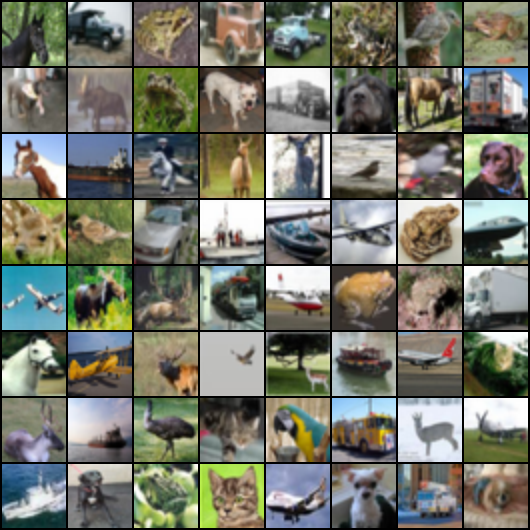

In [14]:
Image.open('output/real_samples.png')

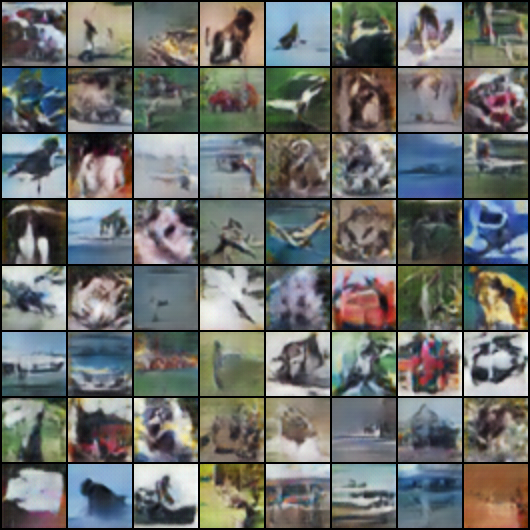

In [15]:
Image.open('output/fake_samples_epoch_024.png')